In [1]:
# Cell 1: Kh·ªüi t·∫°o v√† C·∫•u h√¨nh

import os
import logging 
from typing import List, Dict, Tuple, Union
from sqlalchemy import create_engine, text, Column, Integer, Float, String, DateTime , ForeignKey
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker, relationship
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import ParameterGrid
from collections import defaultdict
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns # Th√™m seaborn ƒë·ªÉ bi·ªÉu ƒë·ªì ƒë·∫πp h∆°n
from sklearn.feature_extraction.text import TfidfVectorizer # Th√™m import n√†y cho Content-based
from sklearn.preprocessing import MultiLabelBinarizer # Th√™m import n√†y cho Content-based
import requests # TH√äM IMPORT N√ÄY ƒê·ªÇ G·ªåI API
import json
import re

# === CONFIGURATION ===
# C√°c bi·∫øn m√¥i tr∆∞·ªùng cho DB v·∫´n gi·ªØ nguy√™n ƒë·ªÉ k·∫øt n·ªëi c∆° s·ªü d·ªØ li·ªáu
DB_USER = os.getenv('DB_USER', 'root')
DB_PASS = os.getenv('DB_PASS', '') # THAY TH·∫æ B·∫∞NG PASSWORD C·ª¶A B·∫†N N·∫æU C√ì
DB_HOST = os.getenv('DB_HOST', 'localhost')
DB_NAME = os.getenv('DB_NAME', 'thesis')

# URL c·ªßa API Laravel ƒë·ªÉ l·∫•y c·∫•u h√¨nh
LARAVEL_SETTINGS_API_URL = os.getenv('LARAVEL_SETTINGS_API_URL', 'http://localhost:8000/api/recommender/settings')

# URL c·ªßa API Laravel ƒë·ªÉ l·∫•y d·ªØ li·ªáu thu·ªôc t√≠nh s·∫£n ph·∫©m (bao g·ªìm EAV)
LARAVEL_PRODUCT_FEATURES_API_URL = os.getenv('LARAVEL_PRODUCT_FEATURES_API_URL', 'http://localhost:8000/api/product-features')

# === LOGGING SETUP ===
# Thi·∫øt l·∫≠p logger ƒë·ªÉ hi·ªÉn th·ªã th√¥ng b√°o
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# H√†m ƒë·ªÉ t·∫£i c·∫•u h√¨nh t·ª´ API Laravel
def load_recommender_settings_from_api(api_url: str) -> Dict[str, Union[int, float, str]]:
    """
    T·∫£i c√°c c√†i ƒë·∫∑t c·ªßa h·ªá th·ªëng g·ª£i √Ω t·ª´ API Laravel.
    """
    logger.info(f"ƒêang t·∫£i c·∫•u h√¨nh h·ªá th·ªëng g·ª£i √Ω t·ª´ API: {api_url}")
    settings = {}
    try:
        response = requests.get(api_url)
        response.raise_for_status() # N√©m l·ªói cho c√°c m√£ tr·∫°ng th√°i HTTP x·∫•u (4xx ho·∫∑c 5xx)
        api_data = response.json()

        if api_data.get('status') == 'success' and 'data' in api_data:
            for setting_item in api_data['data']:
                key = setting_item['key']
                value_str = setting_item['value']
                data_type = setting_item['data_type']

                # Chuy·ªÉn ƒë·ªïi gi√° tr·ªã sang ki·ªÉu d·ªØ li·ªáu ph√π h·ª£p
                if data_type == 'integer':
                    settings[key] = int(value_str)
                elif data_type == 'float':
                    settings[key] = float(value_str)
                elif key == 'PRODUCT_BLACKLIST' and data_type == 'string': # Ho·∫∑c data_type == 'text'
                    try:
                        # T√°ch chu·ªói b·∫±ng d·∫•u ph·∫©y v√† chuy·ªÉn ƒë·ªïi t·ª´ng ph·∫ßn t·ª≠ sang int
                        settings[key] = [int(item.strip()) for item in value_str.split(',') if item.strip()]
                        logger.info(f"ƒê√£ parse PRODUCT_BLACKLIST t·ª´ chu·ªói '{value_str}' th√†nh list: {settings[key]}")
                    except ValueError:
                        logger.warning(f"Kh√¥ng th·ªÉ parse PRODUCT_BLACKLIST t·ª´ chu·ªói '{value_str}' th√†nh list s·ªë nguy√™n. S·ª≠ d·ª•ng r·ªóng.")
                        settings[key] = [] # M·∫∑c ƒë·ªãnh l√† list r·ªóng n·∫øu parse l·ªói
                else: # M·∫∑c ƒë·ªãnh l√† string ho·∫∑c c√°c ki·ªÉu kh√°c
                    settings[key] = value_str
            logger.info(f"ƒê√£ t·∫£i th√†nh c√¥ng {len(settings)} c√†i ƒë·∫∑t t·ª´ API.")
        else:
            logger.error(f"API tr·∫£ v·ªÅ tr·∫°ng th√°i kh√¥ng th√†nh c√¥ng ho·∫∑c thi·∫øu d·ªØ li·ªáu: {api_data.get('message', 'Kh√¥ng c√≥ th√¥ng b√°o.')}")

    except requests.exceptions.RequestException as e:
        logger.error(f"L·ªói khi k·∫øt n·ªëi ƒë·∫øn API Laravel: {e}. S·ª≠ d·ª•ng c√°c gi√° tr·ªã m·∫∑c ƒë·ªãnh.")
    except Exception as e:
        logger.error(f"L·ªói kh√¥ng x√°c ƒë·ªãnh khi t·∫£i c·∫•u h√¨nh t·ª´ API: {e}. S·ª≠ d·ª•ng c√°c gi√° tr·ªã m·∫∑c ƒë·ªãnh.")

    # Cung c·∫•p c√°c gi√° tr·ªã m·∫∑c ƒë·ªãnh n·∫øu API kh√¥ng th·ªÉ t·∫£i ho·∫∑c c√≥ l·ªói
    default_settings = {
        'BATCH_SIZE': 500,
        'TOP_K': 10,
        'TOP_N_RECOMMENDATIONS': 15,
        'COSINE_THRESHOLD': 0.1,
        'HYBRID_ALPHA': 0.5,
        'PRODUCT_BLACKLIST': [] # V√≠ d·ª• m·∫∑c ƒë·ªãnh cho blacklist
    }
    # G·ªôp c√°c c√†i ƒë·∫∑t ƒë√£ t·∫£i v·ªõi c√°c gi√° tr·ªã m·∫∑c ƒë·ªãnh (∆∞u ti√™n c√†i ƒë·∫∑t t·ª´ API)
    final_settings = {**default_settings, **settings}
    return final_settings

# T·∫£i c·∫•u h√¨nh ngay khi script b·∫Øt ƒë·∫ßu
APP_SETTINGS = load_recommender_settings_from_api(LARAVEL_SETTINGS_API_URL)

# G√°n c√°c bi·∫øn c·∫•u h√¨nh t·ª´ APP_SETTINGS
BATCH_SIZE = APP_SETTINGS['BATCH_SIZE']
TOP_K = APP_SETTINGS['TOP_K']
TOP_N_RECOMMENDATIONS = APP_SETTINGS['TOP_N_RECOMMENDATIONS']
COSINE_THRESHOLD = APP_SETTINGS['COSINE_THRESHOLD']
HYBRID_ALPHA = APP_SETTINGS['HYBRID_ALPHA']
# N·∫øu c√≥ th√™m c√°c c√†i ƒë·∫∑t kh√°c, b·∫°n c≈©ng c·∫ßn g√°n ch√∫ng ·ªü ƒë√¢y
PRODUCT_BLACKLIST = APP_SETTINGS.get('PRODUCT_BLACKLIST', []) # ƒê·∫£m b·∫£o c√≥ gi√° tr·ªã m·∫∑c ƒë·ªãnh n·∫øu kh√¥ng c√≥ trong DB

# === DATABASE SETUP ===
Base = declarative_base()
# S·ª≠ d·ª•ng c√°c bi·∫øn DB_USER, DB_PASS, DB_HOST, DB_NAME t·ª´ os.getenv
engine = create_engine(f"mysql+pymysql://{DB_USER}:{DB_PASS}@{DB_HOST}/{DB_NAME}")
SessionLocal = sessionmaker(bind=engine)

# === MODELS ===
class UserEvent(Base):
    __tablename__ = 'user_events'
    id = Column(Integer, primary_key=True, autoincrement=True)
    user_id = Column(Integer, nullable=False)
    product_id = Column(Integer, nullable=False)
    event_type = Column(String(50), nullable=False)
    created_at = Column(DateTime) # Changed to DateTime for proper parsing

class ItemSimilarity(Base):
    __tablename__ = 'item_similarity'
    product_id_1 = Column(Integer, primary_key=True)
    product_id_2 = Column(Integer, primary_key=True)
    score = Column(Float)
    cf_score = Column(Float)
    content_score = Column(Float)


# EAV Models (as per your PHP models)

class Category(Base):
    __tablename__ = 'categories' # Gi·∫£ s·ª≠ t√™n b·∫£ng l√† 'categories'
    id = Column(Integer, primary_key=True)
    name = Column(String(255), nullable=False)
    # C√≥ th·ªÉ th√™m c√°c c·ªôt kh√°c n·∫øu c·∫ßn, v√≠ d·ª• 'slug'

class Brand(Base):
    __tablename__ = 'brands' # Gi·∫£ s·ª≠ t√™n b·∫£ng l√† 'brands'
    id = Column(Integer, primary_key=True)
    name = Column(String(255), nullable=False)
    # C√≥ th·ªÉ th√™m c√°c c·ªôt kh√°c n·∫øu c·∫ßn

class Product(Base):
    __tablename__ = 'products'
    id = Column(Integer, primary_key=True) # ƒê·ªïi product_id th√†nh id ƒë·ªÉ ph√π h·ª£p Laravel
    name = Column(String(255), nullable=False)
    slug = Column(String(255))
    description = Column(String(1000))
    cat_id = Column(Integer, ForeignKey('categories.id'))
    brand_id = Column(Integer, ForeignKey('brands.id'))
    is_featured = Column(Integer) # Gi·∫£ s·ª≠ l√† tinyint ho·∫∑c boolean
    status = Column(String(50))

    # Relationships (optional for this specific task, but good practice)
    category = relationship("Category")
    brand = relationship("Brand")
    variants = relationship("Variant", back_populates="product")


class Variant(Base):
    __tablename__ = 'product_variants' # T√™n b·∫£ng c·ªßa b·∫°n
    id = Column(Integer, primary_key=True) # ID c·ªßa variant
    product_id = Column(Integer, ForeignKey('products.id'), nullable=False)
    sku = Column(String(255))
    price = Column(Float)
    discount = Column(Float)
    stock = Column(Integer)
    image = Column(String(255))
    status = Column(String(50))
    
    product = relationship("Product", back_populates="variants") 
    variant_spec_values = relationship("VariantSpecValue", back_populates="variant") # Th√™m relationship n√†y



class Specification(Base):
    __tablename__ = 'specifications'
    id = Column(Integer, primary_key=True)
    category_id = Column(Integer, ForeignKey('categories.id'))
    name = Column(String(255), nullable=False)
    data_type = Column(String(50))
    unit = Column(String(50))
    description = Column(String(255))

    category = relationship("Category")
    spec_options = relationship("SpecOption", back_populates="specification")
    variant_spec_values = relationship("VariantSpecValue", back_populates="specification")

class SpecOption(Base):
    __tablename__ = 'spec_options'
    id = Column(Integer, primary_key=True)
    spec_id = Column(Integer, ForeignKey('specifications.id'))
    value = Column(String(255), nullable=False)

    specification = relationship("Specification", back_populates="spec_options")

class VariantSpecValue(Base):
    __tablename__ = 'variant_spec_values'
    id = Column(Integer, primary_key=True)
    variant_id = Column(Integer, ForeignKey('product_variants.id'))
    spec_id = Column(Integer, ForeignKey('specifications.id'))
    value_text = Column(String(255))
    value_int = Column(Integer)
    value_decimal = Column(Float)
    option_id = Column(Integer, ForeignKey('spec_options.id'))

    variant = relationship("Variant", back_populates="variant_spec_values")
    specification = relationship("Specification", back_populates="variant_spec_values")
    spec_options = relationship("SpecOption") # T√™n l√† spec_options cho m·ªëi quan h·ªá one-to-one/many-to-one



print("--- Kh·ªüi t·∫°o h·ªá th·ªëng v√† c·∫•u h√¨nh ho√†n t·∫•t ---")
print(f"C∆° s·ªü d·ªØ li·ªáu ƒëang k·∫øt n·ªëi: {DB_HOST}/{DB_NAME}")
print(f"C√†i ƒë·∫∑t h·ªá th·ªëng g·ª£i √Ω ƒë√£ t·∫£i: {APP_SETTINGS}") # In ra c√°c c√†i ƒë·∫∑t ƒë√£ t·∫£i ƒë·ªÉ ki·ªÉm tra




2025-07-25 09:52:44,023 - INFO - ƒêang t·∫£i c·∫•u h√¨nh h·ªá th·ªëng g·ª£i √Ω t·ª´ API: http://localhost:8000/api/recommender/settings
2025-07-25 09:52:48,088 - ERROR - L·ªói khi k·∫øt n·ªëi ƒë·∫øn API Laravel: HTTPConnectionPool(host='localhost', port=8000): Max retries exceeded with url: /api/recommender/settings (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001B9A21F9A80>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it')). S·ª≠ d·ª•ng c√°c gi√° tr·ªã m·∫∑c ƒë·ªãnh.


--- Kh·ªüi t·∫°o h·ªá th·ªëng v√† c·∫•u h√¨nh ho√†n t·∫•t ---
C∆° s·ªü d·ªØ li·ªáu ƒëang k·∫øt n·ªëi: localhost/thesis
C√†i ƒë·∫∑t h·ªá th·ªëng g·ª£i √Ω ƒë√£ t·∫£i: {'BATCH_SIZE': 500, 'TOP_K': 10, 'TOP_N_RECOMMENDATIONS': 15, 'COSINE_THRESHOLD': 0.1, 'HYBRID_ALPHA': 0.5, 'PRODUCT_BLACKLIST': []}


C:\Users\PC\AppData\Local\Temp\ipykernel_3184\40997200.py:115: MovedIn20Warning: The ``declarative_base()`` function is now available as sqlalchemy.orm.declarative_base(). (deprecated since: 2.0) (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base = declarative_base()


In [5]:
import pandas as pd
import numpy as np
from typing import List, Dict, Tuple, Set
from collections import defaultdict
from sqlalchemy import create_engine, text
from sqlalchemy.orm import sessionmaker, declarative_base
from sqlalchemy import Column, Integer, String, Float, DateTime, ForeignKey, Text
from sqlalchemy.orm import relationship

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import logging
import tensorflow as tf
from transformers import AutoTokenizer, AutoModel, TFAutoModel

# === Helper functions for Recommendation Metrics ===
# (Keep all helper functions as they are, they are not the source of the current issue)
def precision_at_n(recommended_list: List[int], actual_interactions: set, n: int) -> float:
    if not recommended_list:
        return 0.0
    recommended_n = recommended_list[:n]
    hits = len(set(recommended_n).intersection(actual_interactions))
    return hits / len(recommended_n)

def recall_at_n(recommended_list: List[int], actual_interactions: set, n: int) -> float:
    if not actual_interactions:
        return 0.0
    recommended_n = recommended_list[:n]
    hits = len(set(recommended_n).intersection(actual_interactions))
    return hits / len(actual_interactions)

def ndcg_at_n(recommended_list: List[int], actual_interactions: set, n: int) -> float:
    if not actual_interactions or not recommended_list:
        return 0.0
    dcg = 0.0
    for i, item in enumerate(recommended_list[:n]):
        if item in actual_interactions:
            dcg += 1.0 / np.log2(i + 2)
    idcg = 0.0
    for i in range(min(n, len(actual_interactions))): 
        idcg += 1.0 / np.log2(i + 2)
    return dcg / idcg if idcg > 0 else 0.0
    
def average_precision(recommended_list: List[int], actual_interactions: set) -> float:
    if not actual_interactions or not recommended_list:
        return 0.0
    score = 0.0
    num_hits = 0.0
    for i, item in enumerate(recommended_list):
        if item in actual_interactions:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    return score / len(actual_interactions)

# === NEW CORE FUNCTIONS FOR IMPLICIT FEEDBACK & OPTIMIZATION ===
# (Keep these as they are, they are not directly related to content issue)
def load_all_user_events() -> pd.DataFrame:
    sql = text("""
    SELECT user_id, product_id, event_type, created_at
    FROM user_events
    """)
    with engine.begin() as conn:
        df = pd.read_sql(sql, conn)
    
    df['created_at'] = pd.to_datetime(df['created_at'])
    logger.info(f"Loaded {len(df)} user events from database.")
    return df
    

def assign_implicit_feedback_scores(df: pd.DataFrame, weights: Dict[str, float],
                                    frequency_decay_factor: float = 0.1,
                                    max_frequency_cap: int = 5) -> pd.DataFrame:
    df_copy = df.copy()
    logger.debug(f"DEBUG_FUNC: weights in func: {weights}")
    logger.debug(f"DEBUG_FUNC: frequency_decay_factor in func: {frequency_decay_factor}")
    df_counts = df_copy.groupby(['user_id', 'product_id', 'event_type']).size().reset_index(name='interaction_count')
    max_weight = max(weights.values()) if weights else 1.0
    scaled_weights = {action: weight / max_weight for action, weight in weights.items()}
    df_counts['base_score'] = df_counts['event_type'].map(scaled_weights).fillna(0)
    df_counts['log_interaction_count'] = np.log1p(df_counts['interaction_count'])
    df_counts['frequency_score_addition'] = df_counts['base_score'] * df_counts['log_interaction_count'] * frequency_decay_factor
    df_counts['final_implicit_score'] = df_counts['base_score'] + df_counts['frequency_score_addition']
    
    if 'view' in weights and 'view' in df_counts['event_type'].unique():
        debug_view_rows = df_counts[df_counts['event_type'] == 'view'].head(5)
        logger.debug(f"DEBUG_FUNC: Debugging 'view' rows (before final clip):")
        logger.debug(debug_view_rows[['event_type', 'interaction_count', 'base_score', 'log_interaction_count', 'frequency_score_addition', 'final_implicit_score']].to_string(float_format='{:.10f}'.format))

    df_counts['final_implicit_score'] = df_counts['final_implicit_score'].clip(lower=0, upper=1.0)
    df_copy = df_copy.merge(
        df_counts[['user_id', 'product_id', 'event_type', 'final_implicit_score']],
        on=['user_id', 'product_id', 'event_type'],
        how='left'
    )
    df_copy['implicit_score'] = df_copy['final_implicit_score']
    df_copy.drop(columns=['final_implicit_score'], inplace=True)
    logger.info(f"Assigned implicit scores considering frequency with log transform. Min score: {df_copy['implicit_score'].min():.4f}, Max score: {df_copy['implicit_score'].max():.4f}")
    return df_copy

def split_data_time_based(df: pd.DataFrame, train_ratio: float = 0.6, val_ratio: float = 0.2, test_ratio: float = 0.2) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    if not np.isclose(train_ratio + val_ratio + test_ratio, 1.0):
        raise ValueError("train_ratio + val_ratio + test_ratio must sum to 1.0")
    df = df.sort_values(by=['user_id', 'created_at']).reset_index(drop=True)
    df_train_indices = []
    df_val_indices = []
    df_test_indices = []
    for user_id, group_indices in df.groupby('user_id').groups.items():
        group = df.loc[group_indices].sort_values(by='created_at')
        total_interactions = len(group)
        train_split_point = int(total_interactions * train_ratio)
        val_split_point = int(total_interactions * (train_ratio + val_ratio))
        df_train_indices.extend(group.iloc[:train_split_point].index.tolist())
        df_val_indices.extend(group.iloc[train_split_point:val_split_point].index.tolist())
        df_test_indices.extend(group.iloc[val_split_point:].index.tolist())
    df_train = df.loc[df_train_indices].reset_index(drop=True)
    df_val = df.loc[df_val_indices].reset_index(drop=True)
    df_test = df.loc[df_test_indices].reset_index(drop=True)
    logger.info(f"Data split: Train {len(df_train)} events, Validation {len(df_val)} events, Test {len(df_test)} events.")
    return df_train, df_val, df_test

# === FUNCTIONS FOR CONTENT-BASED FILTERING (Item-Item) ===

def get_rich_product_data_from_db() -> pd.DataFrame:
    """
    T·∫£i d·ªØ li·ªáu s·∫£n ph·∫©m to√†n di·ªán bao g·ªìm c√°c bi·∫øn th·ªÉ v√† th√¥ng s·ªë k·ªπ thu·∫≠t
    t·ª´ c∆° s·ªü d·ªØ li·ªáu b·∫±ng SQLAlchemy.
    SAU ƒê√ì, G·ªòP D·ªÆ LI·ªÜU C√ÅC BI·∫æN TH·ªÇ V·ªÄ C·∫§P S·∫¢N PH·∫®M G·ªêC.
    """
    logger.info("ƒêang t·∫£i d·ªØ li·ªáu s·∫£n ph·∫©m ƒë·∫ßy ƒë·ªß t·ª´ c∆° s·ªü d·ªØ li·ªáu...")

    # C·∫•u h√¨nh c√°c thu·ªôc t√≠nh quan tr·ªçng theo Category ƒë·ªÉ d·ªÖ d√†ng c·∫≠p nh·∫≠t
    CATEGORY_SPEC_CONFIG = {
        'ƒêi·ªán tho·∫°i': ['M√†u s·∫Øc', 'K√≠ch th∆∞·ªõc m√†n h√¨nh', 'RAM', 'Dung l∆∞·ª£ng b·ªô nh·ªõ', 'Lo·∫°i chip', 'S·ªë camera ch√≠nh', 'C√¥ng ngh·ªá s·∫°c nhanh', 'C√¥ng ngh·ªá m√†n h√¨nh'],
        'Laptop': ['Lo·∫°i CPU', 'RAM', 'Lo·∫°i ·ªï c·ª©ng', 'Dung l∆∞·ª£ng ·ªï c·ª©ng', 'Card ƒë·ªì h·ªça', 'K√≠ch th∆∞·ªõc m√†n h√¨nh', 'ƒê·ªô ph√¢n gi·∫£i m√†n h√¨nh'],
        'TV': ['K√≠ch th∆∞·ªõc m√†n h√¨nh', 'ƒê·ªô ph√¢n gi·∫£i', 'Lo·∫°i panel', 'T·∫ßn s·ªë qu√©t', 'H·ªá ƒëi·ªÅu h√†nh'],
        'Tai nghe': ['Lo·∫°i k·∫øt n·ªëi', 'C√¥ng ngh·ªá ch·ªëng ·ªìn', 'Th·ªùi l∆∞·ª£ng pin', 'Lo·∫°i tai nghe', 'M√†u s·∫Øc'],
        'C·ªß s·∫°c': ['C√¥ng su·∫•t s·∫°c', 'S·ªë c·ªïng', 'Lo·∫°i c·ªïng', 'M√†u s·∫Øc'],
        '·ªêp l∆∞ng': ['Lo·∫°i v·∫≠t li·ªáu', 'M√†u s·∫Øc', 'T∆∞∆°ng th√≠ch'],
        'Default': ['M√†u s·∫Øc', 'C√¥ng su·∫•t', 'Ch·∫•t li·ªáu', 'K√≠ch th∆∞·ªõc', 'Kh·ªëi l∆∞·ª£ng']
    }

    UNIT_MAP = {
        'RAM': 'GB',
        'Dung l∆∞·ª£ng b·ªô nh·ªõ': 'GB',
        'Dung l∆∞·ª£ng ·ªï c·ª©ng': 'GB',
        'Th·ªùi l∆∞·ª£ng pin': 'gi·ªù',
        'C√¥ng su·∫•t s·∫°c': 'W'
    }

    try:
        db = SessionLocal()
        products_query_results = db.query(
            Product.id,
            Product.name,
            Product.description,
            Category.name.label('category_name'),
            Brand.name.label('brand_name'),
            Variant.id.label('variant_id'),
            Variant.sku,
            Variant.price,
            Variant.discount,
            Specification.name.label('spec_name'),
            SpecOption.value.label('option_value'),
            VariantSpecValue.value_text,
            VariantSpecValue.value_int,
            VariantSpecValue.value_decimal
        ).join(Category, Product.cat_id == Category.id)\
        .join(Brand, Product.brand_id == Brand.id)\
        .join(Variant, Product.id == Variant.product_id)\
        .outerjoin(VariantSpecValue, Variant.id == VariantSpecValue.variant_id)\
        .outerjoin(Specification, VariantSpecValue.spec_id == Specification.id)\
        .outerjoin(SpecOption, VariantSpecValue.option_id == SpecOption.id)\
        .all()
        db.close()

        temp_variant_data = defaultdict(lambda: {
            'product_id': None,
            'product_name': None,
            'description': None,
            'category_name': None,
            'brand_name': None,
            'specs_by_variant': defaultdict(list)
        })

        for row in products_query_results:
            prod_id = row.id
            variant_id = row.variant_id

            if temp_variant_data[prod_id]['product_id'] is None:
                temp_variant_data[prod_id]['product_id'] = prod_id
                temp_variant_data[prod_id]['product_name'] = row.name
                temp_variant_data[prod_id]['description'] = row.description
                temp_variant_data[prod_id]['category_name'] = row.category_name
                temp_variant_data[prod_id]['brand_name'] = row.brand_name
            
            if variant_id is not None and row.spec_name:
                spec_value = row.option_value or row.value_text or row.value_int or row.value_decimal
                if spec_value is not None:
                    temp_variant_data[prod_id]['specs_by_variant'][variant_id].append({
                        'spec_name': row.spec_name,
                        'value': spec_value
                    })

        final_product_level_data = []
        for prod_id, prod_info in temp_variant_data.items():
            product_name = prod_info['product_name']
            description = prod_info['description']
            category_name = prod_info['category_name']
            brand_name = prod_info['brand_name']

            all_variant_features_texts = []

            # L·∫•y c·∫•u h√¨nh spec c·ª• th·ªÉ cho category n√†y ho·∫∑c d√πng default
            specs_to_include = CATEGORY_SPEC_CONFIG.get(category_name, CATEGORY_SPEC_CONFIG['Default'])
            
            for var_id, var_specs_list in prod_info['specs_by_variant'].items():
                features_text_parts = [
                    brand_name, # Th√™m t√™n th∆∞∆°ng hi·ªáu ·ªü ƒë·∫ßu ƒë·ªÉ tƒÉng tr·ªçng s·ªë
                    category_name, # Th√™m t√™n danh m·ª•c
                    product_name,
                    description,
                ]
                
                # T·∫°o m·ªôt dict ƒë·ªÉ d·ªÖ d√†ng tra c·ª©u spec value
                spec_dict = {spec['spec_name']: spec['value'] for spec in var_specs_list if spec['spec_name']}

                for spec_name in specs_to_include:
                    if spec_name in spec_dict:
                        value = spec_dict[spec_name]
                        unit = UNIT_MAP.get(spec_name, '') # L·∫•y ƒë∆°n v·ªã n·∫øu c√≥
                        # Chu·∫©n h√≥a c√°ch th√™m spec_name v√† value
                        if spec_name in ['Lo·∫°i chip', 'Card ƒë·ªì h·ªça', 'Lo·∫°i CPU', 'Lo·∫°i k·∫øt n·ªëi', 'Lo·∫°i tai nghe', 'Lo·∫°i panel', 'Lo·∫°i v·∫≠t li·ªáu']:
                            features_text_parts.append(f"{value}") # Ch·ªâ c·∫ßn gi√° tr·ªã v√¨ t√™n spec ƒë√£ r√µ
                        elif spec_name in ['K√≠ch th∆∞·ªõc m√†n h√¨nh', 'ƒê·ªô ph√¢n gi·∫£i', 'RAM', 'Dung l∆∞·ª£ng b·ªô nh·ªõ', 'Dung l∆∞·ª£ng ·ªï c·ª©ng', 'Th·ªùi l∆∞·ª£ng pin', 'C√¥ng su·∫•t s·∫°c', 'S·ªë camera ch√≠nh', 'S·ªë c·ªïng']:
                            features_text_parts.append(f"{value}{unit}") # Gi√° tr·ªã + ƒë∆°n v·ªã
                        else:
                            features_text_parts.append(f"{spec_name} {value}") # T√™n spec + gi√° tr·ªã

                combined_variant_features = " ".join(filter(None, features_text_parts)).lower()
                combined_variant_features = re.sub(r'\s+', ' ', combined_variant_features).strip()
                all_variant_features_texts.append(combined_variant_features)
            
            # G·ªôp c√°c feature text t·ª´ t·∫•t c·∫£ c√°c bi·∫øn th·ªÉ v√†o m·ªôt chu·ªói duy nh·∫•t cho s·∫£n ph·∫©m g·ªëc
            # S·ª≠ d·ª•ng set ƒë·ªÉ ƒë·∫£m b·∫£o kh√¥ng c√≥ t·ª´/c·ª•m t·ª´ tr√πng l·∫∑p t·ª´ c√°c bi·∫øn th·ªÉ
            product_level_features_text = " ".join(sorted(list(set(" ".join(all_variant_features_texts).split())))) # G·ªôp, t√°ch t·ª´, lo·∫°i b·ªè tr√πng l·∫∑p v√† s·∫Øp x·∫øp l·∫°i

            # N·∫øu kh√¥ng c√≥ spec n√†o, ch·ªâ l·∫•y t√™n, m√¥ t·∫£, danh m·ª•c, th∆∞∆°ng hi·ªáu
            if not product_level_features_text and (product_name or description or category_name or brand_name):
                product_level_features_text = " ".join(filter(None, [brand_name, category_name, product_name, description])).lower()
                product_level_features_text = re.sub(r'\s+', ' ', product_level_features_text).strip()

            final_product_level_data.append({
                'product_id': prod_id,
                'product_name': product_name,
                'description': description,
                'category_name': category_name,
                'brand_name': brand_name,
                'features_text': product_level_features_text
            })

        df = pd.DataFrame(final_product_level_data)
        logger.info(f"ƒê√£ t·∫£i v√† g·ªôp th√†nh c√¥ng {len(df)} s·∫£n ph·∫©m g·ªëc.")
        return df

    except Exception as e:
        logger.error(f"L·ªói khi t·∫£i d·ªØ li·ªáu s·∫£n ph·∫©m t·ª´ DB: {e}")
        return pd.DataFrame()
    finally:
        if 'db' in locals() and db:
            db.close()


# Bi·∫øn to√†n c·ª•c cho BERT v·ªõi TensorFlow
GLOBAL_BERT_TOKENIZER: AutoTokenizer = None
GLOBAL_BERT_MODEL: TFAutoModel = None # THAY ƒê·ªîI ·ªû ƒê√ÇY
GLOBAL_PRODUCT_EMBEDDINGS: tf.Tensor = None # THAY ƒê·ªîI ·ªû ƒê√ÇY
GLOBAL_PRODUCT_ID_MAP: Dict[int, int] = {}
TOP_K = 10 # Example value, make sure it's defined globally


def mean_pooling_tf(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state  # L·∫•y last_hidden_state t·ª´ TFBaseModelOutput
    input_mask_expanded = tf.cast(tf.expand_dims(attention_mask, -1), tf.float32)
    sum_embeddings = tf.reduce_sum(token_embeddings * input_mask_expanded, axis=1)
    sum_mask = tf.clip_by_value(tf.reduce_sum(input_mask_expanded, axis=1), 1e-9, tf.float32.max)
    return sum_embeddings / sum_mask


def initialize_global_bert_model(df_products_product_level: pd.DataFrame):
    global GLOBAL_BERT_TOKENIZER, GLOBAL_BERT_MODEL, GLOBAL_PRODUCT_EMBEDDINGS, GLOBAL_PRODUCT_ID_MAP
    
    if GLOBAL_BERT_MODEL is not None:
        logger.info("BERT model already initialized. Skipping re-initialization.")
        return

    logger.info("Initializing global Vietnamese-BERT model and generating embeddings (TensorFlow backend)...")
    
    # 1. T·∫£i tokenizer v√† model BERT ti·∫øng Vi·ªát
    # V·∫´n d√πng c√πng t√™n m√¥ h√¨nh, nh∆∞ng s·∫Ω t·∫£i phi√™n b·∫£n TensorFlow
    model_name = "vinai/phobert-base" 
    try:
        GLOBAL_BERT_TOKENIZER = AutoTokenizer.from_pretrained(model_name)
        GLOBAL_BERT_MODEL = TFAutoModel.from_pretrained(model_name) # THAY ƒê·ªîI ·ªû ƒê√ÇY (TFAutoModel)
        logger.info("BERT model loaded for TensorFlow.")
    except Exception as e:
        logger.error(f"L·ªói khi t·∫£i tokenizer ho·∫∑c model BERT: {e}. ƒê·∫£m b·∫£o b·∫°n ƒë√£ c√†i ƒë·∫∑t 'transformers' v√† 'tensorflow' v√† c√≥ k·∫øt n·ªëi internet.")
        return

    if df_products_product_level.empty or 'features_text' not in df_products_product_level.columns:
        logger.warning("No product data or 'features_text' found to generate embeddings.")
        return

    df_products_product_level['features_text'] = df_products_product_level['features_text'].fillna('')
    if df_products_product_level['features_text'].str.strip().eq('').all():
        logger.warning("All 'features_text' are empty. Cannot generate meaningful BERT embeddings.")
        return

    # 2. T·∫°o embeddings cho t·∫•t c·∫£ c√°c features_text
    texts = df_products_product_level['features_text'].tolist()
    
    # Chia th√†nh c√°c batch ƒë·ªÉ x·ª≠ l√Ω
    batch_size = 32 # T√πy ch·ªânh batch size t√πy thu·ªôc v√†o VRAM GPU ho·∫∑c RAM
    all_embeddings = []

    # S·ª≠ d·ª•ng tf.data.Dataset ƒë·ªÉ x·ª≠ l√Ω batching hi·ªáu qu·∫£ h∆°n v·ªõi TensorFlow
    dataset = tf.data.Dataset.from_tensor_slices(texts).batch(batch_size)

    for i, batch_texts in enumerate(dataset):
        # Decode tensor batch_texts to Python list of strings
        batch_texts_list = [t.decode('utf-8') for t in batch_texts.numpy()]
        
        encoded_input = GLOBAL_BERT_TOKENIZER(
            batch_texts_list, # Truy·ªÅn list of strings
            padding=True, 
            truncation=True, 
            max_length=256, 
            return_tensors='tf' # THAY ƒê·ªîI ·ªû ƒê√ÇY
        )
        
        model_output = GLOBAL_BERT_MODEL(**encoded_input)
        
        # Th·ª±c hi·ªán Mean Pooling ƒë·ªÉ c√≥ ƒë∆∞·ª£c embedding c·ªßa c√¢u
        sentence_embeddings = mean_pooling_tf(model_output, encoded_input['attention_mask'])
        
        all_embeddings.append(sentence_embeddings)

    GLOBAL_PRODUCT_EMBEDDINGS = tf.concat(all_embeddings, axis=0) # G·ªôp t·∫•t c·∫£ embeddings l·∫°i
    logger.info(f"Global product embeddings shape: {GLOBAL_PRODUCT_EMBEDDINGS.shape}")

    GLOBAL_PRODUCT_ID_MAP = {pid: idx for idx, pid in enumerate(df_products_product_level['product_id'])}
    logger.info(f"Global BERT model initialized and embeddings generated successfully. Mapped {len(GLOBAL_PRODUCT_ID_MAP)} product IDs.")


def compute_content_similarity(df_products_for_map: pd.DataFrame, top_k: int = TOP_K) -> Dict[int, List[Tuple[int, float]]]:
    logger.info("Computing content-based item-item similarity at PRODUCT level using BERT embeddings (TensorFlow backend)...")

    if GLOBAL_BERT_MODEL is None or GLOBAL_PRODUCT_EMBEDDINGS is None:
        logger.error("Global BERT model or product embeddings not initialized. Cannot compute content similarity. Please call initialize_global_bert_model first.")
        return {}
    
    if GLOBAL_PRODUCT_EMBEDDINGS.shape[0] == 0:
        logger.warning("GLOBAL_PRODUCT_EMBEDDINGS is empty. Cannot compute content similarity.")
        return {}

    # Chuy·ªÉn embeddings v·ªÅ d·∫°ng numpy array ƒë·ªÉ d√πng sklearn's cosine_similarity
    embeddings_np = GLOBAL_PRODUCT_EMBEDDINGS.numpy()
    
    content_sim_matrix = cosine_similarity(embeddings_np, dense_output=True) 

    logger.info(f"Content similarity matrix shape: {content_sim_matrix.shape}")
    
    content_similarities: Dict[int, List[Tuple[int, float]]] = {}
    index_to_product_id_map = {idx: pid for pid, idx in GLOBAL_PRODUCT_ID_MAP.items()}

    # C√°c product_id b·∫°n mu·ªën debug chi ti·∫øt (v√≠ d·ª•: c√°c s·∫£n ph·∫©m Xiaomi, iPhone, Samsung t·ª´ tr∆∞·ªõc)
    # target_product_ids = {64, 65, 66, 67, 74, 56, 58, 59, 73, 61} # Th√™m c√°c ID li√™n quan ƒë·ªÉ debug

    for i, product_id_i in index_to_product_id_map.items():
        row = content_sim_matrix[i] 
        
        filtered_neighbors = []
        for j_idx, s in enumerate(row):
            if j_idx != i and s > 1e-6: # Ng∆∞·ª°ng nh·ªè ƒë·ªÉ lo·∫°i b·ªè noise
                filtered_neighbors.append((j_idx, s))

        if filtered_neighbors:
            topk_pairs = sorted(filtered_neighbors, key=lambda x: x[1], reverse=True)[:top_k]
            content_similarities[product_id_i] = [(index_to_product_id_map[j_idx], float(s)) for j_idx, s in topk_pairs]
            # Debugging cho c√°c s·∫£n ph·∫©m c·ª• th·ªÉ
            # if product_id_i in target_product_ids:
            #     logger.info(f"  Top {len(content_similarities[product_id_i])} content-based similarities for {product_id_i}: {content_similarities[product_id_i]}")
        else:
            content_similarities[product_id_i] = []
            # if product_id_i in target_product_ids:
            #     logger.info(f"  No content-based similarities found (after filtering) for product {product_id_i}.")

    logger.info(f"Finished computing content-based item-item similarity for {len(content_similarities)} products.")
    all_scores = [score for sims in content_similarities.values() for _, score in sims]
    if all_scores:
        logger.info(f"Max content similarity score after filtering and top-k: {max(all_scores)}")
    else:
        logger.warning("No content similarities found after all processing steps.")
    return content_similarities

def combine_similarities(
    collab_sims: Dict[int, List[Tuple[int, float]]],
    content_sims: Dict[int, List[Tuple[int, float]]],
    alpha_base: float,
    item_interaction_counts: Dict[int, int],
    cold_start_threshold: int,
    top_k: int = 10,
    min_alpha_cold_start: float = 0.1
) -> Dict[int, List[Tuple[int, float, float, float]]]:
    logger.info(f"Combining similarities with base_alpha={alpha_base}, cold_start_threshold={cold_start_threshold}")

    hybrid_similarities_detail: Dict[int, Dict[int, Tuple[float, float, float]]] = defaultdict(lambda: defaultdict(lambda: (0.0, 0.0, 0.0)))

    all_product_ids = set(collab_sims.keys()).union(set(content_sims.keys()))

    for p1 in all_product_ids:
        p1_interactions = item_interaction_counts.get(p1, 0)

        dynamic_alpha = alpha_base
        if p1_interactions < cold_start_threshold:
            reduction_factor = (cold_start_threshold - p1_interactions) / cold_start_threshold
            dynamic_alpha = alpha_base * (1 - reduction_factor)
            dynamic_alpha = max(min_alpha_cold_start, dynamic_alpha)
            logger.debug(f"Product {p1} is cold-start ({p1_interactions} interactions < {cold_start_threshold}). Dynamic alpha adjusted to: {dynamic_alpha:.4f}")
        else:
            logger.debug(f"Product {p1} is warm-start ({p1_interactions} interactions >= {cold_start_threshold}). Dynamic alpha: {dynamic_alpha:.4f}")
        
        logger.info(f"DEBUGGING ALPHA: For p1={p1} (Interactions: {p1_interactions}), cold_start_threshold={cold_start_threshold}, dynamic_alpha used: {dynamic_alpha:.4f}")

        collab_neighbors_map = {p2: score for p2, score in collab_sims.get(p1, [])}
        content_neighbors_map = {p2: score for p2, score in content_sims.get(p1, [])}

        all_neighbors_for_p1 = set(collab_neighbors_map.keys()).union(set(content_neighbors_map.keys()))

        for p2 in all_neighbors_for_p1:
            if p1 == p2:
                continue

            cf_score = collab_neighbors_map.get(p2, 0.0)
            content_score = content_neighbors_map.get(p2, 0.0)

            hybrid_score = (dynamic_alpha * cf_score) + ((1 - dynamic_alpha) * content_score)

            hybrid_similarities_detail[p1][p2] = (
                max(0.0, float(hybrid_score)),
                max(0.0, float(cf_score)),
                max(0.0, float(content_score))
            )

    final_hybrid_sims: Dict[int, List[Tuple[int, float, float, float]]] = {}
    for p1, p2_scores_detail in hybrid_similarities_detail.items():
        sorted_neighbors = sorted(p2_scores_detail.items(), key=lambda x: x[1][0], reverse=True)[:top_k]
        final_hybrid_sims[p1] = [(p2, hs, cfs, cons) for p2, (hs, cfs, cons) in sorted_neighbors]

    logger.info(f"Finished combining similarities for {len(final_hybrid_sims)} products, now including detailed scores and dynamic alpha.")
    return final_hybrid_sims

# V√≠ d·ª• v·ªÅ h√†m load_product_features
def load_product_features() -> pd.DataFrame:
    logger.info("B·∫Øt ƒë·∫ßu t·∫£i d·ªØ li·ªáu thu·ªôc t√≠nh s·∫£n ph·∫©m...")
    try:
        df_product_features = get_rich_product_data_from_db() # G·ªçi h√†m ƒë√£ s·ª≠a ƒë·ªïi
        if df_product_features.empty:
            logger.warning("DataFrame thu·ªôc t√≠nh s·∫£n ph·∫©m r·ªóng sau khi t·∫£i.")
        else:
            logger.info(f"ƒê√£ t·∫£i {len(df_product_features)} s·∫£n ph·∫©m v·ªõi thu·ªôc t√≠nh.")
            # Debug: Ki·ªÉm tra m·ªôt v√†i features_text ƒë·∫ßu ti√™n
            logger.info("Sample features_text:")
            for i, row in df_product_features.head(5).iterrows():
                logger.info(f"  Product ID {row['product_id']}: {row['features_text'][:200]}...") # Gi·ªõi h·∫°n 200 k√Ω t·ª± ƒë·ªÉ d·ªÖ ƒë·ªçc
        return df_product_features
    except Exception as e:
        logger.error(f"L·ªói khi t·∫£i d·ªØ li·ªáu thu·ªôc t√≠nh s·∫£n ph·∫©m: {e}")
        return pd.DataFrame()
        
print("--- ƒê·ªãnh nghƒ©a c√°c h√†m h·ªó tr·ª£ v√† x·ª≠ l√Ω d·ªØ li·ªáu ho√†n t·∫•t ---")

# # === FUNCTIONS FOR CONTENT-BASED FILTERING (Item-Item) ===

# def get_rich_product_data_from_db() -> pd.DataFrame: # <<< B·ªé ƒê·ªêI S·ªê 'session' ·ªü ƒë√¢y
#     """
#     T·∫£i d·ªØ li·ªáu s·∫£n ph·∫©m to√†n di·ªán bao g·ªìm c√°c bi·∫øn th·ªÉ v√† th√¥ng s·ªë k·ªπ thu·∫≠t
#     t·ª´ c∆° s·ªü d·ªØ li·ªáu b·∫±ng SQLAlchemy.
#     SAU ƒê√ì, G·ªòP D·ªÆ LI·ªÜU C√ÅC BI·∫æN TH·ªÇ V·ªÄ C·∫§P S·∫¢N PH·∫®M G·ªêC.
#     """
#     logger.info("ƒêang t·∫£i d·ªØ li·ªáu s·∫£n ph·∫©m ƒë·∫ßy ƒë·ªß t·ª´ c∆° s·ªü d·ªØ li·ªáu...")

#     # C·∫•u h√¨nh c√°c thu·ªôc t√≠nh quan tr·ªçng theo Category ƒë·ªÉ d·ªÖ d√†ng c·∫≠p nh·∫≠t
#     CATEGORY_SPEC_CONFIG = {
#         'ƒêi·ªán tho·∫°i': ['M√†u s·∫Øc', 'K√≠ch th∆∞·ªõc m√†n h√¨nh', 'RAM', 'Dung l∆∞·ª£ng b·ªô nh·ªõ', 'Lo·∫°i chip', 'S·ªë camera ch√≠nh', 'C√¥ng ngh·ªá s·∫°c nhanh', 'C√¥ng ngh·ªá m√†n h√¨nh'],
#         'Laptop': ['Lo·∫°i CPU', 'RAM', 'Lo·∫°i ·ªï c·ª©ng', 'Dung l∆∞·ª£ng ·ªï c·ª©ng', 'Card ƒë·ªì h·ªça', 'K√≠ch th∆∞·ªõc m√†n h√¨nh', 'ƒê·ªô ph√¢n gi·∫£i m√†n h√¨nh'],
#         'TV': ['K√≠ch th∆∞·ªõc m√†n h√¨nh', 'ƒê·ªô ph√¢n gi·∫£i', 'Lo·∫°i panel', 'T·∫ßn s·ªë qu√©t', 'H·ªá ƒëi·ªÅu h√†nh'],
#         'Tai nghe': ['Lo·∫°i k·∫øt n·ªëi', 'C√¥ng ngh·ªá ch·ªëng ·ªìn', 'Th·ªùi l∆∞·ª£ng pin', 'Lo·∫°i tai nghe', 'M√†u s·∫Øc'],
#         'C·ªß s·∫°c': ['C√¥ng su·∫•t s·∫°c', 'S·ªë c·ªïng', 'Lo·∫°i c·ªïng', 'M√†u s·∫Øc'],
#         '·ªêp l∆∞ng': ['Lo·∫°i v·∫≠t li·ªáu', 'M√†u s·∫Øc', 'T∆∞∆°ng th√≠ch'],
#         'Default': ['M√†u s·∫Øc', 'C√¥ng su·∫•t', 'Ch·∫•t li·ªáu', 'K√≠ch th∆∞·ªõc', 'Kh·ªëi l∆∞·ª£ng']
#     }

#     UNIT_MAP = {
#         'RAM': 'GB',
#         'Dung l∆∞·ª£ng b·ªô nh·ªõ': 'GB',
#         'Dung l∆∞·ª£ng ·ªï c·ª©ng': 'GB',
#         'Th·ªùi l∆∞·ª£ng pin': 'gi·ªù',
#         'C√¥ng su·∫•t s·∫°c': 'W'
#     }

#     try:
#         # S·ª≠ d·ª•ng m·ªôt session m·ªõi cho m·ªói l·∫ßn g·ªçi h√†m n√†y
#         db = SessionLocal() # <<< TH√äM D√íNG N√ÄY ƒê·ªÇ T·∫†O SESSION >>>
#         products_query_results = db.query( # <<< THAY 'session' b·∫±ng 'db' >>>
#             Product.id,
#             Product.name,
#             Product.description,
#             Category.name.label('category_name'),
#             Brand.name.label('brand_name'),
#             Variant.id.label('variant_id'),
#             Variant.sku,
#             Variant.price,
#             Variant.discount,
#             Specification.name.label('spec_name'),
#             SpecOption.value.label('option_value'),
#             VariantSpecValue.value_text,
#             VariantSpecValue.value_int,
#             VariantSpecValue.value_decimal
#         ).join(Category, Product.cat_id == Category.id)\
#         .join(Brand, Product.brand_id == Brand.id)\
#         .join(Variant, Product.id == Variant.product_id)\
#         .outerjoin(VariantSpecValue, Variant.id == VariantSpecValue.variant_id)\
#         .outerjoin(Specification, VariantSpecValue.spec_id == Specification.id)\
#         .outerjoin(SpecOption, VariantSpecValue.option_id == SpecOption.id)\
#         .all()
#         db.close() # <<< ƒê√ìNG SESSION SAU KHI D√ôNG >>>

#         temp_variant_data = defaultdict(lambda: {
#             'product_id': None,
#             'product_name': None,
#             'description': None,
#             'category_name': None,
#             'brand_name': None,
#             'specs_by_variant': defaultdict(list)
#         })

#         for row in products_query_results:
#             prod_id = row.id
#             variant_id = row.variant_id

#             if temp_variant_data[prod_id]['product_id'] is None:
#                 temp_variant_data[prod_id]['product_id'] = prod_id
#                 temp_variant_data[prod_id]['product_name'] = row.name
#                 temp_variant_data[prod_id]['description'] = row.description
#                 temp_variant_data[prod_id]['category_name'] = row.category_name
#                 temp_variant_data[prod_id]['brand_name'] = row.brand_name
            
#             if variant_id is not None and row.spec_name:
#                 spec_value = row.option_value or row.value_text or row.value_int or row.value_decimal
#                 if spec_value is not None:
#                     temp_variant_data[prod_id]['specs_by_variant'][variant_id].append({
#                         'spec_name': row.spec_name,
#                         'value': spec_value
#                     })

#         final_product_level_data = []
#         for prod_id, prod_info in temp_variant_data.items():
#             product_name = prod_info['product_name']
#             description = prod_info['description']
#             category_name = prod_info['category_name']
#             brand_name = prod_info['brand_name']

#             all_variant_features_texts = []

#             for var_id, var_specs_list in prod_info['specs_by_variant'].items():
#                 features_text_parts = [
#                     product_name,
#                     description,
#                     category_name,
#                     brand_name
#                 ]
#                 for spec in var_specs_list:
#                     if spec['spec_name'] is not None:
#                         features_text_parts.append(spec['spec_name'])
#                     if spec['value'] is not None:
#                         features_text_parts.append(str(spec['value']))

#                 combined_variant_features = " ".join(filter(None, features_text_parts)).lower()
#                 combined_variant_features = re.sub(r'\s+', ' ', combined_variant_features).strip()
#                 all_variant_features_texts.append(combined_variant_features)
            
#             product_level_features_text = " ".join(sorted(list(set(all_variant_features_texts))))
            
#             if not product_level_features_text and (product_name or description or category_name or brand_name):
#                 product_level_features_text = " ".join(filter(None, [product_name, description, category_name, brand_name])).lower()
#                 product_level_features_text = re.sub(r'\s+', ' ', product_level_features_text).strip()

#             final_product_level_data.append({
#                 'product_id': prod_id,
#                 'product_name': product_name,
#                 'description': description,
#                 'category_name': category_name,
#                 'brand_name': brand_name,
#                 'features_text': product_level_features_text
#             })

#         df = pd.DataFrame(final_product_level_data)
#         logger.info(f"ƒê√£ t·∫£i v√† g·ªôp th√†nh c√¥ng {len(df)} s·∫£n ph·∫©m g·ªëc.")
#         return df

#     except Exception as e:
#         logger.error(f"L·ªói khi t·∫£i d·ªØ li·ªáu s·∫£n ph·∫©m t·ª´ DB: {e}")
#         return pd.DataFrame() # Tr·∫£ v·ªÅ DataFrame r·ªóng khi c√≥ l·ªói
#     finally:
#         # ƒê·∫£m b·∫£o session ƒë∆∞·ª£c ƒë√≥ng ngay c·∫£ khi c√≥ l·ªói
#         if 'db' in locals() and db:
#             db.close()


# GLOBAL_TFIDF_VECTORIZER = None
# GLOBAL_TFIDF_MATRIX_ALL_PRODUCTS = None
# GLOBAL_PRODUCT_ID_MAP = {}

# def initialize_global_tfidf_model(df_products_product_level: pd.DataFrame):
#     global GLOBAL_TFIDF_VECTORIZER, GLOBAL_TFIDF_MATRIX_ALL_PRODUCTS, GLOBAL_PRODUCT_ID_MAP
    
#     if GLOBAL_TFIDF_VECTORIZER is not None:
#         logger.info("TF-IDF model already initialized. Skipping re-initialization.")
#         return

#     logger.info("Initializing global TF-IDF model for all product features (from aggregated data)...")
#     if df_products_product_level.empty or 'features_text' not in df_products_product_level.columns:
#         logger.warning("No product data or 'features_text' found to initialize TF-IDF model.")
#         return

#     df_products_product_level['features_text'] = df_products_product_level['features_text'].fillna('')
#     if df_products_product_level['features_text'].str.strip().eq('').all():
#         logger.warning("All 'features_text' are empty. Cannot initialize meaningful TF-IDF model.")
#         return

#     tfidf_vectorizer = TfidfVectorizer(
#         stop_words=None,
#         min_df=1,
#         max_df=1.0,
#         ngram_range=(1, 2)
#     )
#     logger.info(f"TF-IDF Vectorizer initialized with min_df={tfidf_vectorizer.min_df}, max_df={tfidf_vectorizer.max_df}, ngram_range={tfidf_vectorizer.ngram_range}, stop_words={tfidf_vectorizer.stop_words}")

#     try:
#         tfidf_matrix = tfidf_vectorizer.fit_transform(df_products_product_level['features_text'])
#         logger.info(f"Global TF-IDF matrix shape: {tfidf_matrix.shape}")
#         logger.info(f"Global TF-IDF matrix non-zero elements (nnz): {tfidf_matrix.nnz}")

#         if tfidf_matrix.nnz == 0:
#             logger.error("Global TF-IDF matrix is entirely zeros. No meaningful features extracted.")
#             if len(tfidf_vectorizer.vocabulary_) == 0:
#                 logger.error("TF-IDF vocabulary is empty.")
#             else:
#                 logger.info(f"TF-IDF vocabulary size: {len(tfidf_vectorizer.vocabulary_)}. Sample words: {list(tfidf_vectorizer.vocabulary_.keys())[:10]}")
#                 sorted_idf_map = {word: tfidf_vectorizer.idf_[idx] for word, idx in tfidf_vectorizer.vocabulary_.items()}
#                 top_10_lowest_idf = sorted(sorted_idf_map.items(), key=lambda item: item[1])[:10]
#                 top_10_highest_idf = sorted(sorted_idf_map.items(), key=lambda item: item[1], reverse=True)[:10]
#                 logger.info(f"Top 10 lowest IDF words (most common): {top_10_lowest_idf}")
#                 logger.info(f"Top 10 highest IDF words (most rare): {top_10_highest_idf}")

#         GLOBAL_TFIDF_VECTORIZER = tfidf_vectorizer
#         GLOBAL_TFIDF_MATRIX_ALL_PRODUCTS = tfidf_matrix
        
#         GLOBAL_PRODUCT_ID_MAP = {pid: idx for idx, pid in enumerate(df_products_product_level['product_id'])}
#         logger.info(f"Global TF-IDF model initialized successfully. Mapped {len(GLOBAL_PRODUCT_ID_MAP)} product IDs.")
#     except ValueError as e:
#         logger.error(f"Error during global TF-IDF model initialization: {e}. This might happen if all documents are empty or contain only stop words or are too short.")
#     except Exception as e:
#         logger.error(f"An unexpected error occurred during TF-IDF initialization: {e}")

# def compute_content_similarity(df_products_for_map: pd.DataFrame, top_k: int = TOP_K) -> Dict[int, List[Tuple[int, float]]]:
#     logger.info("Computing content-based item-item similarity at PRODUCT level...")

#     if GLOBAL_TFIDF_VECTORIZER is None or GLOBAL_TFIDF_MATRIX_ALL_PRODUCTS is None:
#         logger.error("Global TF-IDF model not initialized. Cannot compute content similarity. Please call initialize_global_tfidf_model first.")
#         return {}

#     if GLOBAL_TFIDF_MATRIX_ALL_PRODUCTS.nnz == 0:
#         logger.warning("GLOBAL_TFIDF_MATRIX_ALL_PRODUCTS contains no non-zero elements. Cosine similarity will likely be zero everywhere.")
#         return {}

#     content_sim_matrix = cosine_similarity(GLOBAL_TFIDF_MATRIX_ALL_PRODUCTS, dense_output=False)

#     logger.info(f"Content similarity matrix shape: {content_sim_matrix.shape}")
#     logger.info(f"Content similarity matrix non-zero elements (nnz): {content_sim_matrix.nnz}")

#     if content_sim_matrix.nnz > 0:
#         max_sim_score = content_sim_matrix.data.max()
#         logger.info(f"Max raw content similarity score found: {max_sim_score}")
#     else:
#         logger.warning("Content similarity matrix is entirely zeros. No content-based similarities found.")
#         return {}

#     content_similarities: Dict[int, List[Tuple[int, float]]] = {}
    
#     index_to_product_id_map = {idx: pid for pid, idx in GLOBAL_PRODUCT_ID_MAP.items()}

#     target_product_ids = {73, 59, 56} 

#     for i, product_id_i in index_to_product_id_map.items():
#         row = content_sim_matrix.getrow(i)
        
#         if product_id_i in target_product_ids:
#             logger.info(f"Processing product_id {product_id_i} (index {i}). Number of non-zero similarities for this product: {row.nnz}")

#         if row.nnz:
#             idxs = row.indices
#             vals = row.data
#             filtered = [
#                 (j_idx, s) for j_idx, s in zip(idxs, vals)
#                 if j_idx != i and s > 0 # L·ªçc b·ªè ch√≠nh n√≥ v√† ƒë·ªô t∆∞∆°ng ƒë·ªìng b·∫±ng 0
#             ]
#             if filtered:
#                 topk_pairs = sorted(filtered, key=lambda x: x[1], reverse=True)[:top_k]
#                 content_similarities[product_id_i] = [(index_to_product_id_map[j_idx], float(s)) for j_idx, s in topk_pairs]
#                 if product_id_i in target_product_ids:
#                     logger.info(f"  Top {len(content_similarities[product_id_i])} content-based similarities for {product_id_i}: {content_similarities[product_id_i]}")
#             else:
#                 content_similarities[product_id_i] = []
#                 if product_id_i in target_product_ids:
#                     logger.info(f"  No content-based similarities found (after filtering) for product {product_id_i}.")
#         else:
#             content_similarities[product_id_i] = []
#             if product_id_i in target_product_ids:
#                 logger.info(f"  No non-zero similarities found for product {product_id_i} in content_sim_matrix row.")

#     logger.info(f"Finished computing content-based item-item similarity for {len(content_similarities)} products.")
#     all_scores = [score for sims in content_similarities.values() for _, score in sims]
#     if all_scores:
#         logger.info(f"Max content similarity score after filtering and top-k: {max(all_scores)}")
#     else:
#         logger.warning("No content similarities found after all processing steps.")
#     return content_similarities

# def combine_similarities(
#     collab_sims: Dict[int, List[Tuple[int, float]]],
#     content_sims: Dict[int, List[Tuple[int, float]]],
#     alpha_base: float,
#     item_interaction_counts: Dict[int, int],
#     cold_start_threshold: int,
#     top_k: int = 10,
#     min_alpha_cold_start: float = 0.1
# ) -> Dict[int, List[Tuple[int, float, float, float]]]:
#     logger.info(f"Combining similarities with base_alpha={alpha_base}, cold_start_threshold={cold_start_threshold}")

#     hybrid_similarities_detail: Dict[int, Dict[int, Tuple[float, float, float]]] = defaultdict(lambda: defaultdict(lambda: (0.0, 0.0, 0.0)))

#     all_product_ids = set(collab_sims.keys()).union(set(content_sims.keys()))

#     for p1 in all_product_ids:
#         p1_interactions = item_interaction_counts.get(p1, 0)

#         dynamic_alpha = alpha_base
#         if p1_interactions < cold_start_threshold:
#             reduction_factor = (cold_start_threshold - p1_interactions) / cold_start_threshold
#             dynamic_alpha = alpha_base * (1 - reduction_factor)
#             dynamic_alpha = max(min_alpha_cold_start, dynamic_alpha)
#             logger.debug(f"Product {p1} is cold-start ({p1_interactions} interactions < {cold_start_threshold}). Dynamic alpha adjusted to: {dynamic_alpha:.4f}")
#         else:
#             logger.debug(f"Product {p1} is warm-start ({p1_interactions} interactions >= {cold_start_threshold}). Dynamic alpha: {dynamic_alpha:.4f}")
        
#         logger.info(f"DEBUGGING ALPHA: For p1={p1} (Interactions: {p1_interactions}), cold_start_threshold={cold_start_threshold}, dynamic_alpha used: {dynamic_alpha:.4f}")

#         collab_neighbors_map = {p2: score for p2, score in collab_sims.get(p1, [])}
#         content_neighbors_map = {p2: score for p2, score in content_sims.get(p1, [])}

#         all_neighbors_for_p1 = set(collab_neighbors_map.keys()).union(set(content_neighbors_map.keys()))

#         for p2 in all_neighbors_for_p1:
#             if p1 == p2:
#                 continue

#             cf_score = collab_neighbors_map.get(p2, 0.0)
#             content_score = content_neighbors_map.get(p2, 0.0)

#             hybrid_score = (dynamic_alpha * cf_score) + ((1 - dynamic_alpha) * content_score)

#             hybrid_similarities_detail[p1][p2] = (
#                 max(0.0, float(hybrid_score)),
#                 max(0.0, float(cf_score)),
#                 max(0.0, float(content_score))
#             )

#     final_hybrid_sims: Dict[int, List[Tuple[int, float, float, float]]] = {}
#     for p1, p2_scores_detail in hybrid_similarities_detail.items():
#         sorted_neighbors = sorted(p2_scores_detail.items(), key=lambda x: x[1][0], reverse=True)[:top_k]
#         final_hybrid_sims[p1] = [(p2, hs, cfs, cons) for p2, (hs, cfs, cons) in sorted_neighbors]

#     logger.info(f"Finished combining similarities for {len(final_hybrid_sims)} products, now including detailed scores and dynamic alpha.")
#     return final_hybrid_sims

# # V√≠ d·ª• v·ªÅ h√†m load_product_features
# def load_product_features() -> pd.DataFrame:
#     logger.info("B·∫Øt ƒë·∫ßu t·∫£i d·ªØ li·ªáu thu·ªôc t√≠nh s·∫£n ph·∫©m...")
#     try:
#         df_product_features = get_rich_product_data_from_db() # G·ªçi h√†m ƒë√£ s·ª≠a ƒë·ªïi
#         if df_product_features.empty:
#             logger.warning("DataFrame thu·ªôc t√≠nh s·∫£n ph·∫©m r·ªóng sau khi t·∫£i.")
#         else:
#             logger.info(f"ƒê√£ t·∫£i {len(df_product_features)} s·∫£n ph·∫©m v·ªõi thu·ªôc t√≠nh.")
#             # Debug: Ki·ªÉm tra m·ªôt v√†i features_text ƒë·∫ßu ti√™n
#             logger.info("Sample features_text:")
#             for i, row in df_product_features.head(5).iterrows():
#                 logger.info(f"  Product ID {row['product_id']}: {row['features_text'][:200]}...") # Gi·ªõi h·∫°n 200 k√Ω t·ª± ƒë·ªÉ d·ªÖ ƒë·ªçc
#         return df_product_features
#     except Exception as e:
#         logger.error(f"L·ªói khi t·∫£i d·ªØ li·ªáu thu·ªôc t√≠nh s·∫£n ph·∫©m: {e}")
#         return pd.DataFrame()
        


--- ƒê·ªãnh nghƒ©a c√°c h√†m h·ªó tr·ª£ v√† x·ª≠ l√Ω d·ªØ li·ªáu ho√†n t·∫•t ---


--- B·∫Øt ƒë·∫ßu t·∫£i d·ªØ li·ªáu ng∆∞·ªùi d√πng t·ª´ c∆° s·ªü d·ªØ li·ªáu ---


2025-07-25 09:53:57,208 - INFO - Loaded 193204 user events from database.



--- 5 h√†ng ƒë·∫ßu ti√™n c·ªßa d·ªØ li·ªáu s·ª± ki·ªán th√¥ ---
   user_id  product_id   event_type          created_at
0      164          56         view 2025-02-16 18:56:50
1      164          56         view 2025-02-16 21:39:50
2      164          56         view 2025-02-16 22:00:50
3      164          56         view 2025-02-16 22:08:50
4      164          56  add_to_cart 2025-02-16 22:44:50

T·ªïng s·ªë s·ª± ki·ªán ƒë√£ t·∫£i: 193204
S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t: 2000
S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t: 18
C√°c lo·∫°i s·ª± ki·ªán v√† s·ªë l∆∞·ª£ng: 
event_type
view           94395
purchase       30037
add_to_cart    26885
wishlist       21162
rate           20725
Name: count, dtype: int64

--- B·∫Øt ƒë·∫ßu chia t·∫≠p d·ªØ li·ªáu th√†nh Train, Validation, Test ---


2025-07-25 09:53:58,336 - INFO - Data split: Train 115120 events, Validation 38646 events, Test 39438 events.



--- Th·ªëng k√™ sau khi chia t·∫≠p d·ªØ li·ªáu ---
K√≠ch th∆∞·ªõc t·∫≠p Train: 115120 s·ª± ki·ªán
K√≠ch th∆∞·ªõc t·∫≠p Validation: 38646 s·ª± ki·ªán
K√≠ch th∆∞·ªõc t·∫≠p Test: 39438 s·ª± ki·ªán

--- 5 h√†ng ƒë·∫ßu ti√™n c·ªßa t·∫≠p Train ---
   user_id  product_id   event_type          created_at
0      164          66  add_to_cart 2024-07-26 21:47:49
1      164          63     wishlist 2024-08-03 17:06:11
2      164          63         view 2024-08-03 17:11:11
3      164          63     purchase 2024-08-03 17:26:11
4      164          63         rate 2024-08-03 17:43:11

--- 5 h√†ng ƒë·∫ßu ti√™n c·ªßa t·∫≠p Validation ---
   user_id  product_id event_type          created_at
0      164          71       view 2025-06-08 07:24:19
1      164          68       view 2025-06-08 07:48:19
2      164          56       view 2025-06-08 08:08:19
3      164          56       view 2025-06-08 08:25:19
4      164          68       view 2025-06-08 08:50:19

--- 5 h√†ng ƒë·∫ßu ti√™n c·ªßa t·∫≠p Test -

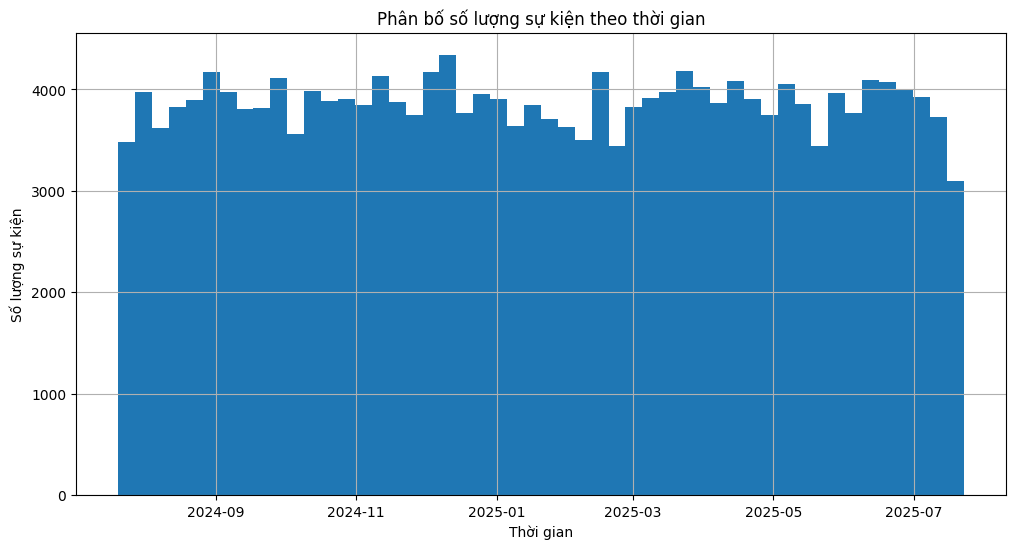

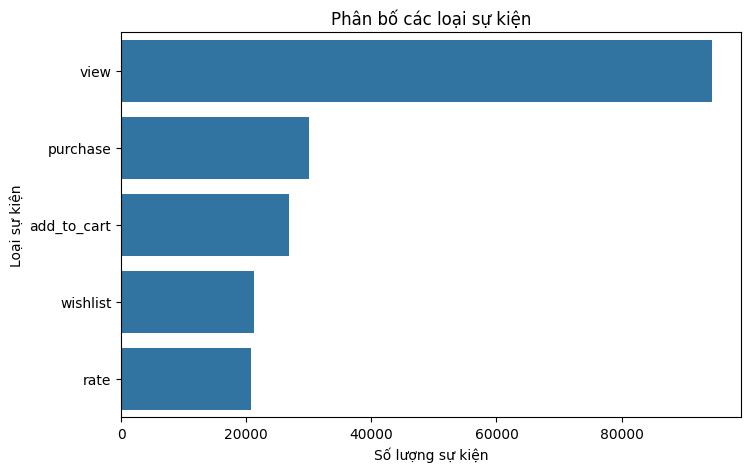

In [6]:
# Cell 3: T·∫£i d·ªØ li·ªáu v√† Chia t·∫≠p Train/Validation/Test

# 1. T·∫£i t·∫•t c·∫£ c√°c s·ª± ki·ªán ng∆∞·ªùi d√πng
print("--- B·∫Øt ƒë·∫ßu t·∫£i d·ªØ li·ªáu ng∆∞·ªùi d√πng t·ª´ c∆° s·ªü d·ªØ li·ªáu ---")
df_raw_events = load_all_user_events()

if df_raw_events.empty:
    logger.warning("Kh√¥ng t√¨m th·∫•y s·ª± ki·ªán ng∆∞·ªùi d√πng n√†o. D·ª´ng qu√° tr√¨nh.")
    # ƒê·ªÉ ƒë·∫£m b·∫£o c√°c cell sau kh√¥ng b·ªã l·ªói, c√≥ th·ªÉ tho√°t ho·∫∑c x·ª≠ l√Ω ƒë·∫∑c bi·ªát
    # raise SystemExit("Kh√¥ng c√≥ d·ªØ li·ªáu ƒë·ªÉ x·ª≠ l√Ω.")
else:
    print("\n--- 5 h√†ng ƒë·∫ßu ti√™n c·ªßa d·ªØ li·ªáu s·ª± ki·ªán th√¥ ---")
    print(df_raw_events.head())
    print(f"\nT·ªïng s·ªë s·ª± ki·ªán ƒë√£ t·∫£i: {len(df_raw_events)}")
    print(f"S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t: {df_raw_events['user_id'].nunique()}")
    print(f"S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t: {df_raw_events['product_id'].nunique()}")
    print(f"C√°c lo·∫°i s·ª± ki·ªán v√† s·ªë l∆∞·ª£ng: \n{df_raw_events['event_type'].value_counts()}")


# 2. Chia d·ªØ li·ªáu th√†nh t·∫≠p Train, Validation v√† Test d·ª±a tr√™n th·ªùi gian
print("\n--- B·∫Øt ƒë·∫ßu chia t·∫≠p d·ªØ li·ªáu th√†nh Train, Validation, Test ---")
df_train_raw, df_val_raw, df_test_raw = split_data_time_based(df_raw_events.copy(), train_ratio=0.6, val_ratio=0.2, test_ratio=0.2)

print("\n--- Th·ªëng k√™ sau khi chia t·∫≠p d·ªØ li·ªáu ---")
print(f"K√≠ch th∆∞·ªõc t·∫≠p Train: {len(df_train_raw)} s·ª± ki·ªán")
print(f"K√≠ch th∆∞·ªõc t·∫≠p Validation: {len(df_val_raw)} s·ª± ki·ªán")
print(f"K√≠ch th∆∞·ªõc t·∫≠p Test: {len(df_test_raw)} s·ª± ki·ªán")

print("\n--- 5 h√†ng ƒë·∫ßu ti√™n c·ªßa t·∫≠p Train ---")
print(df_train_raw.head())
print("\n--- 5 h√†ng ƒë·∫ßu ti√™n c·ªßa t·∫≠p Validation ---")
print(df_val_raw.head())
print("\n--- 5 h√†ng ƒë·∫ßu ti√™n c·ªßa t·∫≠p Test ---")
print(df_test_raw.head())

# --- TH√äM C√ÅC KI·ªÇM TRA M·ªöI V√ÄO ƒê√ÇY ---
print("\n--- KI·ªÇM TRA SAU KHI CHIA T·∫¨P ---")

# 1. S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t trong m·ªói t·∫≠p
print(f"Ng∆∞·ªùi d√πng duy nh·∫•t trong Train: {df_train_raw['user_id'].nunique()}")
print(f"Ng∆∞·ªùi d√πng duy nh·∫•t trong Validation: {df_val_raw['user_id'].nunique()}")
print(f"Ng∆∞·ªùi d√πng duy nh·∫•t trong Test: {df_test_raw['user_id'].nunique()}")

# 2. S·ªë l∆∞·ª£ng s·ª± ki·ªán 'purchase' trong t·∫≠p Train
train_purchases_count = df_train_raw[df_train_raw['event_type'] == 'purchase'].shape[0]
print(f"T·ªïng s·ªë s·ª± ki·ªán 'purchase' trong t·∫≠p Train: {train_purchases_count}")

# 3. S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng c√≥ s·ª± ki·ªán 'purchase' trong t·∫≠p Train
users_with_train_purchases = df_train_raw[df_train_raw['event_type'] == 'purchase']['user_id'].unique()
print(f"S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng c√≥ √≠t nh·∫•t 1 s·ª± ki·ªán 'purchase' trong Train: {len(users_with_train_purchases)}")

# 4. S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng c√≥ b·∫•t k·ª≥ t∆∞∆°ng t√°c n√†o trong t·∫≠p Validation
users_with_val_interactions = df_val_raw['user_id'].unique()
print(f"S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng c√≥ b·∫•t k·ª≥ t∆∞∆°ng t√°c n√†o trong Validation: {len(users_with_val_interactions)}")

# 5. S·ª± giao thoa gi·ªØa ng∆∞·ªùi d√πng c√≥ 'purchase' trong Train v√† ng∆∞·ªùi d√πng c√≥ t∆∞∆°ng t√°c trong Validation
common_users_for_eval = set(users_with_train_purchases) & set(users_with_val_interactions)
print(f"S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√° (mua trong Train & t∆∞∆°ng t√°c trong Val): {len(common_users_for_eval)}")

if len(common_users_for_eval) == 0:
    print("!!! C·∫¢NH B√ÅO: Kh√¥ng c√≥ ng∆∞·ªùi d√πng n√†o ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√° m√¥ h√¨nh. ƒêi·ªÅu n√†y s·∫Ω d·∫´n ƒë·∫øn metrics b·∫±ng 0.")
    print("V·∫•n ƒë·ªÅ c√≥ th·ªÉ do c√°ch chia d·ªØ li·ªáu theo th·ªùi gian ho·∫∑c d·ªØ li·ªáu qu√° th∆∞a th·ªõt.")
    # In ra m·ªôt s·ªë v√≠ d·ª• ƒë·ªÉ ki·ªÉm tra th·ªß c√¥ng (n·∫øu mu·ªën)
    # print("M·ªôt s·ªë user_id c√≥ purchase trong train:", list(users_with_train_purchases)[:5])
    # print("M·ªôt s·ªë user_id c√≥ t∆∞∆°ng t√°c trong validation:", list(users_with_val_interactions)[:5])

print("--- K·∫æT TH√öC KI·ªÇM TRA SAU KHI CHIA T·∫¨P ---\n")
# --- K·∫æT TH√öC C√ÅC KI·ªÇM TRA M·ªöI ---


# Tr·ª±c quan h√≥a ph√¢n b·ªë s·ª± ki·ªán theo th·ªùi gian (n·∫øu c√≥ ƒë·ªß d·ªØ li·ªáu)
plt.figure(figsize=(12, 6))
df_raw_events['created_at'].hist(bins=50)
plt.title('Ph√¢n b·ªë s·ªë l∆∞·ª£ng s·ª± ki·ªán theo th·ªùi gian')
plt.xlabel('Th·ªùi gian')
plt.ylabel('S·ªë l∆∞·ª£ng s·ª± ki·ªán')
plt.grid(True)
plt.show()

# Tr·ª±c quan h√≥a ph√¢n b·ªë lo·∫°i s·ª± ki·ªán
plt.figure(figsize=(8, 5))
sns.countplot(y='event_type', data=df_raw_events, order=df_raw_events['event_type'].value_counts().index)
plt.title('Ph√¢n b·ªë c√°c lo·∫°i s·ª± ki·ªán')
plt.xlabel('S·ªë l∆∞·ª£ng s·ª± ki·ªán')
plt.ylabel('Lo·∫°i s·ª± ki·ªán')
plt.show()

2025-07-25 09:59:24,643 - INFO - B·∫Øt ƒë·∫ßu t·∫£i d·ªØ li·ªáu thu·ªôc t√≠nh s·∫£n ph·∫©m...
2025-07-25 09:59:24,644 - INFO - ƒêang t·∫£i d·ªØ li·ªáu s·∫£n ph·∫©m ƒë·∫ßy ƒë·ªß t·ª´ c∆° s·ªü d·ªØ li·ªáu...
2025-07-25 09:59:24,664 - INFO - ƒê√£ t·∫£i v√† g·ªôp th√†nh c√¥ng 18 s·∫£n ph·∫©m g·ªëc.
2025-07-25 09:59:24,664 - INFO - ƒê√£ t·∫£i 18 s·∫£n ph·∫©m v·ªõi thu·ªôc t√≠nh.
2025-07-25 09:59:24,664 - INFO - Sample features_text:
2025-07-25 09:59:24,664 - INFO -   Product ID 56: 16 256gb 512gb 8gb amoled apple c√¥ng h√¨nh h·ªìng iphone m√†n m√†u ngh·ªá oled s·∫Øc tho·∫°i tr·∫Øng v√†ng x√°m ƒëen ƒëi·ªán ƒë·ªè ƒë·ªìng...
2025-07-25 09:59:24,664 - INFO -   Product ID 58: 256gb 2x 5g 8gb amodled c√¥ng dynamic galaxy h√¨nh m√†n m√†u ngh·ªá s25 samsung s·∫Øc tho·∫°i ultra ƒëen ƒëi·ªán...
2025-07-25 09:59:24,664 - INFO -   Product ID 59: 128gb 16e 256gb 8gb apple c√¥ng h√¨nh iphone m√†n m√†u ngh·ªá oled s·∫Øc tho·∫°i tr·∫Øng ƒëen ƒëi·ªán...
2025-07-25 09:59:24,664 - INFO -   Product ID 61: 16gb


--- B·∫Øt ƒë·∫ßu qu√° tr√¨nh t·ªëi ∆∞u h√≥a tr·ªçng s·ªë Implicit Feedback cho H·ªá th·ªëng Lai b·∫±ng Bayesian Optimization ---

--- ƒêang t·∫£i v√† x·ª≠ l√Ω d·ªØ li·ªáu thu·ªôc t√≠nh s·∫£n ph·∫©m cho Content-based Filtering ---


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

C:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\PC\.cache\huggingface\hub\models--vinai--phobert-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

2025-07-25 09:59:32,846 - WARNING - From C:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\tf_keras\src\losses.py:2976: The name tf.losses.sparse_softmax_cross_entropy is deprecated. Please use tf.compat.v1.losses.sparse_softmax_cross_entropy instead.



tf_model.h5:   0%|          | 0.00/740M [00:00<?, ?B/s]

2025-07-25 10:02:30,421 - WARNING - From C:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\tf_keras\src\backend.py:873: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers 

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0110
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0010
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 3 started. Evaluating function at random point.


2025-07-25 10:02:33,388 - INFO - DEBUGGING ALPHA: For p1=61 (Interactions: 4100), cold_start_threshold=1, dynamic_alpha used: 0.0071
2025-07-25 10:02:33,390 - INFO - DEBUGGING ALPHA: For p1=62 (Interactions: 4333), cold_start_threshold=1, dynamic_alpha used: 0.0071
2025-07-25 10:02:33,390 - INFO - DEBUGGING ALPHA: For p1=63 (Interactions: 4323), cold_start_threshold=1, dynamic_alpha used: 0.0071
2025-07-25 10:02:33,392 - INFO - Finished combining similarities for 19 products, now including detailed scores and dynamic alpha.
2025-07-25 10:02:33,392 - INFO - S·ªë l∆∞·ª£ng item c√≥ ƒë·ªô t∆∞∆°ng ƒë·ªìng lai: 19
2025-07-25 10:02:33,394 - INFO - S·ªë l∆∞·ª£ng item c√≥ ƒë·ªô t∆∞∆°ng ƒë·ªìng lai (sau khi l·ªçc final_hybrid_threshold): 19
2025-07-25 10:02:33,461 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:02:33,552 - INFO - DEBUG_OBJ: NDCG@15: 0.3544, Optimization Score: -0.3544
2025-07-25 10:02:33,552 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi t

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.3380
Function value obtained: -0.3544
Current minimum: -0.3544
Iteration No: 4 started. Evaluating function at random point.


2025-07-25 10:02:33,793 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:02:33,878 - INFO - DEBUG_OBJ: NDCG@15: 0.3673, Optimization Score: -0.3673
2025-07-25 10:02:33,880 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.146676289324798, 'add_to_cart': 0.6299702033681603, 'wishlist': 0.30409226157633396, 'purchase': 1.0}, alpha lai: 0.4504992519695431, cold_start_threshold: 1
2025-07-25 10:02:33,995 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:34,003 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:34,007 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:34,008 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:34,010 - INF

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.3279
Function value obtained: -0.3673
Current minimum: -0.3673
Iteration No: 5 started. Evaluating function at random point.


2025-07-25 10:02:34,136 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:02:34,215 - INFO - DEBUG_OBJ: NDCG@15: 0.3796, Optimization Score: -0.3796
2025-07-25 10:02:34,217 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.13854165025399162, 'add_to_cart': 0.2079831261101071, 'wishlist': 0.16926814768664472, 'purchase': 1.0}, alpha lai: 0.24102546602601177, cold_start_threshold: 14
2025-07-25 10:02:34,310 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:34,320 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:34,323 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:34,325 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:34,326 -

Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.3364
Function value obtained: -0.3796
Current minimum: -0.3796
Iteration No: 6 started. Evaluating function at random point.


2025-07-25 10:02:34,455 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:02:34,532 - INFO - DEBUG_OBJ: NDCG@15: 0.3709, Optimization Score: -0.3709
2025-07-25 10:02:34,536 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.11733646535077721, 'add_to_cart': 0.39553030378662046, 'wishlist': 0.1546708263364187, 'purchase': 1.0}, alpha lai: 0.7553614103176527, cold_start_threshold: 9
2025-07-25 10:02:34,632 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:34,641 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:34,645 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:34,647 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:34,647 - I

Iteration No: 6 ended. Evaluation done at random point.
Time taken: 0.3185
Function value obtained: -0.3709
Current minimum: -0.3796
Iteration No: 7 started. Evaluating function at random point.


2025-07-25 10:02:34,774 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:02:34,845 - INFO - DEBUG_OBJ: NDCG@15: 0.4026, Optimization Score: -0.4026
2025-07-25 10:02:34,847 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.10313132924555586, 'add_to_cart': 0.6211423872974993, 'wishlist': 0.23492624001092977, 'purchase': 1.0}, alpha lai: 0.39515023600181454, cold_start_threshold: 19
2025-07-25 10:02:34,941 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:34,951 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:34,954 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:34,956 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:34,958 -

Iteration No: 7 ended. Evaluation done at random point.
Time taken: 0.3117
Function value obtained: -0.4026
Current minimum: -0.4026
Iteration No: 8 started. Evaluating function at random point.


2025-07-25 10:02:35,083 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:02:35,162 - INFO - DEBUG_OBJ: NDCG@15: 0.3779, Optimization Score: -0.3779
2025-07-25 10:02:35,164 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.15704439744053997, 'add_to_cart': 0.46041713001291185, 'wishlist': 0.3883516073048049, 'purchase': 1.0}, alpha lai: 0.8445338486781516, cold_start_threshold: 15
2025-07-25 10:02:35,258 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:35,263 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:35,263 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:35,263 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:35,263 - 

Iteration No: 8 ended. Evaluation done at random point.
Time taken: 0.3167
Function value obtained: -0.3779
Current minimum: -0.4026
Iteration No: 9 started. Evaluating function at random point.


2025-07-25 10:02:35,403 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:02:35,479 - INFO - DEBUG_OBJ: NDCG@15: 0.4347, Optimization Score: -0.4347
2025-07-25 10:02:35,481 - WARNING - DEBUG_OBJ: Vi ph·∫°m r√†ng bu·ªôc th·ª© t·ª± v·ªõi tr·ªçng s·ªë ng·∫ßm: {'view': 0.19652553072641382, 'add_to_cart': 0.5035171238433424, 'wishlist': 0.18279975460676304, 'purchase': 1.0}. Tr·∫£ v·ªÅ 1.0.
2025-07-25 10:02:35,483 - WARNING - DEBUG_OBJ: Vi ph·∫°m r√†ng bu·ªôc th·ª© t·ª± v·ªõi tr·ªçng s·ªë ng·∫ßm: {'view': 0.139488151817557, 'add_to_cart': 0.34674408735901907, 'wishlist': 0.10422394681452535, 'purchase': 1.0}. Tr·∫£ v·ªÅ 1.0.
2025-07-25 10:02:35,484 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.19263008785133492, 'add_to_cart': 0.5255385127509722, 'wishlist': 0.37448790266313436, 'purchase': 1.0}, alpha lai: 0.8500385777897995, cold_start_threshold: 10
2025-07-25 10:02:35,579 - INFO - Assigned implicit scores considering frequen

Iteration No: 9 ended. Evaluation done at random point.
Time taken: 0.3186
Function value obtained: -0.4347
Current minimum: -0.4347
Iteration No: 10 started. Evaluating function at random point.
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 0.0010
Function value obtained: 1.0000
Current minimum: -0.4347
Iteration No: 11 started. Evaluating function at random point.
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 0.0009
Function value obtained: 1.0000
Current minimum: -0.4347
Iteration No: 12 started. Evaluating function at random point.


2025-07-25 10:02:35,898 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:02:35,976 - INFO - DEBUG_OBJ: NDCG@15: 0.4447, Optimization Score: -0.4447
2025-07-25 10:02:35,979 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.16688412526636076, 'add_to_cart': 0.5329611783087483, 'wishlist': 0.2773893363123182, 'purchase': 1.0}, alpha lai: 0.2747217929900642, cold_start_threshold: 12
2025-07-25 10:02:36,074 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:36,082 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:36,082 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:36,082 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:36,082 - I

Iteration No: 12 ended. Evaluation done at random point.
Time taken: 0.4942
Function value obtained: -0.4447
Current minimum: -0.4447
Iteration No: 13 started. Evaluating function at random point.


2025-07-25 10:02:36,215 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:02:36,293 - INFO - DEBUG_OBJ: NDCG@15: 0.3734, Optimization Score: -0.3734
2025-07-25 10:02:36,296 - WARNING - DEBUG_OBJ: Vi ph·∫°m r√†ng bu·ªôc th·ª© t·ª± v·ªõi tr·ªçng s·ªë ng·∫ßm: {'view': 0.1848913824266084, 'add_to_cart': 0.5608647605824366, 'wishlist': 0.17079547592468675, 'purchase': 1.0}. Tr·∫£ v·ªÅ 1.0.
2025-07-25 10:02:36,298 - WARNING - DEBUG_OBJ: Vi ph·∫°m r√†ng bu·ªôc th·ª© t·ª± v·ªõi tr·ªçng s·ªë ng·∫ßm: {'view': 0.14393365018657703, 'add_to_cart': 0.3008596011676981, 'wishlist': 0.36872907870205596, 'purchase': 1.0}. Tr·∫£ v·ªÅ 1.0.
2025-07-25 10:02:36,299 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.16044173792778174, 'add_to_cart': 0.4699205456508366, 'wishlist': 0.16091836742043086, 'purchase': 1.0}, alpha lai: 0.9428535705579812, cold_start_threshold: 12
2025-07-25 10:02:36,394 - INFO - Assigned implicit scores considering frequen

Iteration No: 13 ended. Evaluation done at random point.
Time taken: 0.3177
Function value obtained: -0.3734
Current minimum: -0.4447
Iteration No: 14 started. Evaluating function at random point.
Iteration No: 14 ended. Evaluation done at random point.
Time taken: 0.0015
Function value obtained: 1.0000
Current minimum: -0.4447
Iteration No: 15 started. Evaluating function at random point.
Iteration No: 15 ended. Evaluation done at random point.
Time taken: 0.0011
Function value obtained: 1.0000
Current minimum: -0.4447
Iteration No: 16 started. Evaluating function at random point.


2025-07-25 10:02:36,535 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:02:36,581 - INFO - DEBUG_OBJ: NDCG@15: 0.3099, Optimization Score: -0.3099
2025-07-25 10:02:36,581 - WARNING - DEBUG_OBJ: Vi ph·∫°m r√†ng bu·ªôc th·ª© t·ª± v·ªõi tr·ªçng s·ªë ng·∫ßm: {'view': 0.16243540481337934, 'add_to_cart': 0.347816842918857, 'wishlist': 0.1316482779490812, 'purchase': 1.0}. Tr·∫£ v·ªÅ 1.0.
2025-07-25 10:02:36,595 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.1324345021005274, 'add_to_cart': 0.2610439773503367, 'wishlist': 0.2068893514230925, 'purchase': 1.0}, alpha lai: 0.9068284415457543, cold_start_threshold: 6
2025-07-25 10:02:36,692 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:36,697 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:36,697 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·

Iteration No: 16 ended. Evaluation done at random point.
Time taken: 0.2835
Function value obtained: -0.3099
Current minimum: -0.4447
Iteration No: 17 started. Evaluating function at random point.
Iteration No: 17 ended. Evaluation done at random point.
Time taken: 0.0138
Function value obtained: 1.0000
Current minimum: -0.4447
Iteration No: 18 started. Evaluating function at random point.


2025-07-25 10:02:36,854 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:02:36,935 - INFO - DEBUG_OBJ: NDCG@15: 0.4455, Optimization Score: -0.4455
2025-07-25 10:02:36,937 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.13525688563341692, 'add_to_cart': 0.35239062907901453, 'wishlist': 0.14939675594288254, 'purchase': 1.0}, alpha lai: 0.5340894193754421, cold_start_threshold: 10
2025-07-25 10:02:37,032 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:37,037 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:37,045 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:37,046 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:37,048 -

Iteration No: 18 ended. Evaluation done at random point.
Time taken: 0.3404
Function value obtained: -0.4455
Current minimum: -0.4455
Iteration No: 19 started. Evaluating function at random point.


2025-07-25 10:02:37,176 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:02:37,253 - INFO - DEBUG_OBJ: NDCG@15: 0.3812, Optimization Score: -0.3812
2025-07-25 10:02:37,256 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.12441255222477743, 'add_to_cart': 0.2841455210864653, 'wishlist': 0.16562926587192112, 'purchase': 1.0}, alpha lai: 0.5581020020173413, cold_start_threshold: 9
2025-07-25 10:02:37,342 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:37,361 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:37,361 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:37,361 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:37,361 - I

Iteration No: 19 ended. Evaluation done at random point.
Time taken: 0.3187
Function value obtained: -0.3812
Current minimum: -0.4455
Iteration No: 20 started. Evaluating function at random point.


2025-07-25 10:02:37,479 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:02:37,560 - INFO - DEBUG_OBJ: NDCG@15: 0.3821, Optimization Score: -0.3821
2025-07-25 10:02:37,999 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.1260255044022785, 'add_to_cart': 0.3540043986162599, 'wishlist': 0.1572518991370537, 'purchase': 1.0}, alpha lai: 0.6322149347108594, cold_start_threshold: 7
2025-07-25 10:02:38,094 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:38,095 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:38,095 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:38,095 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:38,095 - INF

Iteration No: 20 ended. Evaluation done at random point.
Time taken: 0.7441
Function value obtained: -0.3821
Current minimum: -0.4455
Iteration No: 21 started. Searching for the next optimal point.


2025-07-25 10:02:38,237 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:02:38,315 - INFO - DEBUG_OBJ: NDCG@15: 0.3947, Optimization Score: -0.3947
2025-07-25 10:02:38,918 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.16229449346661054, 'add_to_cart': 0.7, 'wishlist': 0.4, 'purchase': 1.0}, alpha lai: 0.0, cold_start_threshold: 20
2025-07-25 10:02:39,012 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:39,021 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:39,021 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:39,028 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:39,029 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 d√≤ng,

Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.9176
Function value obtained: -0.3947
Current minimum: -0.4455
Iteration No: 22 started. Searching for the next optimal point.


2025-07-25 10:02:39,145 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:02:39,235 - INFO - DEBUG_OBJ: NDCG@15: 0.3494, Optimization Score: -0.3494
2025-07-25 10:02:39,809 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.13749933020810487, 'add_to_cart': 0.4271681228317763, 'wishlist': 0.17349354714061976, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 20
2025-07-25 10:02:39,910 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:39,925 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:39,929 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:39,930 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:39,931 - INFO - DF_TRAIN

Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.8912
Function value obtained: -0.3494
Current minimum: -0.4455
Iteration No: 23 started. Searching for the next optimal point.


2025-07-25 10:02:40,060 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:02:40,128 - INFO - DEBUG_OBJ: NDCG@15: 0.4416, Optimization Score: -0.4416
2025-07-25 10:02:40,646 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.16102636429909972, 'add_to_cart': 0.4971464418499577, 'wishlist': 0.391236785358704, 'purchase': 1.0}, alpha lai: 0.8864023391347149, cold_start_threshold: 15
2025-07-25 10:02:40,740 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:40,747 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:40,747 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:40,747 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:40,747 - IN

Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.8361
Function value obtained: -0.4416
Current minimum: -0.4455
Iteration No: 24 started. Searching for the next optimal point.


2025-07-25 10:02:40,883 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:02:40,951 - INFO - DEBUG_OBJ: NDCG@15: 0.3930, Optimization Score: -0.3930
2025-07-25 10:02:41,398 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.2, 'add_to_cart': 0.7, 'wishlist': 0.31434214608311295, 'purchase': 1.0}, alpha lai: 0.6318938574565875, cold_start_threshold: 19
2025-07-25 10:02:41,494 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:41,501 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:41,501 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:41,501 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:41,501 - INFO - DF_TRAIN_WEIGHTED cho CF

Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.7522
Function value obtained: -0.3930
Current minimum: -0.4455
Iteration No: 25 started. Searching for the next optimal point.


2025-07-25 10:02:41,654 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:02:41,733 - INFO - DEBUG_OBJ: NDCG@15: 0.3951, Optimization Score: -0.3951
2025-07-25 10:02:42,193 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.1741434201803066, 'add_to_cart': 0.6298840699349733, 'wishlist': 0.28778042417420757, 'purchase': 1.0}, alpha lai: 0.2957351761037885, cold_start_threshold: 8
2025-07-25 10:02:42,293 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:42,307 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:42,311 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:42,312 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:42,314 - IN

Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.7950
Function value obtained: -0.3951
Current minimum: -0.4455
Iteration No: 26 started. Searching for the next optimal point.


2025-07-25 10:02:42,440 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:02:42,510 - INFO - DEBUG_OBJ: NDCG@15: 0.3747, Optimization Score: -0.3747
2025-07-25 10:02:42,996 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.18462829694618937, 'add_to_cart': 0.5683685092391548, 'wishlist': 0.3804633313783967, 'purchase': 1.0}, alpha lai: 0.8602388752548693, cold_start_threshold: 12
2025-07-25 10:02:43,092 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:43,100 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:43,100 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:43,100 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:43,100 - I

Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.8024
Function value obtained: -0.3747
Current minimum: -0.4455
Iteration No: 27 started. Searching for the next optimal point.


2025-07-25 10:02:43,228 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:02:43,309 - INFO - DEBUG_OBJ: NDCG@15: 0.4467, Optimization Score: -0.4467
2025-07-25 10:02:43,822 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.14121516730208766, 'add_to_cart': 0.4571640908336031, 'wishlist': 0.16757024435949092, 'purchase': 1.0}, alpha lai: 0.9957649403570668, cold_start_threshold: 8
2025-07-25 10:02:43,918 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:43,934 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:43,934 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:43,934 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:43,934 - I

Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.8257
Function value obtained: -0.4467
Current minimum: -0.4467
Iteration No: 28 started. Searching for the next optimal point.


2025-07-25 10:02:44,062 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:02:44,112 - INFO - DEBUG_OBJ: NDCG@15: 0.3274, Optimization Score: -0.3274
2025-07-25 10:02:44,662 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.14188423701326627, 'add_to_cart': 0.6877074518229507, 'wishlist': 0.2672706600100814, 'purchase': 1.0}, alpha lai: 0.9712284258295844, cold_start_threshold: 20
2025-07-25 10:02:44,755 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:44,766 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:44,769 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:44,770 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:44,772 - I

Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.8395
Function value obtained: -0.3274
Current minimum: -0.4467
Iteration No: 29 started. Searching for the next optimal point.


2025-07-25 10:02:44,896 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:02:44,962 - INFO - DEBUG_OBJ: NDCG@15: 0.4351, Optimization Score: -0.4351
2025-07-25 10:02:45,550 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.14994497570318055, 'add_to_cart': 0.7, 'wishlist': 0.3450349507738089, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 17
2025-07-25 10:02:45,644 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:45,654 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:45,657 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:45,658 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:45,659 - INFO - DF_TRAIN_WEIGHTED cho CF

Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.8879
Function value obtained: -0.4351
Current minimum: -0.4467
Iteration No: 30 started. Searching for the next optimal point.


2025-07-25 10:02:45,785 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:02:45,864 - INFO - DEBUG_OBJ: NDCG@15: 0.4426, Optimization Score: -0.4426
2025-07-25 10:02:46,474 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.13733694909707367, 'add_to_cart': 0.32525796940505625, 'wishlist': 0.19277348906085343, 'purchase': 1.0}, alpha lai: 0.8937805770092073, cold_start_threshold: 20
2025-07-25 10:02:46,571 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:46,581 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:46,583 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:46,585 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:46,587 -

Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.9240
Function value obtained: -0.4426
Current minimum: -0.4467
Iteration No: 31 started. Searching for the next optimal point.


2025-07-25 10:02:46,715 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:02:46,796 - INFO - DEBUG_OBJ: NDCG@15: 0.4452, Optimization Score: -0.4452
2025-07-25 10:02:47,280 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.1898701435863378, 'add_to_cart': 0.5822283486426719, 'wishlist': 0.37679350841468007, 'purchase': 1.0}, alpha lai: 0.8904136171365602, cold_start_threshold: 11
2025-07-25 10:02:47,373 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:47,383 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:47,386 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:47,387 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:47,390 - I

Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 0.8061
Function value obtained: -0.4452
Current minimum: -0.4467
Iteration No: 32 started. Searching for the next optimal point.


2025-07-25 10:02:47,516 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:02:47,596 - INFO - DEBUG_OBJ: NDCG@15: 0.4449, Optimization Score: -0.4449
2025-07-25 10:02:48,138 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.1270244114951713, 'add_to_cart': 0.3686818656691022, 'wishlist': 0.15392931438502572, 'purchase': 1.0}, alpha lai: 0.5829327198477708, cold_start_threshold: 20
2025-07-25 10:02:48,217 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:48,233 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:48,233 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:48,233 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:48,233 - I

Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 0.8421
Function value obtained: -0.4449
Current minimum: -0.4467
Iteration No: 33 started. Searching for the next optimal point.


2025-07-25 10:02:48,536 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:02:48,614 - INFO - DEBUG_OBJ: NDCG@15: 0.3820, Optimization Score: -0.3820
2025-07-25 10:02:49,126 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.14592058191088605, 'add_to_cart': 0.6937351572931969, 'wishlist': 0.2906952810312504, 'purchase': 1.0}, alpha lai: 0.6433522640645872, cold_start_threshold: 12
2025-07-25 10:02:49,220 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:49,231 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:49,234 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:49,237 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:49,238 - I

Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 0.9876
Function value obtained: -0.3820
Current minimum: -0.4467
Iteration No: 34 started. Searching for the next optimal point.


2025-07-25 10:02:49,365 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:02:49,427 - INFO - DEBUG_OBJ: NDCG@15: 0.4008, Optimization Score: -0.4008
2025-07-25 10:02:50,075 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.13710348325323743, 'add_to_cart': 0.4093907664633415, 'wishlist': 0.17606266501186715, 'purchase': 1.0}, alpha lai: 0.9992262469645307, cold_start_threshold: 16
2025-07-25 10:02:50,171 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:50,186 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:50,186 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:50,186 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:50,186 - 

Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 0.9494
Function value obtained: -0.4008
Current minimum: -0.4467
Iteration No: 35 started. Searching for the next optimal point.


2025-07-25 10:02:50,314 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:02:50,403 - INFO - DEBUG_OBJ: NDCG@15: 0.4417, Optimization Score: -0.4417
2025-07-25 10:02:51,122 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.1, 'add_to_cart': 0.5149367356962962, 'wishlist': 0.2086513994057539, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 20
2025-07-25 10:02:51,218 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:51,234 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:51,234 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:51,234 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:51,234 - INFO - DF_TRAIN_WEIGHTED cho CF:

Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 1.0471
Function value obtained: -0.4417
Current minimum: -0.4467
Iteration No: 36 started. Searching for the next optimal point.


2025-07-25 10:02:51,361 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:02:51,441 - INFO - DEBUG_OBJ: NDCG@15: 0.4386, Optimization Score: -0.4386
2025-07-25 10:02:52,139 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.2, 'add_to_cart': 0.7, 'wishlist': 0.36987474689464894, 'purchase': 1.0}, alpha lai: 0.2824381116788566, cold_start_threshold: 5
2025-07-25 10:02:52,237 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:52,249 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:52,249 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:52,249 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:52,249 - INFO - DF_TRAIN_WEIGHTED cho CF:

Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 1.0166
Function value obtained: -0.4386
Current minimum: -0.4467
Iteration No: 37 started. Searching for the next optimal point.


2025-07-25 10:02:52,384 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:02:52,470 - INFO - DEBUG_OBJ: NDCG@15: 0.3741, Optimization Score: -0.3741
2025-07-25 10:02:53,056 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.13664368185834044, 'add_to_cart': 0.3793844442993273, 'wishlist': 0.18124740884488147, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 20
2025-07-25 10:02:53,154 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:53,167 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:53,167 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:53,167 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:53,167 - INFO - DF_TRAIN

Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 0.9167
Function value obtained: -0.3741
Current minimum: -0.4467
Iteration No: 38 started. Searching for the next optimal point.


2025-07-25 10:02:53,295 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:02:53,374 - INFO - DEBUG_OBJ: NDCG@15: 0.4419, Optimization Score: -0.4419
2025-07-25 10:02:54,058 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.12816240095629786, 'add_to_cart': 0.4199370956307746, 'wishlist': 0.1753793796224733, 'purchase': 1.0}, alpha lai: 0.9705853580609798, cold_start_threshold: 20
2025-07-25 10:02:54,154 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:54,170 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:54,170 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:54,170 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:54,170 - I

Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 1.0025
Function value obtained: -0.4419
Current minimum: -0.4467
Iteration No: 39 started. Searching for the next optimal point.


2025-07-25 10:02:54,303 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:02:54,344 - INFO - DEBUG_OBJ: NDCG@15: 0.2703, Optimization Score: -0.2703
2025-07-25 10:02:54,978 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.1, 'add_to_cart': 0.7, 'wishlist': 0.1473771387198701, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 20
2025-07-25 10:02:55,063 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:55,078 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:55,078 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:55,078 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:55,078 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 d√≤ng, 

Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 0.9093
Function value obtained: -0.2703
Current minimum: -0.4467
Iteration No: 40 started. Searching for the next optimal point.


2025-07-25 10:02:55,206 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:02:55,286 - INFO - DEBUG_OBJ: NDCG@15: 0.4353, Optimization Score: -0.4353
2025-07-25 10:02:55,925 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.14409560672259425, 'add_to_cart': 0.4202446324887713, 'wishlist': 0.1695534948488398, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 20
2025-07-25 10:02:56,022 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:56,030 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:56,032 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:56,034 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:56,036 - INFO - DF_TRAIN_

Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 0.9579
Function value obtained: -0.4353
Current minimum: -0.4467
Iteration No: 41 started. Searching for the next optimal point.


2025-07-25 10:02:56,163 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:02:56,242 - INFO - DEBUG_OBJ: NDCG@15: 0.4418, Optimization Score: -0.4418
2025-07-25 10:02:56,825 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.14460165058915678, 'add_to_cart': 0.41789024605207065, 'wishlist': 0.17192726168729883, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 17
2025-07-25 10:02:56,920 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:56,936 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:56,936 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:56,936 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:56,936 - INFO - DF_TRAI

Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 0.8994
Function value obtained: -0.4418
Current minimum: -0.4467
Iteration No: 42 started. Searching for the next optimal point.


2025-07-25 10:02:57,066 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:02:57,141 - INFO - DEBUG_OBJ: NDCG@15: 0.4418, Optimization Score: -0.4418
2025-07-25 10:02:57,688 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.158275530712382, 'add_to_cart': 0.4797708144265943, 'wishlist': 0.3895879040437582, 'purchase': 1.0}, alpha lai: 0.8890901123349847, cold_start_threshold: 6
2025-07-25 10:02:57,773 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:57,789 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:57,789 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:57,789 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:57,789 - INFO

Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 0.8635
Function value obtained: -0.4418
Current minimum: -0.4467
Iteration No: 43 started. Searching for the next optimal point.


2025-07-25 10:02:57,916 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:02:58,001 - INFO - DEBUG_OBJ: NDCG@15: 0.4461, Optimization Score: -0.4461
2025-07-25 10:02:58,582 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.11276466084198969, 'add_to_cart': 0.41856166574071, 'wishlist': 0.1469214474519172, 'purchase': 1.0}, alpha lai: 0.8437107472180714, cold_start_threshold: 7
2025-07-25 10:02:58,677 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:58,686 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:58,688 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:58,691 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:58,693 - INFO

Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 0.8939
Function value obtained: -0.4461
Current minimum: -0.4467
Iteration No: 44 started. Searching for the next optimal point.


2025-07-25 10:02:58,809 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:02:58,889 - INFO - DEBUG_OBJ: NDCG@15: 0.4457, Optimization Score: -0.4457
2025-07-25 10:02:59,429 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.1, 'add_to_cart': 0.7, 'wishlist': 0.4, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 2
2025-07-25 10:02:59,524 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:59,540 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:59,540 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:59,540 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:59,540 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 d√≤ng, min_score=0.00, 

Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 0.8473
Function value obtained: -0.4457
Current minimum: -0.4467
Iteration No: 45 started. Searching for the next optimal point.


2025-07-25 10:02:59,670 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:02:59,742 - INFO - DEBUG_OBJ: NDCG@15: 0.4376, Optimization Score: -0.4376
2025-07-25 10:03:00,378 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.13421725208091645, 'add_to_cart': 0.6064909266789711, 'wishlist': 0.4, 'purchase': 1.0}, alpha lai: 0.506030235440915, cold_start_threshold: 1
2025-07-25 10:03:00,478 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:00,478 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:00,494 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:00,494 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:00,494 - INFO - DF_TRAIN_WE

Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 0.9488
Function value obtained: -0.4376
Current minimum: -0.4467
Iteration No: 46 started. Searching for the next optimal point.


2025-07-25 10:03:00,621 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:03:00,703 - INFO - DEBUG_OBJ: NDCG@15: 0.3811, Optimization Score: -0.3811
2025-07-25 10:03:01,327 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.1430953735304573, 'add_to_cart': 0.3208101881495419, 'wishlist': 0.19368581686214725, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 20
2025-07-25 10:03:01,413 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:01,431 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:01,433 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:01,435 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:01,437 - INFO - DF_TRAIN_

Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 0.9475
Function value obtained: -0.3811
Current minimum: -0.4467
Iteration No: 47 started. Searching for the next optimal point.


2025-07-25 10:03:01,562 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:03:01,640 - INFO - DEBUG_OBJ: NDCG@15: 0.4447, Optimization Score: -0.4447
2025-07-25 10:03:02,371 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.12632690019985862, 'add_to_cart': 0.6245021701973534, 'wishlist': 0.16813152868908043, 'purchase': 1.0}, alpha lai: 0.9715915350338596, cold_start_threshold: 18
2025-07-25 10:03:02,467 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:02,476 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:02,478 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:02,479 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:02,481 - 

Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 1.0440
Function value obtained: -0.4447
Current minimum: -0.4467
Iteration No: 48 started. Searching for the next optimal point.


2025-07-25 10:03:02,604 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:03:02,681 - INFO - DEBUG_OBJ: NDCG@15: 0.4329, Optimization Score: -0.4329
2025-07-25 10:03:03,227 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.1957856531913898, 'add_to_cart': 0.6315422229443958, 'wishlist': 0.270636027251978, 'purchase': 1.0}, alpha lai: 0.29372093287286055, cold_start_threshold: 3
2025-07-25 10:03:03,323 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:03,333 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:03,334 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:03,336 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:03,337 - INF

Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 0.8559
Function value obtained: -0.4329
Current minimum: -0.4467
Iteration No: 49 started. Searching for the next optimal point.


2025-07-25 10:03:03,463 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:03:03,541 - INFO - DEBUG_OBJ: NDCG@15: 0.3743, Optimization Score: -0.3743
2025-07-25 10:03:04,083 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.12511506007151665, 'add_to_cart': 0.22768138913191668, 'wishlist': 0.2081028694566194, 'purchase': 1.0}, alpha lai: 0.23713529502117225, cold_start_threshold: 13
2025-07-25 10:03:04,180 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:04,189 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:04,192 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:04,193 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:04,195 -

Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 0.8578
Function value obtained: -0.3743
Current minimum: -0.4467
Iteration No: 50 started. Searching for the next optimal point.


2025-07-25 10:03:04,332 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:03:04,408 - INFO - DEBUG_OBJ: NDCG@15: 0.3711, Optimization Score: -0.3711
2025-07-25 10:03:05,013 - WARNING - DEBUG_OBJ: Vi ph·∫°m r√†ng bu·ªôc th·ª© t·ª± v·ªõi tr·ªçng s·ªë ng·∫ßm: {'view': 0.19060301059135387, 'add_to_cart': 0.26696889352196135, 'wishlist': 0.28928833808299964, 'purchase': 1.0}. Tr·∫£ v·ªÅ 1.0.


Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 0.9294
Function value obtained: -0.3711
Current minimum: -0.4467
Iteration No: 51 started. Searching for the next optimal point.


2025-07-25 10:03:05,679 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.1, 'add_to_cart': 0.7, 'wishlist': 0.31776405213570086, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 19
2025-07-25 10:03:05,761 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:05,776 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:05,776 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:05,776 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:05,776 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 d√≤ng, min_score=0.00, max_score=1.00
2025-07-25 10:03:05,776 - INFO - ƒêang t√≠nh to√°n ma tr·∫≠n ƒë·ªô t∆∞∆°ng ƒë·ªìng item-item th∆∞a th·ªõt s·ª≠ d·ª•ng ƒëi·ªÉm ng·∫ßm...
2025-07-25 10:03:05,792 - IN

Iteration No: 51 ended. Search finished for the next optimal point.
Time taken: 0.6662
Function value obtained: 1.0000
Current minimum: -0.4467
Iteration No: 52 started. Searching for the next optimal point.


2025-07-25 10:03:05,903 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:03:05,989 - INFO - DEBUG_OBJ: NDCG@15: 0.4385, Optimization Score: -0.4385
2025-07-25 10:03:06,628 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.13103898950283158, 'add_to_cart': 0.21102891055168557, 'wishlist': 0.18335518745205384, 'purchase': 1.0}, alpha lai: 0.32058283820415995, cold_start_threshold: 11
2025-07-25 10:03:06,727 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:06,730 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:06,730 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:06,730 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:06,730 

Iteration No: 52 ended. Search finished for the next optimal point.
Time taken: 0.9495
Function value obtained: -0.4385
Current minimum: -0.4467
Iteration No: 53 started. Searching for the next optimal point.


2025-07-25 10:03:06,866 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:03:06,944 - INFO - DEBUG_OBJ: NDCG@15: 0.3753, Optimization Score: -0.3753
2025-07-25 10:03:07,580 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.1208988631786828, 'add_to_cart': 0.6464576305532335, 'wishlist': 0.1694220095776317, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 20
2025-07-25 10:03:07,697 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:07,710 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:07,712 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:07,712 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:07,718 - INFO - DF_TRAIN_W

Iteration No: 53 ended. Search finished for the next optimal point.
Time taken: 0.9513
Function value obtained: -0.3753
Current minimum: -0.4467
Iteration No: 54 started. Searching for the next optimal point.


2025-07-25 10:03:07,761 - INFO - DEBUGGING ALPHA: For p1=74 (Interactions: 0), cold_start_threshold=20, dynamic_alpha used: 0.1000
2025-07-25 10:03:07,761 - INFO - DEBUGGING ALPHA: For p1=56 (Interactions: 23848), cold_start_threshold=20, dynamic_alpha used: 1.0000
2025-07-25 10:03:07,761 - INFO - DEBUGGING ALPHA: For p1=57 (Interactions: 4331), cold_start_threshold=20, dynamic_alpha used: 1.0000
2025-07-25 10:03:07,761 - INFO - DEBUGGING ALPHA: For p1=58 (Interactions: 4092), cold_start_threshold=20, dynamic_alpha used: 1.0000
2025-07-25 10:03:07,761 - INFO - DEBUGGING ALPHA: For p1=59 (Interactions: 7451), cold_start_threshold=20, dynamic_alpha used: 1.0000
2025-07-25 10:03:07,761 - INFO - DEBUGGING ALPHA: For p1=60 (Interactions: 7321), cold_start_threshold=20, dynamic_alpha used: 1.0000
2025-07-25 10:03:07,761 - INFO - DEBUGGING ALPHA: For p1=61 (Interactions: 4100), cold_start_threshold=20, dynamic_alpha used: 1.0000
2025-07-25 10:03:07,761 - INFO - DEBUGGING ALPHA: For p1=62 (Int

Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 0.9301
Function value obtained: -0.4343
Current minimum: -0.4467
Iteration No: 55 started. Searching for the next optimal point.


2025-07-25 10:03:09,208 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.1439682426133459, 'add_to_cart': 0.5227821067342973, 'wishlist': 0.2305819976499423, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 20
2025-07-25 10:03:09,304 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:09,304 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:09,320 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:09,320 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:09,320 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 d√≤ng, min_score=0.00, max_score=1.00
2025-07-25 10:03:09,320 - INFO - ƒêang t√≠nh to√°n ma tr·∫≠n ƒë·ªô t∆∞∆°ng ƒë·ªìng item-item th∆∞a th·ªõt s·ª≠ d·ª•ng ƒëi·ªÉm ng·∫ßm...

Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 0.6985
Function value obtained: 1.0000
Current minimum: -0.4467
Iteration No: 56 started. Searching for the next optimal point.


2025-07-25 10:03:09,446 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:03:09,527 - INFO - DEBUG_OBJ: NDCG@15: 0.4445, Optimization Score: -0.4445
2025-07-25 10:03:10,137 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.1, 'add_to_cart': 0.429550709822515, 'wishlist': 0.18791764089200808, 'purchase': 1.0}, alpha lai: 0.0, cold_start_threshold: 11
2025-07-25 10:03:10,244 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:10,248 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:10,248 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:10,248 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:10,248 - INFO - DF_TRAIN_WEIGHTED cho CF:

Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 0.9290
Function value obtained: -0.4445
Current minimum: -0.4467
Iteration No: 57 started. Searching for the next optimal point.


2025-07-25 10:03:10,390 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:03:10,470 - INFO - DEBUG_OBJ: NDCG@15: 0.3494, Optimization Score: -0.3494
2025-07-25 10:03:11,081 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.13945939258577486, 'add_to_cart': 0.6645957808547815, 'wishlist': 0.34574971201558924, 'purchase': 1.0}, alpha lai: 0.9951549936224016, cold_start_threshold: 18
2025-07-25 10:03:11,176 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:11,192 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:11,192 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:11,192 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:11,192 - 

Iteration No: 57 ended. Search finished for the next optimal point.
Time taken: 0.9438
Function value obtained: -0.3494
Current minimum: -0.4467
Iteration No: 58 started. Searching for the next optimal point.


2025-07-25 10:03:11,320 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:03:11,400 - INFO - DEBUG_OBJ: NDCG@15: 0.4422, Optimization Score: -0.4422
2025-07-25 10:03:12,027 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.1, 'add_to_cart': 0.5847713014575076, 'wishlist': 0.1527616558214902, 'purchase': 1.0}, alpha lai: 0.7351395023442145, cold_start_threshold: 5
2025-07-25 10:03:12,130 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:12,139 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:12,139 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:12,139 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:12,139 - INFO - DF_TRAIN_WE

Iteration No: 58 ended. Search finished for the next optimal point.
Time taken: 0.9459
Function value obtained: -0.4422
Current minimum: -0.4467
Iteration No: 59 started. Searching for the next optimal point.


2025-07-25 10:03:12,264 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:03:12,343 - INFO - DEBUG_OBJ: NDCG@15: 0.4400, Optimization Score: -0.4400
2025-07-25 10:03:13,067 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.12422768166693428, 'add_to_cart': 0.5673543582873912, 'wishlist': 0.2347699795208021, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 20
2025-07-25 10:03:13,163 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:13,179 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:13,179 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:13,179 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:13,179 - INFO - DF_TRAIN_

Iteration No: 59 ended. Search finished for the next optimal point.
Time taken: 1.0402
Function value obtained: -0.4400
Current minimum: -0.4467
Iteration No: 60 started. Searching for the next optimal point.


2025-07-25 10:03:13,307 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:03:13,392 - INFO - DEBUG_OBJ: NDCG@15: 0.4378, Optimization Score: -0.4378
2025-07-25 10:03:13,956 - WARNING - DEBUG_OBJ: Vi ph·∫°m r√†ng bu·ªôc th·ª© t·ª± v·ªõi tr·ªçng s·ªë ng·∫ßm: {'view': 0.121322320409332, 'add_to_cart': 0.416756431335085, 'wishlist': 0.10912511588768102, 'purchase': 1.0}. Tr·∫£ v·ªÅ 1.0.


Iteration No: 60 ended. Search finished for the next optimal point.
Time taken: 0.8887
Function value obtained: -0.4378
Current minimum: -0.4467
Iteration No: 61 started. Searching for the next optimal point.


2025-07-25 10:03:14,682 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.1, 'add_to_cart': 0.7, 'wishlist': 0.3741481654328428, 'purchase': 1.0}, alpha lai: 0.0, cold_start_threshold: 12
2025-07-25 10:03:14,779 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:14,789 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:14,791 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:14,793 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:14,794 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 d√≤ng, min_score=0.00, max_score=1.00
2025-07-25 10:03:14,795 - INFO - ƒêang t√≠nh to√°n ma tr·∫≠n ƒë·ªô t∆∞∆°ng ƒë·ªìng item-item th∆∞a th·ªõt s·ª≠ d·ª•ng ƒëi·ªÉm ng·∫ßm...
2025-07-25 10:03:14,812 - INF

Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 0.7266
Function value obtained: 1.0000
Current minimum: -0.4467
Iteration No: 62 started. Searching for the next optimal point.


2025-07-25 10:03:14,930 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:03:15,014 - INFO - DEBUG_OBJ: NDCG@15: 0.3494, Optimization Score: -0.3494
2025-07-25 10:03:15,832 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.14377069910143322, 'add_to_cart': 0.37285085407866014, 'wishlist': 0.3308490833064016, 'purchase': 1.0}, alpha lai: 0.29875311368366947, cold_start_threshold: 10
2025-07-25 10:03:15,931 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:15,934 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:15,934 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:15,934 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:15,946 -

Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 1.1497
Function value obtained: -0.3494
Current minimum: -0.4467
Iteration No: 63 started. Searching for the next optimal point.


2025-07-25 10:03:16,232 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:03:16,317 - INFO - DEBUG_OBJ: NDCG@15: 0.3744, Optimization Score: -0.3744
2025-07-25 10:03:17,110 - WARNING - DEBUG_OBJ: Vi ph·∫°m r√†ng bu·ªôc th·ª© t·ª± v·ªõi tr·ªçng s·ªë ng·∫ßm: {'view': 0.2, 'add_to_cart': 0.2, 'wishlist': 0.30456674937032735, 'purchase': 1.0}. Tr·∫£ v·ªÅ 1.0.


Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 1.2769
Function value obtained: -0.3744
Current minimum: -0.4467
Iteration No: 64 started. Searching for the next optimal point.


2025-07-25 10:03:17,904 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.13584138506178364, 'add_to_cart': 0.41750657866500884, 'wishlist': 0.3303252457455485, 'purchase': 1.0}, alpha lai: 0.04202136723752232, cold_start_threshold: 12
2025-07-25 10:03:18,000 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:18,008 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:18,008 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:18,013 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:18,015 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 d√≤ng, min_score=0.00, max_score=1.00
2025-07-25 10:03:18,015 - INFO - ƒêang t√≠nh to√°n ma tr·∫≠n ƒë·ªô t∆∞∆°ng ƒë·ªìng item-item th∆∞a th·ªõt s·ª≠ d·ª•ng

Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 0.7926
Function value obtained: 1.0000
Current minimum: -0.4467
Iteration No: 65 started. Searching for the next optimal point.


2025-07-25 10:03:18,143 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:03:18,223 - INFO - DEBUG_OBJ: NDCG@15: 0.3637, Optimization Score: -0.3637
2025-07-25 10:03:19,006 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.15333303483333963, 'add_to_cart': 0.5926747386083133, 'wishlist': 0.37003454044592077, 'purchase': 1.0}, alpha lai: 0.7531226449416462, cold_start_threshold: 3
2025-07-25 10:03:19,110 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:19,119 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:19,119 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:19,119 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:19,119 - I

Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 1.1018
Function value obtained: -0.3637
Current minimum: -0.4467
Iteration No: 66 started. Searching for the next optimal point.


2025-07-25 10:03:19,246 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:03:19,328 - INFO - DEBUG_OBJ: NDCG@15: 0.4458, Optimization Score: -0.4458
2025-07-25 10:03:20,092 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.1199076722049861, 'add_to_cart': 0.6106603835174367, 'wishlist': 0.16244403577018507, 'purchase': 1.0}, alpha lai: 0.5792593931429649, cold_start_threshold: 17
2025-07-25 10:03:20,195 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:20,210 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:20,214 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:20,217 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:20,217 - I

Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 1.0860
Function value obtained: -0.4458
Current minimum: -0.4467
Iteration No: 67 started. Searching for the next optimal point.


2025-07-25 10:03:20,346 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:03:20,411 - INFO - DEBUG_OBJ: NDCG@15: 0.3815, Optimization Score: -0.3815
2025-07-25 10:03:21,246 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.11543235886558567, 'add_to_cart': 0.6065531719712187, 'wishlist': 0.16124987823595005, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 8
2025-07-25 10:03:21,361 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:21,368 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:21,368 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:21,368 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:21,368 - INFO - DF_TRAIN_

Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 1.1542
Function value obtained: -0.3815
Current minimum: -0.4467
Iteration No: 68 started. Searching for the next optimal point.


2025-07-25 10:03:21,496 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:03:21,578 - INFO - DEBUG_OBJ: NDCG@15: 0.4350, Optimization Score: -0.4350
2025-07-25 10:03:22,417 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.1846524713468583, 'add_to_cart': 0.5443805949702772, 'wishlist': 0.37719487926668926, 'purchase': 1.0}, alpha lai: 0.907368111513865, cold_start_threshold: 16
2025-07-25 10:03:22,527 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:22,536 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:22,540 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:22,540 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:22,540 - IN

Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 1.1715
Function value obtained: -0.4350
Current minimum: -0.4467
Iteration No: 69 started. Searching for the next optimal point.


2025-07-25 10:03:22,605 - INFO - DEBUGGING ALPHA: For p1=59 (Interactions: 7451), cold_start_threshold=16, dynamic_alpha used: 0.9074
2025-07-25 10:03:22,607 - INFO - DEBUGGING ALPHA: For p1=60 (Interactions: 7321), cold_start_threshold=16, dynamic_alpha used: 0.9074
2025-07-25 10:03:22,607 - INFO - DEBUGGING ALPHA: For p1=61 (Interactions: 4100), cold_start_threshold=16, dynamic_alpha used: 0.9074
2025-07-25 10:03:22,609 - INFO - DEBUGGING ALPHA: For p1=62 (Interactions: 4333), cold_start_threshold=16, dynamic_alpha used: 0.9074
2025-07-25 10:03:22,609 - INFO - DEBUGGING ALPHA: For p1=63 (Interactions: 4323), cold_start_threshold=16, dynamic_alpha used: 0.9074
2025-07-25 10:03:22,612 - INFO - Finished combining similarities for 19 products, now including detailed scores and dynamic alpha.
2025-07-25 10:03:22,612 - INFO - S·ªë l∆∞·ª£ng item c√≥ ƒë·ªô t∆∞∆°ng ƒë·ªìng lai: 19
2025-07-25 10:03:22,692 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-0

Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 1.1726
Function value obtained: -0.4465
Current minimum: -0.4467
Iteration No: 70 started. Searching for the next optimal point.


2025-07-25 10:03:23,829 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:03:23,908 - INFO - DEBUG_OBJ: NDCG@15: 0.4453, Optimization Score: -0.4453
2025-07-25 10:03:24,744 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.14501413028635754, 'add_to_cart': 0.3926615477363864, 'wishlist': 0.1719989747559579, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 13
2025-07-25 10:03:24,841 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:24,850 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:24,850 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:24,850 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:24,850 - INFO - DF_TRAIN_

Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 1.1530
Function value obtained: -0.4453
Current minimum: -0.4467
Iteration No: 71 started. Searching for the next optimal point.


2025-07-25 10:03:24,984 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:03:25,062 - INFO - DEBUG_OBJ: NDCG@15: 0.4422, Optimization Score: -0.4422
2025-07-25 10:03:25,944 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.13461117360274769, 'add_to_cart': 0.31424226020655427, 'wishlist': 0.20412218433359855, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 18
2025-07-25 10:03:26,028 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:26,052 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:26,055 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:26,055 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:26,055 - INFO - DF_TRAI

Iteration No: 71 ended. Search finished for the next optimal point.
Time taken: 1.2007
Function value obtained: -0.4422
Current minimum: -0.4467
Iteration No: 72 started. Searching for the next optimal point.


2025-07-25 10:03:26,186 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:03:26,260 - INFO - DEBUG_OBJ: NDCG@15: 0.4428, Optimization Score: -0.4428
2025-07-25 10:03:27,125 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.1, 'add_to_cart': 0.7, 'wishlist': 0.2801420511444958, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 2
2025-07-25 10:03:27,211 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:27,231 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:27,234 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:27,235 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:27,237 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 d√≤ng, m

Iteration No: 72 ended. Search finished for the next optimal point.
Time taken: 1.1817
Function value obtained: -0.4428
Current minimum: -0.4467
Iteration No: 73 started. Searching for the next optimal point.


2025-07-25 10:03:27,365 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:03:27,430 - INFO - DEBUG_OBJ: NDCG@15: 0.4341, Optimization Score: -0.4341
2025-07-25 10:03:28,337 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.1, 'add_to_cart': 0.2, 'wishlist': 0.15046090484828012, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 11
2025-07-25 10:03:28,435 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:28,440 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:28,448 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:28,449 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:28,449 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 d√≤ng,

Iteration No: 73 ended. Search finished for the next optimal point.
Time taken: 1.2105
Function value obtained: -0.4341
Current minimum: -0.4467
Iteration No: 74 started. Searching for the next optimal point.


2025-07-25 10:03:28,565 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:03:28,658 - INFO - DEBUG_OBJ: NDCG@15: 0.4441, Optimization Score: -0.4441
2025-07-25 10:03:29,441 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.19652069074749087, 'add_to_cart': 0.6925485543750226, 'wishlist': 0.27480303254419636, 'purchase': 1.0}, alpha lai: 0.28168573073854486, cold_start_threshold: 15
2025-07-25 10:03:29,545 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:29,556 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:29,556 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:29,556 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:29,556 -

Iteration No: 74 ended. Search finished for the next optimal point.
Time taken: 1.1049
Function value obtained: -0.4441
Current minimum: -0.4467
Iteration No: 75 started. Searching for the next optimal point.


2025-07-25 10:03:29,690 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:03:29,768 - INFO - DEBUG_OBJ: NDCG@15: 0.3737, Optimization Score: -0.3737
2025-07-25 10:03:30,696 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.15258110705140338, 'add_to_cart': 0.49515661167274494, 'wishlist': 0.3866433398231166, 'purchase': 1.0}, alpha lai: 0.9460620816152174, cold_start_threshold: 9
2025-07-25 10:03:30,796 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:30,796 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:30,796 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:30,811 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:30,813 - I

Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 1.2551
Function value obtained: -0.3737
Current minimum: -0.4467
Iteration No: 76 started. Searching for the next optimal point.


2025-07-25 10:03:30,947 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:03:31,035 - INFO - DEBUG_OBJ: NDCG@15: 0.4474, Optimization Score: -0.4474
2025-07-25 10:03:31,946 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.19558194148225258, 'add_to_cart': 0.5496029619325924, 'wishlist': 0.3776775462076858, 'purchase': 1.0}, alpha lai: 0.6287611004599987, cold_start_threshold: 2
2025-07-25 10:03:32,044 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:32,049 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:32,049 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:32,049 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:32,049 - IN

Iteration No: 76 ended. Search finished for the next optimal point.
Time taken: 1.2495
Function value obtained: -0.4474
Current minimum: -0.4474
Iteration No: 77 started. Searching for the next optimal point.


2025-07-25 10:03:32,188 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:03:32,265 - INFO - DEBUG_OBJ: NDCG@15: 0.3956, Optimization Score: -0.3956
2025-07-25 10:03:33,242 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.14348402394608928, 'add_to_cart': 0.6427395931197535, 'wishlist': 0.19777686028987654, 'purchase': 1.0}, alpha lai: 0.2844433771618125, cold_start_threshold: 14
2025-07-25 10:03:33,342 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:33,350 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:33,350 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:33,350 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:33,350 - 

Iteration No: 77 ended. Search finished for the next optimal point.
Time taken: 1.2951
Function value obtained: -0.3956
Current minimum: -0.4474
Iteration No: 78 started. Searching for the next optimal point.


2025-07-25 10:03:33,485 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:03:33,561 - INFO - DEBUG_OBJ: NDCG@15: 0.3738, Optimization Score: -0.3738
2025-07-25 10:03:34,355 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.17056806038472655, 'add_to_cart': 0.4758852868806091, 'wishlist': 0.3607027193434893, 'purchase': 1.0}, alpha lai: 0.8851418288179415, cold_start_threshold: 15
2025-07-25 10:03:34,452 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:34,460 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:34,463 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:34,464 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:34,465 - I

Iteration No: 78 ended. Search finished for the next optimal point.
Time taken: 1.1116
Function value obtained: -0.3738
Current minimum: -0.4474
Iteration No: 79 started. Searching for the next optimal point.


2025-07-25 10:03:34,597 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:03:34,676 - INFO - DEBUG_OBJ: NDCG@15: 0.4478, Optimization Score: -0.4478
2025-07-25 10:03:35,676 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.17107947285851477, 'add_to_cart': 0.5053468080489438, 'wishlist': 0.3623021920153229, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 20
2025-07-25 10:03:35,762 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:35,782 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:35,784 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:35,786 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:35,787 - INFO - DF_TRAIN_

Iteration No: 79 ended. Search finished for the next optimal point.
Time taken: 1.3212
Function value obtained: -0.4478
Current minimum: -0.4478
Iteration No: 80 started. Searching for the next optimal point.


2025-07-25 10:03:35,916 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:03:35,997 - INFO - DEBUG_OBJ: NDCG@15: 0.4467, Optimization Score: -0.4467
2025-07-25 10:03:36,870 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.11607439092568708, 'add_to_cart': 0.6927339898005385, 'wishlist': 0.33803870089583055, 'purchase': 1.0}, alpha lai: 0.9999920952800411, cold_start_threshold: 10
2025-07-25 10:03:36,968 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:36,977 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:36,979 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:36,981 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:36,983 - 

Iteration No: 80 ended. Search finished for the next optimal point.
Time taken: 1.1926
Function value obtained: -0.4467
Current minimum: -0.4478
Iteration No: 81 started. Searching for the next optimal point.


2025-07-25 10:03:37,111 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:03:37,189 - INFO - DEBUG_OBJ: NDCG@15: 0.4389, Optimization Score: -0.4389
2025-07-25 10:03:38,045 - WARNING - DEBUG_OBJ: Vi ph·∫°m r√†ng bu·ªôc th·ª© t·ª± v·ªõi tr·ªçng s·ªë ng·∫ßm: {'view': 0.2, 'add_to_cart': 0.2, 'wishlist': 0.3847878488885249, 'purchase': 1.0}. Tr·∫£ v·ªÅ 1.0.


Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 1.1754
Function value obtained: -0.4389
Current minimum: -0.4478
Iteration No: 82 started. Searching for the next optimal point.


2025-07-25 10:03:39,106 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.12629186020977867, 'add_to_cart': 0.6358597989648287, 'wishlist': 0.19899454516186, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 13
2025-07-25 10:03:39,211 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:39,226 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:39,226 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:39,229 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:39,231 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 d√≤ng, min_score=0.00, max_score=1.00
2025-07-25 10:03:39,232 - INFO - ƒêang t√≠nh to√°n ma tr·∫≠n ƒë·ªô t∆∞∆°ng ƒë·ªìng item-item th∆∞a th·ªõt s·ª≠ d·ª•ng ƒëi·ªÉm ng·∫ßm...


Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 1.0607
Function value obtained: 1.0000
Current minimum: -0.4478
Iteration No: 83 started. Searching for the next optimal point.


2025-07-25 10:03:39,359 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:03:39,430 - INFO - DEBUG_OBJ: NDCG@15: 0.4332, Optimization Score: -0.4332
2025-07-25 10:03:40,554 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.17813981490175215, 'add_to_cart': 0.5928630817399961, 'wishlist': 0.3764976576020661, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 10
2025-07-25 10:03:40,661 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:40,671 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:40,671 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:40,671 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:40,671 - INFO - DF_TRAIN_

Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 1.4475
Function value obtained: -0.4332
Current minimum: -0.4478
Iteration No: 84 started. Searching for the next optimal point.


2025-07-25 10:03:40,807 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:03:40,877 - INFO - DEBUG_OBJ: NDCG@15: 0.4449, Optimization Score: -0.4449
2025-07-25 10:03:41,967 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.1777938563468036, 'add_to_cart': 0.5066521863221459, 'wishlist': 0.37264777858657894, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 11
2025-07-25 10:03:42,061 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:42,072 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:42,072 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:42,072 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:42,072 - INFO - DF_TRAIN_

Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 1.4134
Function value obtained: -0.4449
Current minimum: -0.4478
Iteration No: 85 started. Searching for the next optimal point.


2025-07-25 10:03:42,197 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:03:42,279 - INFO - DEBUG_OBJ: NDCG@15: 0.4449, Optimization Score: -0.4449
2025-07-25 10:03:43,377 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.1490220318765994, 'add_to_cart': 0.7, 'wishlist': 0.23049138288321158, 'purchase': 1.0}, alpha lai: 0.8436174384971776, cold_start_threshold: 3
2025-07-25 10:03:43,462 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:43,485 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:43,485 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:43,485 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:43,485 - INFO - DF_TRAIN_W

Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 1.4103
Function value obtained: -0.4449
Current minimum: -0.4478
Iteration No: 86 started. Searching for the next optimal point.


2025-07-25 10:03:43,617 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:03:43,695 - INFO - DEBUG_OBJ: NDCG@15: 0.4355, Optimization Score: -0.4355
2025-07-25 10:03:44,792 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.16892980330792381, 'add_to_cart': 0.49281945805770466, 'wishlist': 0.3526258806089505, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 15
2025-07-25 10:03:44,894 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:44,908 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:44,908 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:44,908 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:44,915 - INFO - DF_TRAIN

Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 1.4144
Function value obtained: -0.4355
Current minimum: -0.4478
Iteration No: 87 started. Searching for the next optimal point.


2025-07-25 10:03:45,043 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:03:45,117 - INFO - DEBUG_OBJ: NDCG@15: 0.4467, Optimization Score: -0.4467
2025-07-25 10:03:46,284 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.11841682865325934, 'add_to_cart': 0.4933132884664074, 'wishlist': 0.2123090894744588, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 11
2025-07-25 10:03:46,378 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:46,388 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:46,388 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:46,388 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:46,388 - INFO - DF_TRAIN_

Iteration No: 87 ended. Search finished for the next optimal point.
Time taken: 1.4772
Function value obtained: -0.4467
Current minimum: -0.4478
Iteration No: 88 started. Searching for the next optimal point.


2025-07-25 10:03:46,521 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:03:46,596 - INFO - DEBUG_OBJ: NDCG@15: 0.4444, Optimization Score: -0.4444
2025-07-25 10:03:47,713 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.14220744187625664, 'add_to_cart': 0.43153694205827775, 'wishlist': 0.16063382564375467, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 6
2025-07-25 10:03:47,812 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:47,818 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:47,818 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:47,818 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:47,818 - INFO - DF_TRAIN

Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 1.4444
Function value obtained: -0.4444
Current minimum: -0.4478
Iteration No: 89 started. Searching for the next optimal point.


2025-07-25 10:03:47,955 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:03:48,029 - INFO - DEBUG_OBJ: NDCG@15: 0.4417, Optimization Score: -0.4417
2025-07-25 10:03:49,174 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.13796280299820657, 'add_to_cart': 0.5637690763620427, 'wishlist': 0.2324639415182661, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 10
2025-07-25 10:03:49,262 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:49,282 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:49,282 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:49,282 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:49,282 - INFO - DF_TRAIN_

Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 1.4613
Function value obtained: -0.4417
Current minimum: -0.4478
Iteration No: 90 started. Searching for the next optimal point.


2025-07-25 10:03:49,426 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:03:49,495 - INFO - DEBUG_OBJ: NDCG@15: 0.4434, Optimization Score: -0.4434
2025-07-25 10:03:50,631 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.13346696451977477, 'add_to_cart': 0.4611233811640893, 'wishlist': 0.32973085123593615, 'purchase': 1.0}, alpha lai: 0.7647913372727313, cold_start_threshold: 17
2025-07-25 10:03:50,729 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:50,737 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:50,741 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:50,741 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:50,743 - 

Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 1.4408
Function value obtained: -0.4434
Current minimum: -0.4478
Iteration No: 91 started. Searching for the next optimal point.


2025-07-25 10:03:50,863 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:03:50,933 - INFO - DEBUG_OBJ: NDCG@15: 0.3919, Optimization Score: -0.3919
2025-07-25 10:03:52,155 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.14810277725100593, 'add_to_cart': 0.4420325291114682, 'wishlist': 0.3326644598990042, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 11
2025-07-25 10:03:52,244 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:52,261 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:52,263 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:52,265 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:52,267 - INFO - DF_TRAIN_

Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 1.5087
Function value obtained: -0.3919
Current minimum: -0.4478
Iteration No: 92 started. Searching for the next optimal point.


2025-07-25 10:03:52,394 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:03:52,456 - INFO - DEBUG_OBJ: NDCG@15: 0.3520, Optimization Score: -0.3520
2025-07-25 10:03:53,712 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.1234784167456056, 'add_to_cart': 0.40060380943965573, 'wishlist': 0.32700820830177746, 'purchase': 1.0}, alpha lai: 0.28105499013032736, cold_start_threshold: 10
2025-07-25 10:03:53,812 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:53,829 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:53,832 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:53,833 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:53,835 -

Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 1.5725
Function value obtained: -0.3520
Current minimum: -0.4478
Iteration No: 93 started. Searching for the next optimal point.


2025-07-25 10:03:53,962 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:03:54,030 - INFO - DEBUG_OBJ: NDCG@15: 0.3738, Optimization Score: -0.3738
2025-07-25 10:03:55,445 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.11762652696554299, 'add_to_cart': 0.6289850231025773, 'wishlist': 0.17399074545024668, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 14
2025-07-25 10:03:55,546 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:55,560 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:55,561 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:55,564 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:55,566 - INFO - DF_TRAIN

Iteration No: 93 ended. Search finished for the next optimal point.
Time taken: 1.7332
Function value obtained: -0.3738
Current minimum: -0.4478
Iteration No: 94 started. Searching for the next optimal point.


2025-07-25 10:03:55,683 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:03:55,748 - INFO - DEBUG_OBJ: NDCG@15: 0.3828, Optimization Score: -0.3828
2025-07-25 10:03:57,066 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.1336300470190384, 'add_to_cart': 0.6828461165058075, 'wishlist': 0.20791005871968915, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 13
2025-07-25 10:03:57,169 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:57,178 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:57,180 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:57,182 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:57,184 - INFO - DF_TRAIN_

Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 1.6203
Function value obtained: -0.3828
Current minimum: -0.4478
Iteration No: 95 started. Searching for the next optimal point.


2025-07-25 10:03:57,307 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:03:57,385 - INFO - DEBUG_OBJ: NDCG@15: 0.4344, Optimization Score: -0.4344
2025-07-25 10:03:58,585 - WARNING - DEBUG_OBJ: Vi ph·∫°m r√†ng bu·ªôc th·ª© t·ª± v·ªõi tr·ªçng s·ªë ng·∫ßm: {'view': 0.18656351661474097, 'add_to_cart': 0.2418767771931722, 'wishlist': 0.3189742092269352, 'purchase': 1.0}. Tr·∫£ v·ªÅ 1.0.


Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 1.5034
Function value obtained: -0.4344
Current minimum: -0.4478
Iteration No: 96 started. Searching for the next optimal point.


2025-07-25 10:04:00,030 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.16867551393139896, 'add_to_cart': 0.5063212988231083, 'wishlist': 0.3579784612533853, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 4
2025-07-25 10:04:00,129 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:04:00,145 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:04:00,148 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:04:00,150 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:04:00,152 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 d√≤ng, min_score=0.00, max_score=1.00
2025-07-25 10:04:00,152 - INFO - ƒêang t√≠nh to√°n ma tr·∫≠n ƒë·ªô t∆∞∆°ng ƒë·ªìng item-item th∆∞a th·ªõt s·ª≠ d·ª•ng ƒëi·ªÉm ng·∫ßm...

Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 1.4450
Function value obtained: 1.0000
Current minimum: -0.4478
Iteration No: 97 started. Searching for the next optimal point.


2025-07-25 10:04:00,278 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:04:00,354 - INFO - DEBUG_OBJ: NDCG@15: 0.4468, Optimization Score: -0.4468
2025-07-25 10:04:01,653 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.10989684251703953, 'add_to_cart': 0.6960838787906594, 'wishlist': 0.31611842779368404, 'purchase': 1.0}, alpha lai: 0.2961163527055642, cold_start_threshold: 14
2025-07-25 10:04:01,763 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:04:01,773 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:04:01,773 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:04:01,773 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:04:01,773 - 

Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 1.6225
Function value obtained: -0.4468
Current minimum: -0.4478
Iteration No: 98 started. Searching for the next optimal point.


2025-07-25 10:04:01,919 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:04:01,994 - INFO - DEBUG_OBJ: NDCG@15: 0.3746, Optimization Score: -0.3746
2025-07-25 10:04:03,432 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.1, 'add_to_cart': 0.6296740931747282, 'wishlist': 0.23298956293882928, 'purchase': 1.0}, alpha lai: 0.29603811633043803, cold_start_threshold: 16
2025-07-25 10:04:03,513 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:04:03,534 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:04:03,534 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:04:03,534 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:04:03,534 - INFO - DF_TRAIN

Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 1.7639
Function value obtained: -0.3746
Current minimum: -0.4478
Iteration No: 99 started. Searching for the next optimal point.


2025-07-25 10:04:03,664 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:04:03,745 - INFO - DEBUG_OBJ: NDCG@15: 0.3746, Optimization Score: -0.3746
2025-07-25 10:04:05,099 - INFO - DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {'view': 0.1, 'add_to_cart': 0.5692360690781828, 'wishlist': 0.3370724106798201, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 11
2025-07-25 10:04:05,196 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:04:05,213 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:04:05,213 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:04:05,213 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:04:05,213 - INFO - DF_TRAIN_WEIGHTED cho CF:

Iteration No: 99 ended. Search finished for the next optimal point.
Time taken: 1.6830
Function value obtained: -0.3746
Current minimum: -0.4478
Iteration No: 100 started. Searching for the next optimal point.


2025-07-25 10:04:05,347 - INFO - S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: 2000
2025-07-25 10:04:05,413 - INFO - DEBUG_OBJ: NDCG@15: 0.4416, Optimization Score: -0.4416


Iteration No: 100 ended. Search finished for the next optimal point.
Time taken: 1.7558
Function value obtained: -0.4416
Current minimum: -0.4478

--- Tr·ªçng s·ªë t·ªëi ∆∞u t√¨m ƒë∆∞·ª£c b·∫±ng Bayesian Optimization tr√™n t·∫≠p Validation: {'view': 0.17056806038472655, 'add_to_cart': 0.4758852868806091, 'wishlist': 0.3607027193434893, 'purchase': 1.0} ---
--- Alpha lai t·ªëi ∆∞u: 0.8851 ---
--- Ng∆∞·ª°ng Cold-Start t·ªëi ∆∞u: 15 ---
--- Frequency Decay Factor t·ªëi ∆∞u: 0.3465 ---
--- Ng∆∞·ª°ng Lai Cu·ªëi C√πng t·ªëi ∆∞u: 0.1392 ---
--- V·ªõi ƒëi·ªÉm NDCG t·ªët nh·∫•t: 0.4478 ---

--- Tr·ªçng s·ªë lai t·ªëi ∆∞u ƒë√£ ƒë∆∞·ª£c l∆∞u v√†o: optimization_results\optimal_hybrid_weights_20250725_100406.json ---


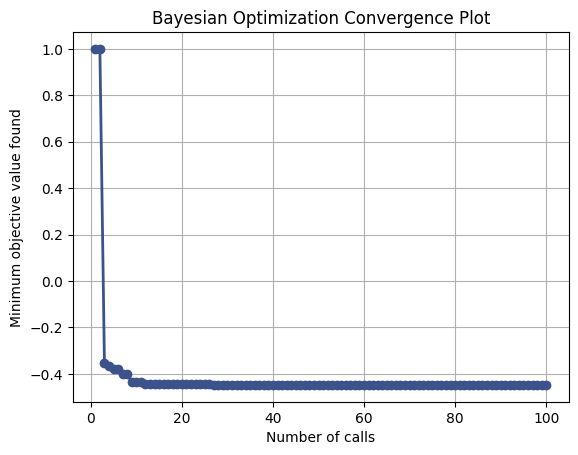

ƒê√£ v·∫Ω bi·ªÉu ƒë·ªì h·ªôi t·ª• th√†nh c√¥ng.

--- Ho√†n t·∫•t qu√° tr√¨nh t·ªëi ∆∞u h√≥a tr·ªçng s·ªë Implicit Feedback cho H·ªá th·ªëng Lai ---


In [8]:
# Cell 4: T·ªëi ∆∞u h√≥a tr·ªçng s·ªë Implicit Feedback (S·ª≠ d·ª•ng Bayesian Optimization)

from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_convergence, plot_evaluations, plot_objective
import matplotlib.pyplot as plt
import json
import datetime
import os # ƒê·∫£m b·∫£o import os cho os.makedirs v√† os.path.join


print("\n--- B·∫Øt ƒë·∫ßu qu√° tr√¨nh t·ªëi ∆∞u h√≥a tr·ªçng s·ªë Implicit Feedback cho H·ªá th·ªëng Lai b·∫±ng Bayesian Optimization ---")

# --- CHU·∫®N B·ªä D·ªÆ LI·ªÜU CONTENT-BASED (CH·ªà T·∫¢I M·ªòT L·∫¶N) ---
print("\n--- ƒêang t·∫£i v√† x·ª≠ l√Ω d·ªØ li·ªáu thu·ªôc t√≠nh s·∫£n ph·∫©m cho Content-based Filtering ---")
df_product_features = load_product_features()

# Ki·ªÉm tra n·∫øu df_product_features r·ªóng, log c·∫£nh b√°o v√† c√≥ th·ªÉ tho√°t
if df_product_features.empty:
    logger.error("Kh√¥ng th·ªÉ t·∫£i d·ªØ li·ªáu thu·ªôc t√≠nh s·∫£n ph·∫©m. Content-based Filtering s·∫Ω kh√¥ng ho·∫°t ƒë·ªông.")
    content_similarities_global = {} # ƒê·∫∑t r·ªóng ƒë·ªÉ tr√°nh l·ªói
else:
    # initialize_global_tfidf_model(df_product_features)
    initialize_global_bert_model(df_product_features)
    if GLOBAL_BERT_MODEL is None or GLOBAL_PRODUCT_EMBEDDINGS is None:
        logger.error("M√¥ h√¨nh BERT ho·∫∑c embeddings kh√¥ng ƒë∆∞·ª£c kh·ªüi t·∫°o th√†nh c√¥ng. Content-based Filtering s·∫Ω kh√¥ng ho·∫°t ƒë·ªông.")
        content_similarities_global = {}
    content_similarities_global = compute_content_similarity(df_product_features, top_k=TOP_K)
    logger.info(f"Ho√†n t·∫•t t√≠nh to√°n ƒë·ªô t∆∞∆°ng ƒë·ªìng Content-based cho {len(content_similarities_global)} s·∫£n ph·∫©m.")
    if not content_similarities_global:
        logger.warning("Kh√¥ng c√≥ ƒë·ªô t∆∞∆°ng ƒë·ªìng Content-based ƒë∆∞·ª£c t√≠nh to√°n. Ki·ªÉm tra d·ªØ li·ªáu v√† TF-IDF.")

if 'df_train_raw' in locals() and not df_train_raw.empty:
    item_interaction_counts_global = df_train_raw['product_id'].value_counts().to_dict()
    logger.info(f"ƒê√£ t√≠nh to√°n s·ªë l∆∞·ª£ng t∆∞∆°ng t√°c cho {len(item_interaction_counts_global)} s·∫£n ph·∫©m.")
else:
    logger.error("df_train_raw kh√¥ng t·ªìn t·∫°i ho·∫∑c r·ªóng. Kh√¥ng th·ªÉ t√≠nh item_interaction_counts_global.")
    item_interaction_counts_global = {} # ƒê·∫∑t r·ªóng ƒë·ªÉ tr√°nh l·ªói


def evaluate_weights_for_similarity(
    df_train_raw: pd.DataFrame,
    df_eval_raw: pd.DataFrame,
    current_weights: Dict[str, float],
    hybrid_alpha: float, # Th√™m tham s·ªë hybrid_alpha
    content_sims: Dict[int, List[Tuple[int, float]]], # Th√™m tham s·ªë content_sims
    cold_start_threshold: int, # TH√äM THAM S·ªê N√ÄY
    item_interaction_counts: Dict[int, int], # TH√äM THAM S·ªê N√ÄY
    top_n_recommendations: int = TOP_N_RECOMMENDATIONS,
    frequency_decay_factor: float = 0.1,
    final_hybrid_threshold: float = 0.0,
) -> Dict[str, float]:
    """
    ƒê√°nh gi√° ch·∫•t l∆∞·ª£ng g·ª£i √Ω (NDCG, Precision, Recall, MAP)
    cho m·ªôt t·∫≠p h·ª£p tr·ªçng s·ªë ph·∫£n h·ªìi ng·∫ßm v√† tr·ªçng s·ªë lai (alpha) ƒë√£ cho,
    s·ª≠ d·ª•ng c·∫£ Collaborative Filtering v√† Content-based Filtering.
    """
    logger.debug(f"ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {current_weights}, alpha lai: {hybrid_alpha}, cold_start_threshold: {cold_start_threshold}")

  
    df_train_weighted = assign_implicit_feedback_scores(
        df_train_raw.copy(),
        current_weights,
        # max_frequency_cap=5, 
        frequency_decay_factor=frequency_decay_factor,
    )


    df_positive_scores = df_train_weighted[df_train_weighted['implicit_score'] > 0]
    logger.info(f"DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: {len(df_positive_scores)}")
    logger.info(f"DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: {df_positive_scores['user_id'].nunique()}")
    logger.info(f"DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: {df_positive_scores['product_id'].nunique()}")

    if df_train_weighted.empty or df_train_weighted['implicit_score'].sum() == 0:
        logger.warning("Kh√¥ng c√≥ d·ªØ li·ªáu hu·∫•n luy·ªán c√≥ tr·ªçng s·ªë √Ω nghƒ©a cho CF. Tr·∫£ v·ªÅ c√°c s·ªë li·ªáu b·∫±ng kh√¥ng.")
        return {'precision_at_n': 0.0, 'recall_at_n': 0.0, 'ndcg_at_n': 0.0, 'map': 0.0}
    logger.info(f"DF_TRAIN_WEIGHTED cho CF: {len(df_train_weighted)} d√≤ng, min_score={df_train_weighted['implicit_score'].min():.2f}, max_score={df_train_weighted['implicit_score'].max():.2f}")

    collab_similarities = compute_sparse_similarity(
        df_train_weighted, top_k=TOP_K, threshold=COSINE_THRESHOLD
    )
    logger.info(f"S·ªë l∆∞·ª£ng item c√≥ ƒë·ªô t∆∞∆°ng ƒë·ªìng CF: {len(collab_similarities)}")
    
    
    
    # --- 2. K·∫øt h·ª£p ƒë·ªô t∆∞∆°ng ƒë·ªìng CF v√† Content-based ---
    if not collab_similarities and not content_sims:
        logger.warning("Kh√¥ng c√≥ ƒë·ªô t∆∞∆°ng ƒë·ªìng CF ho·∫∑c Content-based. Kh√¥ng th·ªÉ t·∫°o g·ª£i √Ω lai. Tr·∫£ v·ªÅ c√°c s·ªë li·ªáu b·∫±ng kh√¥ng.")
        return {'precision_at_n': 0.0, 'recall_at_n': 0.0, 'ndcg_at_n': 0.0, 'map': 0.0}

    # ƒê·∫£m b·∫£o h√†m combine_similarities c√≥ th·ªÉ x·ª≠ l√Ω khi m·ªôt trong hai dict r·ªóng
    # H√†m combine_similarities s·∫Ω t·ª± ƒë·ªông b·ªè qua c√°c tr∆∞·ªùng h·ª£p kh√¥ng c√≥ d·ªØ li·ªáu
    hybrid_similarities = combine_similarities(
        collab_similarities,
        content_sims,
        hybrid_alpha, # alpha_base
        item_interaction_counts, # TH√äM
        cold_start_threshold, # TH√äM
        top_k=TOP_K
    )
    logger.info(f"S·ªë l∆∞·ª£ng item c√≥ ƒë·ªô t∆∞∆°ng ƒë·ªìng lai: {len(hybrid_similarities)}")

     # <--- TH√äM LOGIC L·ªåC FINAL_HYBRID_THRESHOLD T·∫†I ƒê√ÇY ---
    if final_hybrid_threshold > 0: # Ch·ªâ l·ªçc n·∫øu ng∆∞·ª°ng > 0
        filtered_hybrid_similarities = {}
        count_filtered_pairs = 0
        for p1, neighbours in hybrid_similarities.items():
            filtered_neighbours_for_p1 = []
            for p2, hybrid_score, cf_score, content_score in neighbours:
                if hybrid_score >= final_hybrid_threshold:
                    filtered_neighbours_for_p1.append((p2, hybrid_score, cf_score, content_score))
            if filtered_neighbours_for_p1:
                filtered_hybrid_similarities[p1] = filtered_neighbours_for_p1
            else: # ƒê·∫£m b·∫£o item v·∫´n c√≥ entry d√π r·ªóng n·∫øu kh√¥ng t√¨m ƒë∆∞·ª£c l√°ng gi·ªÅng
                filtered_hybrid_similarities[p1] = []
        hybrid_similarities = filtered_hybrid_similarities
        logger.info(f"S·ªë l∆∞·ª£ng item c√≥ ƒë·ªô t∆∞∆°ng ƒë·ªìng lai (sau khi l·ªçc final_hybrid_threshold): {len(hybrid_similarities)}")
    # --- K·∫æT TH√öC LOGIC L·ªåC ---
    
    if not hybrid_similarities:
        logger.warning("Ma tr·∫≠n ƒë·ªô t∆∞∆°ng ƒë·ªìng lai r·ªóng. Tr·∫£ v·ªÅ c√°c s·ªë li·ªáu b·∫±ng kh√¥ng.")
        return {'precision_at_n': 0.0, 'recall_at_n': 0.0, 'ndcg_at_n': 0.0, 'map': 0.0}

    # --- 3. ƒê√°nh gi√° h·ªá th·ªëng g·ª£i √Ω lai ---
    user_train_purchases_map = df_train_raw[df_train_raw['event_type'] == 'purchase'] \
                                 .groupby('user_id')['product_id'].apply(set).to_dict()

    user_eval_actual_interactions = df_eval_raw.groupby('user_id')['product_id'].apply(set).to_dict()

    users_to_evaluate = [u for u in user_eval_actual_interactions.keys() if u in user_train_purchases_map]

    precisions, recalls, ndcgs, maps = [], [], [], []
    logger.info(f"S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ƒë·ªß ƒëi·ªÅu ki·ªán ƒë·ªÉ ƒë√°nh gi√°: {len(users_to_evaluate)}")

    for user_id in users_to_evaluate:
        train_purchased_items = user_train_purchases_map.get(user_id, set())
        actual_items = user_eval_actual_interactions.get(user_id, set())

        if not train_purchased_items or not actual_items:
            continue

        scores: Dict[int, float] = defaultdict(float)

        # Aggregate scores from hybrid similar items
        for p in train_purchased_items:
            # L·∫•y hybrid_score t·ª´ tuple tr·∫£ v·ªÅ c·ªßa combine_similarities
            for q, hybrid_score, cf_score, content_score in hybrid_similarities.get(p, []):
                if q not in train_purchased_items:
                    scores[q] += float(hybrid_score)

        recommended_items_list = [item for item, score in sorted(scores.items(), key=lambda x: x[1], reverse=True)][:top_n_recommendations]

        if recommended_items_list and actual_items:
            precisions.append(precision_at_n(recommended_items_list, actual_items, top_n_recommendations))
            recalls.append(recall_at_n(recommended_items_list, actual_items, top_n_recommendations))
            ndcgs.append(ndcg_at_n(recommended_items_list, actual_items, top_n_recommendations))
            maps.append(average_precision(recommended_items_list, actual_items))

    avg_precision = np.mean(precisions) if precisions else 0.0
    avg_recall = np.mean(recalls) if recalls else 0.0
    avg_ndcg = np.mean(ndcgs) if ndcgs else 0.0
    avg_map = np.mean(maps) if maps else 0.0

    logger.debug(f"K·∫øt qu·∫£ ƒë√°nh gi√°: P@{top_n_recommendations}: {avg_precision:.4f}, R@{top_n_recommendations}: {avg_recall:.4f}, NDCG@{top_n_recommendations}: {avg_ndcg:.4f}, MAP: {avg_map:.4f}")

    return {
        'precision_at_n': avg_precision,
        'recall_at_n': avg_recall,
        'ndcg_at_n': avg_ndcg,
        'map': avg_map
    }


def compute_sparse_similarity(
    df: pd.DataFrame,
    top_k: int = TOP_K,
    threshold: float = COSINE_THRESHOLD
) -> Dict[int, List[Tuple[int, float]]]:
    """
    T√≠nh to√°n ƒë·ªô t∆∞∆°ng ƒë·ªìng item-item cosine t·ª´ DataFrame v·ªõi ƒëi·ªÉm ph·∫£n h·ªìi ng·∫ßm,
    tr·∫£ v·ªÅ m·ªôt t·ª´ ƒëi·ªÉn ch·ª©a top-k item t∆∞∆°ng ƒë·ªìng cho m·ªói item.
    """
    logger.info("ƒêang t√≠nh to√°n ma tr·∫≠n ƒë·ªô t∆∞∆°ng ƒë·ªìng item-item th∆∞a th·ªõt s·ª≠ d·ª•ng ƒëi·ªÉm ng·∫ßm...")

    if 'implicit_score' not in df.columns:
        raise ValueError("DataFrame ph·∫£i ch·ª©a c·ªôt 'implicit_score'.")

    df_filtered = df[df['implicit_score'] > 0].copy()

    logger.info(f"DEBUG_SIM: K√≠ch th∆∞·ªõc DataFrame ƒë√£ l·ªçc (implicit_score > 0): {len(df_filtered)} d√≤ng")
    if df_filtered.empty:
        logger.warning("Kh√¥ng t√¨m th·∫•y ƒëi·ªÉm ng·∫ßm d∆∞∆°ng n√†o ƒë·ªÉ t√≠nh ƒë·ªô t∆∞∆°ng ƒë·ªìng. Tr·∫£ v·ªÅ t·ª´ ƒëi·ªÉn r·ªóng.")
        return {}

    active_users = df_filtered['user_id'].unique()
    active_items = df_filtered['product_id'].unique()
    logger.info(f"DEBUG_SIM: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ho·∫°t ƒë·ªông duy nh·∫•t sau khi l·ªçc: {len(active_users)}")
    logger.info(f"DEBUG_SIM: S·ªë l∆∞·ª£ng item ho·∫°t ƒë·ªông duy nh·∫•t sau khi l·ªçc: {len(active_items)}")

    user_to_idx = {u: i for i, u in enumerate(active_users)}
    item_to_idx = {p: i for i, p in enumerate(active_items)}
    idx_to_item = {i: p for p, i in item_to_idx.items()}

    rows = df_filtered['user_id'].map(user_to_idx)
    cols = df_filtered['product_id'].map(item_to_idx)
    data = df_filtered['implicit_score'].astype(float).to_numpy()

    logger.info(f"DEBUG_SIM: K√≠ch th∆∞·ªõc c·ªßa rows: {len(rows)}, cols: {len(cols)}, data: {len(data)}")

    if len(active_users) == 0 or len(active_items) == 0:
        logger.warning("Kh√¥ng ƒë·ªß ng∆∞·ªùi d√πng ho·∫∑c item duy nh·∫•t c√≥ ƒëi·ªÉm ng·∫ßm d∆∞∆°ng ƒë·ªÉ t√≠nh to√°n ƒë·ªô t∆∞∆°ng ƒë·ªìng. Tr·∫£ v·ªÅ t·ª´ ƒëi·ªÉn r·ªóng.")
        return {}

    sparse_ui = csr_matrix((data, (rows, cols)), shape=(len(active_users), len(active_items)))
    logger.info(f"DEBUG_SIM: H√¨nh d·∫°ng ma tr·∫≠n User-Item th∆∞a th·ªõt: {sparse_ui.shape}, s·ªë l∆∞·ª£ng ph·∫ßn t·ª≠ kh√°c kh√¥ng (nnz): {sparse_ui.nnz}")

    sim_matrix = cosine_similarity(sparse_ui.T, dense_output=False)
    logger.info(f"DEBUG_SIM: H√¨nh d·∫°ng ma tr·∫≠n ƒë·ªô t∆∞∆°ng ƒë·ªìng Item-Item th∆∞a th·ªõt: {sim_matrix.shape}, s·ªë l∆∞·ª£ng ph·∫ßn t·ª≠ kh√°c kh√¥ng (nnz): {sim_matrix.nnz}")

    item_similarities: Dict[int, List[Tuple[int, float]]] = {}
    count_items_with_any_similarity_after_threshold = 0

    for i, item_idx_i in enumerate(active_items):
        original_product_id = item_idx_i
        row = sim_matrix.getrow(i)

        if row.nnz:
            idxs = row.indices
            vals = row.data

            filtered_similarities = [
                (j_idx, s) for j_idx, s in zip(idxs, vals)
                if j_idx != i and s >= threshold
            ]

            if filtered_similarities:
                count_items_with_any_similarity_after_threshold += 1
                topk_pairs = sorted(filtered_similarities, key=lambda x: x[1], reverse=True)[:top_k]
                item_similarities[original_product_id] = [(idx_to_item[j_idx], float(s)) for j_idx, s in topk_pairs]
            else:
                item_similarities[original_product_id] = []
        else:
            item_similarities[original_product_id] = []

    logger.info(f"DEBUG_SIM: T·ªïng s·ªë item (original_product_id) c√≥ √≠t nh·∫•t M·ªòT ƒë·ªô t∆∞∆°ng ƒë·ªìng H·ª¢P L·ªÜ (kh√°c n√≥ v√† >= ng∆∞·ª°ng): {count_items_with_any_similarity_after_threshold}")
    logger.info("Ho√†n t·∫•t t√≠nh to√°n ƒë·ªô t∆∞∆°ng ƒë·ªìng th∆∞a th·ªõt.")
    return item_similarities


# ƒê·ªãnh nghƒ©a kh√¥ng gian t√¨m ki·∫øm cho Bayesian Optimization
# B√¢y gi·ªù bao g·ªìm c·∫£ HYBRID_ALPHA v√† cold_start_threshold
space = [
    Real(0.1, 0.2, name='view'),
    Real(0.2, 0.7, name='add_to_cart'),
    Real(0.1, 0.4, name='wishlist'),
    Real(0.0, 1.0, name='hybrid_alpha'),
    Integer(1, 20, name='cold_start_threshold'),
    Real(0.01, 0.5, name='frequency_decay_factor'),
    Real(0.0, 0.5, name='final_hybrid_threshold'), # <--- TH√äM D√íNG N√ÄY

]

# ƒê·ªãnh nghƒ©a tr·ªçng s·ªë purchase c·ªë ƒë·ªãnh
FIXED_PURCHASE_WEIGHT = 1.0

@use_named_args(space)
def objective(view, add_to_cart, wishlist, hybrid_alpha, cold_start_threshold,frequency_decay_factor,final_hybrid_threshold): # C·∫¨P NH·∫¨T ƒê·ªêI S·ªê
    current_weights = {
        'view': view,
        'add_to_cart': add_to_cart,
        'wishlist': wishlist,
        'purchase': FIXED_PURCHASE_WEIGHT # S·ª≠ d·ª•ng gi√° tr·ªã c·ªë ƒë·ªãnh ·ªü ƒë√¢y
    }

    # Ki·ªÉm tra r√†ng bu·ªôc th·ª© t·ª± cho tr·ªçng s·ªë ph·∫£n h·ªìi ng·∫ßm
    epsilon = 1e-6
    if not (current_weights['view'] < current_weights['wishlist'] - epsilon and
            current_weights['wishlist'] < current_weights['add_to_cart'] - epsilon and
            current_weights['add_to_cart'] < current_weights['purchase'] - epsilon):
        logger.warning(f"DEBUG_OBJ: Vi ph·∫°m r√†ng bu·ªôc th·ª© t·ª± v·ªõi tr·ªçng s·ªë ng·∫ßm: {current_weights}. Tr·∫£ v·ªÅ 1.0.")
        return 1.0 # Gi√° tr·ªã cao, nghƒ©a l√† t·ªá, ƒë·ªÉ Bayesian Opt kh√¥ng ch·ªçn

    # Ki·ªÉm tra r√†ng bu·ªôc cho hybrid_alpha
    if not (0.0 <= hybrid_alpha <= 1.0):
        logger.warning(f"DEBUG_OBJ: hybrid_alpha ({hybrid_alpha}) n·∫±m ngo√†i kho·∫£ng [0, 1]. Tr·∫£ v·ªÅ 1.0.")
        return 1.0

    # Ki·ªÉm tra r√†ng bu·ªôc cho cold_start_threshold (n·∫øu c·∫ßn, nh∆∞ng Integer(1,20) ƒë√£ x·ª≠ l√Ω)
    if not (1 <= cold_start_threshold <= 20):
        logger.warning(f"DEBUG_OBJ: cold_start_threshold ({cold_start_threshold}) n·∫±m ngo√†i kho·∫£ng [1, 20]. Tr·∫£ v·ªÅ 1.0.")
        return 1.0

    logger.info(f"DEBUG_OBJ: ƒê√°nh gi√° v·ªõi tr·ªçng s·ªë: {current_weights}, alpha lai: {hybrid_alpha}, cold_start_threshold: {cold_start_threshold}")

    evaluation_metrics = evaluate_weights_for_similarity(
        df_train_raw.copy(),
        df_val_raw.copy(),
        current_weights,
        hybrid_alpha, # Truy·ªÅn hybrid_alpha v√†o h√†m ƒë√°nh gi√°
        content_similarities_global, # Truy·ªÅn content_similarities ƒë√£ t√≠nh to√°n m·ªôt l·∫ßn
        cold_start_threshold, # TRUY·ªÄN THAM S·ªê M·ªöI V√ÄO
        item_interaction_counts_global, # TRUY·ªÄN THAM S·ªê M·ªöI V√ÄO
        TOP_N_RECOMMENDATIONS,
        frequency_decay_factor,
        final_hybrid_threshold=final_hybrid_threshold,
    )

    score_to_minimize = -evaluation_metrics['ndcg_at_n']
    logger.info(f"DEBUG_OBJ: NDCG@{TOP_N_RECOMMENDATIONS}: {evaluation_metrics['ndcg_at_n']:.4f}, Optimization Score: {score_to_minimize:.4f}")
    return score_to_minimize

# Th·ª±c hi·ªán t·ªëi ∆∞u h√≥a Bayesian n·∫øu d·ªØ li·ªáu ƒë·ªß
if not df_raw_events.empty and 'common_users_for_eval' in locals() and len(common_users_for_eval) > 0:
    logger.info("B·∫Øt ƒë·∫ßu t·ªëi ∆∞u h√≥a Bayesian...")
    result = gp_minimize(
        objective,
        space,
        n_calls=100,
        n_random_starts=20,
        random_state=42,
        verbose=True
    )

    # Tr√≠ch xu·∫•t tr·ªçng s·ªë t·ªëi ∆∞u
    # C√°c ch·ªâ s·ªë c·ªßa result.x s·∫Ω t∆∞∆°ng ·ª©ng v·ªõi th·ª© t·ª± trong 'space'
    optimal_weights = {
        'view': result.x[0],
        'add_to_cart': result.x[1],
        'wishlist': result.x[2],
        'purchase': FIXED_PURCHASE_WEIGHT # Th√™m l·∫°i tr·ªçng s·ªë purchase c·ªë ƒë·ªãnh v√†o k·∫øt qu·∫£
    }
    optimal_hybrid_alpha = result.x[3]
    optimal_cold_start_threshold = int(result.x[4]) # L·∫•y cold_start_threshold v√† chuy·ªÉn sang int
    optimal_frequency_decay_factor = result.x[5] # <-- TR√çCH XU·∫§T THAM S·ªê M·ªöI V√ÄO ƒê√ÇY
    optimal_final_hybrid_threshold = result.x[6] # <--- TR√çCH XU·∫§T THAM S·ªê M·ªöI

    best_ndcg = -result.fun # result.fun l√† gi√° tr·ªã t·ªëi thi·ªÉu c·ªßa h√†m m·ª•c ti√™u (-NDCG)
    print(f"\n--- Tr·ªçng s·ªë t·ªëi ∆∞u t√¨m ƒë∆∞·ª£c b·∫±ng Bayesian Optimization tr√™n t·∫≠p Validation: {optimal_weights} ---")
    print(f"--- Alpha lai t·ªëi ∆∞u: {optimal_hybrid_alpha:.4f} ---")
    print(f"--- Ng∆∞·ª°ng Cold-Start t·ªëi ∆∞u: {optimal_cold_start_threshold} ---") # In ra ng∆∞·ª°ng cold-start
    print(f"--- Frequency Decay Factor t·ªëi ∆∞u: {optimal_frequency_decay_factor:.4f} ---") # <-- IN RA
    print(f"--- Ng∆∞·ª°ng Lai Cu·ªëi C√πng t·ªëi ∆∞u: {optimal_final_hybrid_threshold:.4f} ---") # <--- IN RA
    print(f"--- V·ªõi ƒëi·ªÉm NDCG t·ªët nh·∫•t: {best_ndcg:.4f} ---")


    # --- TH√äM PH·∫¶N L∆ØU TR·ªÆ TR·ªåNG S·ªê V√ÄO T·ªÜP JSON T·∫†Y ƒê√ÇY ---
    results_dir = 'optimization_results'
    os.makedirs(results_dir, exist_ok=True) # ƒê·∫£m b·∫£o th∆∞ m·ª•c t·ªìn t·∫°i

    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    weights_file_name = os.path.join(results_dir, f'optimal_hybrid_weights_{timestamp}.json')

    try:
        with open(weights_file_name, 'w') as f:
            json.dump({
                "optimal_implicit_weights": optimal_weights,
                "optimal_hybrid_alpha": optimal_hybrid_alpha,
                "optimal_cold_start_threshold": int(optimal_cold_start_threshold), # L∆∞u int
                "optimal_frequency_decay_factor": optimal_frequency_decay_factor, # <--- L∆ØU THAM S·ªê M·ªöI
                "optimal_final_hybrid_threshold": optimal_final_hybrid_threshold, # <--- L∆ØU THAM S·ªê M·ªöI
                "best_ndcg": best_ndcg,
                "top_n_recommendations": TOP_N_RECOMMENDATIONS,
                "top_k_similar_items": TOP_K,
                "cosine_threshold": COSINE_THRESHOLD,
                "optimization_timestamp": timestamp
            }, f, indent=4)
        print(f"\n--- Tr·ªçng s·ªë lai t·ªëi ∆∞u ƒë√£ ƒë∆∞·ª£c l∆∞u v√†o: {weights_file_name} ---")
    except Exception as e:
        print(f"\n--- L·ªói khi l∆∞u tr·ªçng s·ªë v√†o t·ªáp JSON: {e} ---")
    # --- K·∫æT TH√öC PH·∫¶N L∆ØU TR·ªÆ ---
     # print(f"\n--- ƒêang v·∫Ω bi·ªÉu ƒë·ªì h·ªôi t·ª• ---")
    try:
        plot_convergence(result)
        plt.title('Bayesian Optimization Convergence Plot')
        plt.xlabel('Number of calls')
        plt.ylabel('Minimum objective value found')
        plt.grid(True)
        plt.show()
        print("ƒê√£ v·∫Ω bi·ªÉu ƒë·ªì h·ªôi t·ª• th√†nh c√¥ng.")
    except Exception as e:
        print(f"L·ªói khi v·∫Ω bi·ªÉu ƒë·ªì h·ªôi t·ª•: {e}")




else:
    logger.warning("B·ªè qua T·ªëi ∆∞u h√≥a Bayesian do kh√¥ng ƒë·ªß d·ªØ li·ªáu ƒë·ªÉ ƒë√°nh gi√° (v√≠ d·ª•: kh√¥ng c√≥ ng∆∞·ªùi d√πng chung ƒë·ªÉ ƒë√°nh gi√°).")

print("\n--- Ho√†n t·∫•t qu√° tr√¨nh t·ªëi ∆∞u h√≥a tr·ªçng s·ªë Implicit Feedback cho H·ªá th·ªëng Lai ---")

2025-07-25 10:04:58,117 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:04:58,138 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng d√≤ng c√≥ implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:04:58,140 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng duy nh·∫•t c√≥ implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:04:58,142 - INFO - DEBUG_EVAL: S·ªë l∆∞·ª£ng s·∫£n ph·∫©m duy nh·∫•t c√≥ implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:04:58,143 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 d√≤ng, min_score=0.00, max_score=1.00
2025-07-25 10:04:58,145 - INFO - ƒêang t√≠nh to√°n ma tr·∫≠n ƒë·ªô t∆∞∆°ng ƒë·ªìng item-item th∆∞a th·ªõt s·ª≠ d·ª•ng ƒëi·ªÉm ng·∫ßm...
2025-07-25 10:04:58,149 - INFO - DEBUG_SIM: K√≠ch th∆∞·ªõc DataFrame ƒë√£ l·ªçc (implicit_score > 0): 103975 d√≤ng
2025-07-25 10:04:58,149 - INFO - DEBUG_SIM: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ho·∫°t ƒë·ªông duy nh·∫•t sau khi l·ªçc: 2


--- B·∫Øt ƒë·∫ßu ƒë√°nh gi√° hi·ªáu su·∫•t cu·ªëi c√πng tr√™n t·∫≠p Test ƒë·ªôc l·∫≠p ---


2025-07-25 10:04:58,183 - INFO - DEBUGGING ALPHA: For p1=69 (Interactions: 3986), cold_start_threshold=15, dynamic_alpha used: 0.8851
2025-07-25 10:04:58,183 - INFO - DEBUGGING ALPHA: For p1=70 (Interactions: 912), cold_start_threshold=15, dynamic_alpha used: 0.8851
2025-07-25 10:04:58,184 - INFO - DEBUGGING ALPHA: For p1=71 (Interactions: 7293), cold_start_threshold=15, dynamic_alpha used: 0.8851
2025-07-25 10:04:58,184 - INFO - DEBUGGING ALPHA: For p1=72 (Interactions: 7678), cold_start_threshold=15, dynamic_alpha used: 0.8851
2025-07-25 10:04:58,185 - INFO - DEBUGGING ALPHA: For p1=73 (Interactions: 4181), cold_start_threshold=15, dynamic_alpha used: 0.8851
2025-07-25 10:04:58,186 - INFO - DEBUGGING ALPHA: For p1=74 (Interactions: 0), cold_start_threshold=15, dynamic_alpha used: 0.1000
2025-07-25 10:04:58,186 - INFO - DEBUGGING ALPHA: For p1=56 (Interactions: 23848), cold_start_threshold=15, dynamic_alpha used: 0.8851
2025-07-25 10:04:58,187 - INFO - DEBUGGING ALPHA: For p1=57 (Inte


--- Hi·ªáu su·∫•t m√¥ h√¨nh cu·ªëi c√πng tr√™n t·∫≠p Test Set v·ªõi TOP_N=15 ---
- precision_at_n: 0.3071
- recall_at_n: 0.5407
- ndcg_at_n: 0.4637
- map: 0.2926


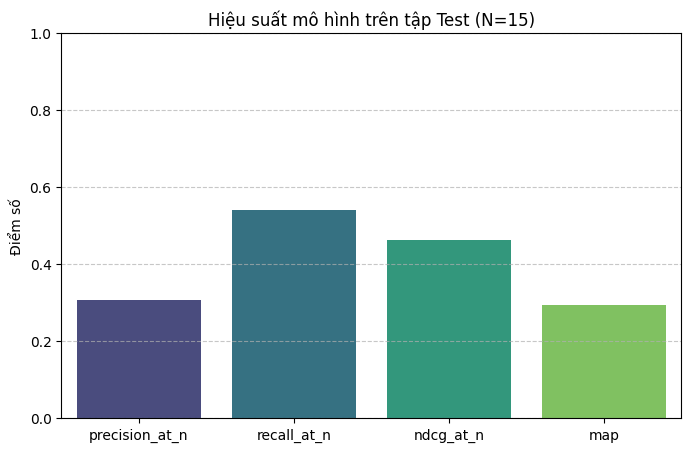


--- Ho√†n t·∫•t ƒë√°nh gi√° hi·ªáu su·∫•t cu·ªëi c√πng tr√™n t·∫≠p Test ƒë·ªôc l·∫≠p ---


In [9]:
# Cell 5: ƒê√°nh gi√° hi·ªáu su·∫•t cu·ªëi c√πng tr√™n Test Set

print("\n--- B·∫Øt ƒë·∫ßu ƒë√°nh gi√° hi·ªáu su·∫•t cu·ªëi c√πng tr√™n t·∫≠p Test ƒë·ªôc l·∫≠p ---")
# ƒê·∫£m b·∫£o df_train_raw v√† df_test_raw ƒë∆∞·ª£c gi·ªØ nguy√™n t·ª´ Cell 3
final_evaluation_metrics = evaluate_weights_for_similarity(
    df_train_raw.copy(),
    df_test_raw.copy(),
    optimal_weights,
    optimal_hybrid_alpha,
    # S·ª¨A L·ªñI ·ªû ƒê√ÇY: ƒê·ªïi th·ª© t·ª± tham s·ªë ƒë·ªÉ kh·ªõp v·ªõi ƒë·ªãnh nghƒ©a h√†m
    content_similarities_global, # content_sims l√† tham s·ªë th·ª© 5 trong ƒë·ªãnh nghƒ©a
    optimal_cold_start_threshold, # cold_start_threshold l√† tham s·ªë th·ª© 6 trong ƒë·ªãnh nghƒ©a
    # B·∫°n c≈©ng c·∫ßn truy·ªÅn item_interaction_counts_global v√†o ƒë√¢y
    item_interaction_counts_global, # Th√™m tham s·ªë n√†y v√†o l·ªùi g·ªçi h√†m
    TOP_N_RECOMMENDATIONS,
    optimal_frequency_decay_factor 
)
print(f"\n--- Hi·ªáu su·∫•t m√¥ h√¨nh cu·ªëi c√πng tr√™n t·∫≠p Test Set v·ªõi TOP_N={TOP_N_RECOMMENDATIONS} ---")
for metric, score in final_evaluation_metrics.items():
    print(f"- {metric}: {score:.4f}")

# Tr·ª±c quan h√≥a k·∫øt qu·∫£ ƒë√°nh gi√° cu·ªëi c√πng
metrics_names = list(final_evaluation_metrics.keys())
metrics_values = list(final_evaluation_metrics.values())

plt.figure(figsize=(8, 5))
# ƒê·∫£m b·∫£o sns ƒë√£ ƒë∆∞·ª£c import: import seaborn as sns
import seaborn as sns # Th√™m d√≤ng n√†y n·∫øu ch∆∞a c√≥ ·ªü Cell 1
sns.barplot(x=metrics_names, y=metrics_values, palette='viridis')
plt.title(f'Hi·ªáu su·∫•t m√¥ h√¨nh tr√™n t·∫≠p Test (N={TOP_N_RECOMMENDATIONS})')
plt.ylabel('ƒêi·ªÉm s·ªë')
plt.ylim(0, 1) # ƒê·∫£m b·∫£o tr·ª•c Y t·ª´ 0 ƒë·∫øn 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("\n--- Ho√†n t·∫•t ƒë√°nh gi√° hi·ªáu su·∫•t cu·ªëi c√πng tr√™n t·∫≠p Test ƒë·ªôc l·∫≠p ---")

2025-07-25 10:08:02,971 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:08:02,978 - INFO - T·ªïng s·ªë s·ª± ki·ªán sau khi g√°n tr·ªçng s·ªë: 193204
2025-07-25 10:08:02,989 - INFO - S·ªë l∆∞·ª£ng s·ª± ki·ªán c√≥ implicit_score > 0: 172479



--- B·∫Øt ƒë·∫ßu qu√° tr√¨nh t√≠nh to√°n v√† l∆∞u tr·ªØ Hybrid Item Similarity ---

--- √Åp d·ª•ng tr·ªçng s·ªë t·ªëi ∆∞u cho to√†n b·ªô d·ªØ li·ªáu s·ª± ki·ªán ---

--- DEBUG: Ki·ªÉm tra Event Types v√† Weights ---
Unique event_types in df_raw_events: ['view' 'add_to_cart' 'purchase' 'wishlist' 'rate']
Keys in optimal_weights: dict_keys(['view', 'add_to_cart', 'wishlist', 'purchase'])

--- DEBUG: Tham s·ªë ƒëang ƒë∆∞·ª£c truy·ªÅn v√†o assign_implicit_feedback_scores ---
Optimal Weights: {'view': 0.17056806038472655, 'add_to_cart': 0.4758852868806091, 'wishlist': 0.3607027193434893, 'purchase': 1.0}
Optimal Frequency Decay Factor (from optimal_frequency_decay_factor): 0.3464690062
Ki·ªÉu d·ªØ li·ªáu c·ªßa optimal_frequency_decay_factor: <class 'float'>
Ki·ªÉu d·ªØ li·ªáu c·ªßa optimal_weights['view']: <class 'float'>
--- 5 h√†ng ƒë·∫ßu ti√™n c·ªßa d·ªØ li·ªáu s·ª± ki·ªán ƒë√£ g√°n tr·ªçng s·ªë (To√†n b·ªô d·ªØ li·ªáu) ---
   user_id  product_id   event_type          created_at  implic

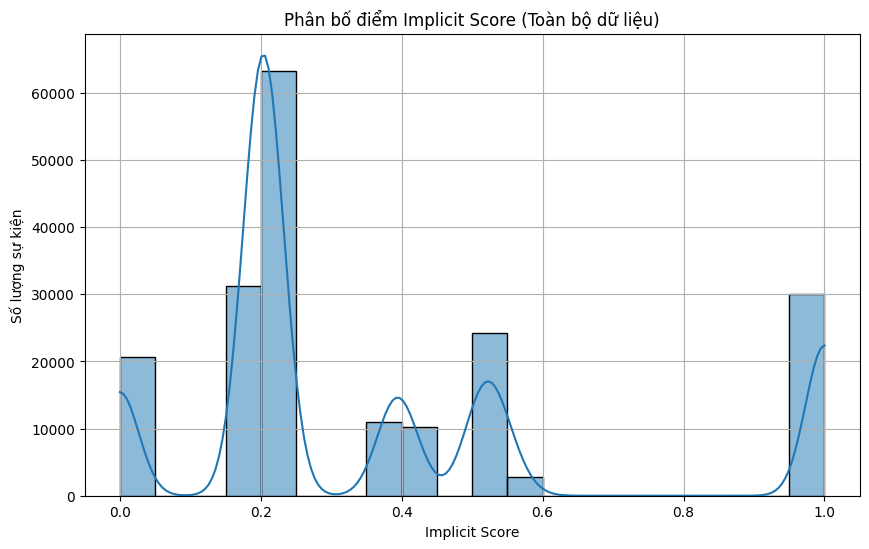

2025-07-25 10:08:04,084 - INFO - ƒê√£ t√≠nh s·ªë l∆∞·ª£ng t∆∞∆°ng t√°c cho 18 s·∫£n ph·∫©m.
2025-07-25 10:08:04,084 - INFO - ƒêang t√≠nh to√°n ma tr·∫≠n ƒë·ªô t∆∞∆°ng ƒë·ªìng item-item th∆∞a th·ªõt s·ª≠ d·ª•ng ƒëi·ªÉm ng·∫ßm...
2025-07-25 10:08:04,103 - INFO - DEBUG_SIM: K√≠ch th∆∞·ªõc DataFrame ƒë√£ l·ªçc (implicit_score > 0): 172479 d√≤ng
2025-07-25 10:08:04,109 - INFO - DEBUG_SIM: S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng ho·∫°t ƒë·ªông duy nh·∫•t sau khi l·ªçc: 2000
2025-07-25 10:08:04,110 - INFO - DEBUG_SIM: S·ªë l∆∞·ª£ng item ho·∫°t ƒë·ªông duy nh·∫•t sau khi l·ªçc: 18
2025-07-25 10:08:04,112 - INFO - DEBUG_SIM: K√≠ch th∆∞·ªõc c·ªßa rows: 172479, cols: 172479, data: 172479
2025-07-25 10:08:04,124 - INFO - DEBUG_SIM: H√¨nh d·∫°ng ma tr·∫≠n User-Item th∆∞a th·ªõt: (2000, 18), s·ªë l∆∞·ª£ng ph·∫ßn t·ª≠ kh√°c kh√¥ng (nnz): 27883
2025-07-25 10:08:04,127 - INFO - DEBUG_SIM: H√¨nh d·∫°ng ma tr·∫≠n ƒë·ªô t∆∞∆°ng ƒë·ªìng Item-Item th∆∞a th·ªõt: (18, 18), s·ªë l∆∞·ª£ng ph·∫ßn t·ª≠ kh√°c kh√¥ng (nnz): 3


--- T√≠nh to√°n s·ªë l∆∞·ª£ng t∆∞∆°ng t√°c c·ªßa s·∫£n ph·∫©m cho Dynamic Weighting ---

--- B·∫Øt ƒë·∫ßu t√≠nh to√°n ƒë·ªô t∆∞∆°ng ƒë·ªìng Collaborative Filtering (CF) t·ª´ to√†n b·ªô d·ªØ li·ªáu ---

--- B·∫Øt ƒë·∫ßu k·∫øt h·ª£p ƒë·ªô t∆∞∆°ng ƒë·ªìng CF v√† Content-based (Hybrid) ---

--- ƒêang l·ªçc Hybrid Item Similarity b·∫±ng FINAL_HYBRID_THRESHOLD (0.1392) ---

--- 5 v√≠ d·ª• ƒë·∫ßu ti√™n v·ªÅ Hybrid Item Similarity (Product ID: [List of (Similar Product ID, Hybrid Score, CF Score, Content Score)]) ---
Product ID 64: [(np.int64(56), 0.6935575030092427, 0.6640699948931837, 0.920799732208252), (np.int64(67), 0.608358448221916, 0.5620575958941143, 0.9651708602905273), (np.int64(66), 0.5845062080883249, 0.5373344945344601, 0.9480298161506653), (np.int64(58), 0.5508498542219143, 0.5050134544963575, 0.9040830135345459), (np.int64(73), 0.5471921452533111, 0.49873853186391215, 0.9205945730209351), (np.int64(61), 0.5428522909442808, 0.4916785145675364, 0.9372173547744751), (np.int64(59)

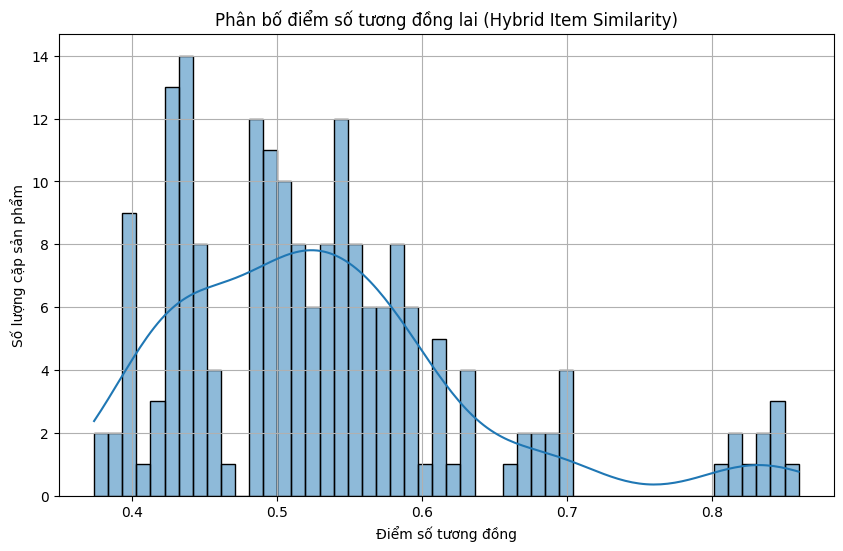

2025-07-25 10:08:04,355 - INFO - Cleared existing data from item_similarity.
2025-07-25 10:08:04,370 - INFO - Persisted 132 unique item similarities successfully into item_similarity.



--- B·∫Øt ƒë·∫ßu l∆∞u tr·ªØ ƒë·ªô t∆∞∆°ng ƒë·ªìng Hybrid Item Similarity v√†o c∆° s·ªü d·ªØ li·ªáu ---
--- Ho√†n t·∫•t l∆∞u tr·ªØ Hybrid Item Similarity ---

--- Ho√†n t·∫•t qu√° tr√¨nh t√≠nh to√°n v√† l∆∞u tr·ªØ Hybrid Item Similarity ---


In [10]:
# Cell 6: T√≠nh to√°n v√† l∆∞u tr·ªØ Hybrid Item Similarity (S·ª≠ d·ª•ng to√†n b·ªô d·ªØ li·ªáu)

print("\n--- B·∫Øt ƒë·∫ßu qu√° tr√¨nh t√≠nh to√°n v√† l∆∞u tr·ªØ Hybrid Item Similarity ---")

# 1. T·∫£i v√† x·ª≠ l√Ω d·ªØ li·ªáu thu·ªôc t√≠nh s·∫£n ph·∫©m cho Content-based Filtering
# (B∆∞·ªõc n√†y th·ª±c t·∫ø ƒë√£ ƒë∆∞·ª£c ch·∫°y trong Cell 4 v√† content_similarities_global ƒë√£ c√≥)
# Tuy nhi√™n, ƒë·ªÉ ƒë·∫£m b·∫£o t√≠nh ƒë·ªôc l·∫≠p ho·∫∑c n·∫øu ch·∫°y ri√™ng Cell 6, b·∫°n c√≥ th·ªÉ ch·∫°y l·∫°i.
# N·∫øu content_similarities_global ƒë√£ ƒë∆∞·ª£c ƒë·ªãnh nghƒ©a t·ª´ Cell 4, c√≥ th·ªÉ b·ªè qua d√≤ng n√†y.
# ƒê·ªÉ an to√†n, ch√∫ng ta s·∫Ω ki·ªÉm tra v√† t·∫£i l·∫°i n·∫øu c·∫ßn.
if 'content_similarities_global' not in locals() or not content_similarities_global:
    print("\n--- ƒêang t·∫£i v√† x·ª≠ l√Ω d·ªØ li·ªáu thu·ªôc t√≠nh s·∫£n ph·∫©m cho Content-based Filtering (n·∫øu ch∆∞a c√≥) ---")
    df_product_features = load_product_features()
    if df_product_features.empty:
        logger.error("Kh√¥ng th·ªÉ t·∫£i d·ªØ li·ªáu thu·ªôc t√≠nh s·∫£n ph·∫©m. Content-based Filtering s·∫Ω kh√¥ng ho·∫°t ƒë·ªông.")
        content_similarities_global = {} # ƒê·∫∑t r·ªóng ƒë·ªÉ tr√°nh l·ªói
    else:
        content_similarities_global = compute_content_similarity(df_product_features, top_k=TOP_K)
        logger.info(f"Ho√†n t·∫•t t√≠nh to√°n ƒë·ªô t∆∞∆°ng ƒë·ªìng Content-based cho {len(content_similarities_global)} s·∫£n ph·∫©m.")
        if not content_similarities_global:
            logger.warning("Kh√¥ng c√≥ ƒë·ªô t∆∞∆°ng ƒë·ªìng Content-based ƒë∆∞·ª£c t√≠nh to√°n. Ki·ªÉm tra d·ªØ li·ªáu v√† TF-IDF.")


# 2. √Åp d·ª•ng tr·ªçng s·ªë t·ªëi ∆∞u cho to√†n b·ªô d·ªØ li·ªáu s·ª± ki·ªán th√¥ ƒë·ªÉ c√≥ 'implicit_score'
print("\n--- √Åp d·ª•ng tr·ªçng s·ªë t·ªëi ∆∞u cho to√†n b·ªô d·ªØ li·ªáu s·ª± ki·ªán ---")
# ƒê·∫£m b·∫£o df_raw_events v√† optimal_weights ƒë√£ ƒë∆∞·ª£c ƒë·ªãnh nghƒ©a t·ª´ c√°c cell tr∆∞·ªõc.
# optimal_weights ƒë∆∞·ª£c l·∫•y t·ª´ Cell 4.
if 'optimal_weights' not in locals():
    logger.error("optimal_weights ch∆∞a ƒë∆∞·ª£c ƒë·ªãnh nghƒ©a. H√£y ch·∫°y Cell 4 tr∆∞·ªõc.")
    raise NameError("optimal_weights is not defined. Please run Cell 4.")


# Trong Cell 6, tr∆∞·ªõc d√≤ng g·ªçi assign_implicit_feedback_scores:
print(f"\n--- DEBUG: Ki·ªÉm tra Event Types v√† Weights ---")
if 'df_raw_events' in globals(): # Ki·ªÉm tra xem bi·∫øn c√≥ t·ªìn t·∫°i kh√¥ng
    print("Unique event_types in df_raw_events:", df_raw_events['event_type'].unique())
else:
    logger.warning("df_raw_events kh√¥ng t·ªìn t·∫°i khi ki·ªÉm tra event types.")

if 'optimal_weights' in globals(): # Ki·ªÉm tra xem bi·∫øn c√≥ t·ªìn t·∫°i kh√¥ng
    print("Keys in optimal_weights:", optimal_weights.keys())
else:
    logger.warning("optimal_weights kh√¥ng t·ªìn t·∫°i khi ki·ªÉm tra event types.")


df_weighted_events_for_final_model = assign_implicit_feedback_scores(df_raw_events.copy(), optimal_weights)
logger.info(f"T·ªïng s·ªë s·ª± ki·ªán sau khi g√°n tr·ªçng s·ªë: {len(df_weighted_events_for_final_model)}")
logger.info(f"S·ªë l∆∞·ª£ng s·ª± ki·ªán c√≥ implicit_score > 0: {len(df_weighted_events_for_final_model[df_weighted_events_for_final_model['implicit_score'] > 0])}")
print(f"\n--- DEBUG: Tham s·ªë ƒëang ƒë∆∞·ª£c truy·ªÅn v√†o assign_implicit_feedback_scores ---")
print(f"Optimal Weights: {optimal_weights}")
print(f"Optimal Frequency Decay Factor (from optimal_frequency_decay_factor): {optimal_frequency_decay_factor:.10f}") # In v·ªõi ƒë·ªô ch√≠nh x√°c cao
print(f"Ki·ªÉu d·ªØ li·ªáu c·ªßa optimal_frequency_decay_factor: {type(optimal_frequency_decay_factor)}")
print(f"Ki·ªÉu d·ªØ li·ªáu c·ªßa optimal_weights['view']: {type(optimal_weights['view'])}")

print("--- 5 h√†ng ƒë·∫ßu ti√™n c·ªßa d·ªØ li·ªáu s·ª± ki·ªán ƒë√£ g√°n tr·ªçng s·ªë (To√†n b·ªô d·ªØ li·ªáu) ---")
print(df_weighted_events_for_final_model.head())

print("\n--- Ki·ªÉm tra gi√° tr·ªã implicit_score th·ª±c t·∫ø cho c√°c h√†ng 'view' b·ªã hi·ªÉn th·ªã l√† 0 ---")
# L·∫•y ra c√°c h√†ng c√≥ event_type l√† 'view' v√† implicit_score hi·ªÉn th·ªã l√† 0
# (L∆∞u √Ω: ch√∫ng ta ki·ªÉm tra gi√° tr·ªã th·ª±c, kh√¥ng ph·∫£i gi√° tr·ªã hi·ªÉn th·ªã)
df_views_with_low_score = df_weighted_events_for_final_model[
    (df_weighted_events_for_final_model['event_type'] == 'view') &
    (df_weighted_events_for_final_model['implicit_score'] < 0.001) # Ki·ªÉm tra c√°c gi√° tr·ªã r·∫•t nh·ªè
].head(10) # L·∫•y 10 h√†ng ƒë·∫ßu ti√™n ƒë·ªÉ ki·ªÉm tra

if not df_views_with_low_score.empty:
    with pd.option_context('display.float_format', '{:.10f}'.format): # Hi·ªÉn th·ªã nhi·ªÅu ch·ªØ s·ªë th·∫≠p ph√¢n h∆°n
        print(df_views_with_low_score[['user_id', 'product_id', 'event_type', 'implicit_score']])
else:
    print("Kh√¥ng t√¨m th·∫•y h√†ng 'view' n√†o c√≥ implicit_score g·∫ßn b·∫±ng 0.")

print(f"\nGi√° tr·ªã nh·ªè nh·∫•t c·ªßa implicit_score trong to√†n b·ªô DataFrame: {df_weighted_events_for_final_model['implicit_score'].min():.10f}")


# Tr·ª±c quan h√≥a ph√¢n b·ªë ƒëi·ªÉm implicit_score
plt.figure(figsize=(10, 6))
sns.histplot(df_weighted_events_for_final_model['implicit_score'], bins=20, kde=True)
plt.title('Ph√¢n b·ªë ƒëi·ªÉm Implicit Score (To√†n b·ªô d·ªØ li·ªáu)')
plt.xlabel('Implicit Score')
plt.ylabel('S·ªë l∆∞·ª£ng s·ª± ki·ªán')
plt.grid(True)
plt.show()


print("\n--- T√≠nh to√°n s·ªë l∆∞·ª£ng t∆∞∆°ng t√°c c·ªßa s·∫£n ph·∫©m cho Dynamic Weighting ---")
# S·ª≠ d·ª•ng df_raw_events ƒë·ªÉ l·∫•y s·ªë l∆∞·ª£ng t∆∞∆°ng t√°c th√¥ c·ªßa t·ª´ng s·∫£n ph·∫©m.
# ƒê√¢y l√† d·ªØ li·ªáu g·ªëc, ch∆∞a b·ªã lo·∫°i b·ªè hay bi·∫øn ƒë·ªïi.
if 'df_raw_events' not in locals():
    logger.error("df_raw_events ch∆∞a ƒë∆∞·ª£c ƒë·ªãnh nghƒ©a. H√£y t·∫£i d·ªØ li·ªáu g·ªëc tr∆∞·ªõc.")
    raise NameError("df_raw_events is not defined. Please ensure raw event data is loaded.")
item_interaction_counts_for_final_model = df_raw_events['product_id'].value_counts().to_dict()
logger.info(f"ƒê√£ t√≠nh s·ªë l∆∞·ª£ng t∆∞∆°ng t√°c cho {len(item_interaction_counts_for_final_model)} s·∫£n ph·∫©m.")

# 3. T√≠nh to√°n ƒë·ªô t∆∞∆°ng ƒë·ªìng Collaborative Filtering t·ª´ to√†n b·ªô d·ªØ li·ªáu
print("\n--- B·∫Øt ƒë·∫ßu t√≠nh to√°n ƒë·ªô t∆∞∆°ng ƒë·ªìng Collaborative Filtering (CF) t·ª´ to√†n b·ªô d·ªØ li·ªáu ---")
collab_similarities_final = compute_sparse_similarity(df_weighted_events_for_final_model, TOP_K, COSINE_THRESHOLD)
logger.info(f"ƒê√£ t√≠nh to√°n ƒë·ªô t∆∞∆°ng ƒë·ªìng CF cho {len(collab_similarities_final)} s·∫£n ph·∫©m.")

# 4. K·∫øt h·ª£p ƒë·ªô t∆∞∆°ng ƒë·ªìng CF v√† Content-based s·ª≠ d·ª•ng alpha lai t·ªëi ∆∞u
print("\n--- B·∫Øt ƒë·∫ßu k·∫øt h·ª£p ƒë·ªô t∆∞∆°ng ƒë·ªìng CF v√† Content-based (Hybrid) ---")
# ƒê·∫£m b·∫£o optimal_hybrid_alpha ƒë√£ ƒë∆∞·ª£c ƒë·ªãnh nghƒ©a t·ª´ Cell 4.
if 'optimal_hybrid_alpha' not in locals():
    logger.error("optimal_hybrid_alpha ch∆∞a ƒë∆∞·ª£c ƒë·ªãnh nghƒ©a. H√£y ch·∫°y Cell 4 tr∆∞·ªõc.")
    raise NameError("optimal_hybrid_alpha is not defined. Please run Cell 4.")

final_hybrid_similarities = combine_similarities(
    collab_similarities_final,
    content_similarities_global,
    optimal_hybrid_alpha, # S·ª≠ d·ª•ng alpha lai t·ªëi ∆∞u
    item_interaction_counts_for_final_model, # TRUY·ªÄN THAM S·ªê M·ªöI ƒê√É T√çNH
    int(optimal_cold_start_threshold),
    top_k=TOP_K
)


# print("\n--- B·∫Øt ƒë·∫ßu k·∫øt h·ª£p ƒë·ªô t∆∞∆°ng ƒë·ªìng CF v√† Content-based (Hybrid) ---")
# # ƒê·∫£m b·∫£o optimal_hybrid_alpha ƒë√£ ƒë∆∞·ª£c ƒë·ªãnh nghƒ©a t·ª´ Cell 4.
# if 'HYBRID_ALPHA' not in locals():
#     logger.error("optimal_hybrid_alpha ch∆∞a ƒë∆∞·ª£c ƒë·ªãnh nghƒ©a. H√£y ch·∫°y Cell 4 tr∆∞·ªõc.")
#     raise NameError("optimal_hybrid_alpha is not defined. Please run Cell 4.")

# final_hybrid_similarities = combine_similarities(
#     collab_similarities_final,
#     content_similarities_global,
#     HYBRID_ALPHA, # S·ª≠ d·ª•ng alpha lai t·ªëi ∆∞u
#     top_k=TOP_K
# )
logger.info(f"ƒê√£ t√≠nh to√°n ƒë·ªô t∆∞∆°ng ƒë·ªìng Hybrid cho {len(final_hybrid_similarities)} s·∫£n ph·∫©m.")


# <--- B·∫ÆT ƒê·∫¶U TH√äM LOGIC L·ªåC FINAL_HYBRID_THRESHOLD ·ªû ƒê√ÇY ---
if optimal_final_hybrid_threshold > 0: # Ch·ªâ l·ªçc n·∫øu ng∆∞·ª°ng > 0
    print(f"\n--- ƒêang l·ªçc Hybrid Item Similarity b·∫±ng FINAL_HYBRID_THRESHOLD ({optimal_final_hybrid_threshold:.4f}) ---")
    filtered_final_hybrid_similarities = {}
    items_before_filter = len(final_hybrid_similarities)
    total_pairs_before_filter = sum(len(v) for v in final_hybrid_similarities.values())
    
    count_items_with_neighbors_after_filter = 0
    total_pairs_after_filter = 0

    for p1, neighbours in final_hybrid_similarities.items():
        filtered_neighbours_for_p1 = []
        for p2, hybrid_score, cf_score, content_score in neighbours:
            if hybrid_score >= optimal_final_hybrid_threshold:
                filtered_neighbours_for_p1.append((p2, hybrid_score, cf_score, content_score))
        
        if filtered_neighbours_for_p1:
            filtered_final_hybrid_similarities[p1] = filtered_neighbours_for_p1
            count_items_with_neighbors_after_filter += 1
            total_pairs_after_filter += len(filtered_neighbours_for_p1)
        # else: # C√≥ th·ªÉ gi·ªØ l·∫°i entry r·ªóng ƒë·ªÉ bi·∫øt s·∫£n ph·∫©m ƒë√≥ v·∫´n ƒë∆∞·ª£c t√≠nh nh∆∞ng kh√¥ng c√≥ l√°ng gi·ªÅng ph√π h·ª£p
        #     filtered_final_hybrid_similarities[p1] = [] 

    final_hybrid_similarities = filtered_final_hybrid_similarities # C·∫≠p nh·∫≠t bi·∫øn ƒë·ªÉ s·ª≠ d·ª•ng k·∫øt qu·∫£ ƒë√£ l·ªçc
    logger.info(f"S·ªë l∆∞·ª£ng s·∫£n ph·∫©m c√≥ ƒë·ªô t∆∞∆°ng ƒë·ªìng Hybrid (sau khi l·ªçc FINAL_HYBRID_THRESHOLD): {len(final_hybrid_similarities)}")
    logger.info(f"T·ªïng s·ªë c·∫∑p t∆∞∆°ng ƒë·ªìng tr∆∞·ªõc l·ªçc: {total_pairs_before_filter}, sau l·ªçc: {total_pairs_after_filter}")
    logger.info(f"S·ªë s·∫£n ph·∫©m c√≥ l√°ng gi·ªÅng (tr∆∞·ªõc l·ªçc): {items_before_filter}, (sau l·ªçc): {count_items_with_neighbors_after_filter}")

# --- K·∫æT TH√öC LOGIC L·ªåC FINAL_HYBRID_THRESHOLD ---

# Ki·ªÉm tra n·∫øu final_hybrid_similarities r·ªóng
if not final_hybrid_similarities:
    logger.warning("Ma tr·∫≠n ƒë·ªô t∆∞∆°ng ƒë·ªìng lai cu·ªëi c√πng r·ªóng sau khi l·ªçc. Kh√¥ng c√≥ d·ªØ li·ªáu ƒë·ªÉ l∆∞u tr·ªØ.")
else:
    # Hi·ªÉn th·ªã m·ªôt v√†i v√≠ d·ª• v·ªÅ ƒë·ªô t∆∞∆°ng ƒë·ªìng lai
    print("\n--- 5 v√≠ d·ª• ƒë·∫ßu ti√™n v·ªÅ Hybrid Item Similarity (Product ID: [List of (Similar Product ID, Hybrid Score, CF Score, Content Score)]) ---")
    count = 0
    for pid, sim_list in final_hybrid_similarities.items():
        print(f"Product ID {pid}: {sim_list}")
        count += 1
        if count >= 5:
            break

    # Tr·ª±c quan h√≥a ph√¢n b·ªë ƒëi·ªÉm s·ªë t∆∞∆°ng ƒë·ªìng lai (n·∫øu c√≥ d·ªØ li·ªáu)
    all_hybrid_scores = []
    for pid, sim_list in final_hybrid_similarities.items():
        # S·ª¨A L·ªñI ·ªû ƒê√ÇY: b√≥c t√°ch ƒë·ªß 4 gi√° tr·ªã v√† s·ª≠ d·ª•ng hybrid_score
        for _, hybrid_score, cf_score, content_score in sim_list:
            all_hybrid_scores.append(hybrid_score) # D√πng hybrid_score ƒë·ªÉ tr·ª±c quan h√≥a

    if all_hybrid_scores:
        plt.figure(figsize=(10, 6))
        sns.histplot(all_hybrid_scores, bins=50, kde=True)
        plt.title('Ph√¢n b·ªë ƒëi·ªÉm s·ªë t∆∞∆°ng ƒë·ªìng lai (Hybrid Item Similarity)')
        plt.xlabel('ƒêi·ªÉm s·ªë t∆∞∆°ng ƒë·ªìng')
        plt.ylabel('S·ªë l∆∞·ª£ng c·∫∑p s·∫£n ph·∫©m')
        plt.grid(True)
        plt.show()
    else:
        print("\nKh√¥ng c√≥ ƒë·ªß d·ªØ li·ªáu ƒë·ªô t∆∞∆°ng ƒë·ªìng lai ƒë·ªÉ v·∫Ω bi·ªÉu ƒë·ªì.")


    # 5. L∆∞u tr·ªØ ƒë·ªô t∆∞∆°ng ƒë·ªìng lai v√†o c∆° s·ªü d·ªØ li·ªáu - S·ª¨A ƒê·ªîI QUAN TR·ªåNG
    def persist_similarity(topk: Dict[int, List[Tuple[int, float, float, float]]]):
        session = SessionLocal()
        try:
            session.execute(text(f"TRUNCATE TABLE {ItemSimilarity.__tablename__}"))
            session.commit()
            logger.info(f"Cleared existing data from {ItemSimilarity.__tablename__}.")
            batch = []
            row_count = 0
            # TH√äM M·ªòT SET ƒê·ªÇ L∆ØU TR·ªÆ C√ÅC C·∫∂P ƒê√É ƒê∆Ø·ª¢C TH√äM
            processed_pairs = set()

            for p1, neighbours in topk.items():
                for p2, hybrid_score, cf_score, content_score in neighbours:
                    # ƒê·∫£m b·∫£o p1 lu√¥n nh·ªè h∆°n ho·∫∑c b·∫±ng p2 ƒë·ªÉ t·∫°o c·∫∑p duy nh·∫•t
                    # S·ª≠ d·ª•ng min/max ƒë·ªÉ chu·∫©n h√≥a c·∫∑p
                    prod_id_1_normalized = min(int(p1), int(p2))
                    prod_id_2_normalized = max(int(p1), int(p2))

                    # B·ªè qua c√°c c·∫∑p m√† hai s·∫£n ph·∫©m l√† nh∆∞ nhau (ƒë·ªô t∆∞∆°ng ƒë·ªìng c·ªßa m·ªôt item v·ªõi ch√≠nh n√≥)
                    if prod_id_1_normalized == prod_id_2_normalized:
                        continue

                    # T·∫°o m·ªôt tuple ƒë·∫°i di·ªán cho c·∫∑p ƒë√£ chu·∫©n h√≥a
                    current_pair = (prod_id_1_normalized, prod_id_2_normalized)

                    # Ch·ªâ th√™m v√†o batch n·∫øu c·∫∑p n√†y ch∆∞a ƒë∆∞·ª£c x·ª≠ l√Ω
                    if current_pair not in processed_pairs:
                        batch.append({
                            'product_id_1': prod_id_1_normalized,
                            'product_id_2': prod_id_2_normalized,
                            'score': float(hybrid_score),
                            'cf_score': float(cf_score),
                            'content_score': float(content_score)
                        })
                        processed_pairs.add(current_pair) # Th√™m c·∫∑p ƒë√£ x·ª≠ l√Ω v√†o set
                        row_count += 1

                    if len(batch) >= BATCH_SIZE:
                        try:
                            session.bulk_insert_mappings(ItemSimilarity, batch)
                            session.commit()
                            logger.debug(f"Inserted {len(batch)} rows into {ItemSimilarity.__tablename__}.")
                        except Exception as insert_e:
                            session.rollback()
                            logger.error(f"L·ªói khi bulk_insert_mappings: {insert_e}")
                            raise # Re-raise ƒë·ªÉ d·ª´ng qu√° tr√¨nh n·∫øu l·ªói nghi√™m tr·ªçng
                        finally:
                            batch.clear()

            if batch: # Insert any remaining rows
                try:
                    session.bulk_insert_mappings(ItemSimilarity, batch)
                    session.commit()
                    logger.debug(f"Inserted {len(batch)} remaining rows into {ItemSimilarity.__tablename__}.")
                except Exception as insert_e:
                    session.rollback()
                    logger.error(f"L·ªói khi bulk_insert_mappings ph·∫ßn c√≤n l·∫°i: {insert_e}")
                    raise # Re-raise ƒë·ªÉ d·ª´ng qu√° tr√¨nh n·∫øu l·ªói nghi√™m tr·ªçng

            logger.info(f"Persisted {row_count} unique item similarities successfully into {ItemSimilarity.__tablename__}.")
        except Exception as e:
            session.rollback()
            logger.exception("Failed to persist item similarity: %s", e)
        finally:
            session.close()

    print("\n--- B·∫Øt ƒë·∫ßu l∆∞u tr·ªØ ƒë·ªô t∆∞∆°ng ƒë·ªìng Hybrid Item Similarity v√†o c∆° s·ªü d·ªØ li·ªáu ---")
    # ƒê·∫£m b·∫£o `final_hybrid_similarities` ƒë√£ ƒë∆∞·ª£c t√≠nh to√°n ·ªü b∆∞·ªõc 4 c·ªßa cell n√†y
    persist_similarity(final_hybrid_similarities)
    print("--- Ho√†n t·∫•t l∆∞u tr·ªØ Hybrid Item Similarity ---")

print("\n--- Ho√†n t·∫•t qu√° tr√¨nh t√≠nh to√°n v√† l∆∞u tr·ªØ Hybrid Item Similarity ---")

In [11]:
# Cell 7: T·∫°o v√† l∆∞u tr·ªØ Recommendations cho ng∆∞·ªùi d√πng
import pandas as pd
from typing import Dict, List, Tuple
from collections import defaultdict
from sqlalchemy import create_engine, text
import logging



# 6. T·∫°o ƒë·ªÅ xu·∫•t cho ng∆∞·ªùi d√πng d·ª±a tr√™n ƒë·ªô t∆∞∆°ng ƒë·ªìng LAI v√† c√°c t∆∞∆°ng t√°c ƒë√£ g√°n tr·ªçng s·ªë
def generate_hybrid_recommendations(df_weighted_events: pd.DataFrame, top_n: int = TOP_N_RECOMMENDATIONS) -> Dict[int, List[Tuple[int, float]]]:
    """
    T·∫°o ƒë·ªÅ xu·∫•t s·∫£n ph·∫©m cho ng∆∞·ªùi d√πng d·ª±a tr√™n ƒë·ªô t∆∞∆°ng ƒë·ªìng item-item ƒë√£ ƒë∆∞·ª£c t√≠nh to√°n (lai).
    S·ª≠ d·ª•ng T·∫§T C·∫¢ c√°c s·∫£n ph·∫©m m√† ng∆∞·ªùi d√πng ƒë√£ t∆∞∆°ng t√°c (c√≥ implicit_score) l√†m "h·∫°t gi·ªëng"
    v√† ch·ªâ b·ªè qua g·ª£i √Ω nh·ªØng s·∫£n ph·∫©m ƒë√£ MUA.
    """
    logger.info("ƒêang t·∫°o ƒë·ªÅ xu·∫•t lai cho ng∆∞·ªùi d√πng...")

    # ƒê·∫£m b·∫£o df_weighted_events kh√¥ng r·ªóng
    if df_weighted_events.empty:
        logger.warning("DataFrame s·ª± ki·ªán c√≥ tr·ªçng s·ªë r·ªóng. Kh√¥ng th·ªÉ t·∫°o ƒë·ªÅ xu·∫•t.")
        return {}

    # ƒê·ªçc t·∫•t c·∫£ c√°c c·∫∑p t∆∞∆°ng ƒë·ªìng LAI t·ª´ DB
    conn = engine.connect()
    try:
        # Gi·∫£ ƒë·ªãnh b·∫£ng item_similarity hi·ªán t·∫°i ch·ª©a ƒë·ªô t∆∞∆°ng ƒë·ªìng lai t·ª´ Cell 6
        sim_rows = conn.execute(text("SELECT product_id_1, product_id_2, score FROM item_similarity")).fetchall()
        logger.info(f"ƒê√£ ƒë·ªçc {len(sim_rows)} c·∫∑p ƒë·ªô t∆∞∆°ng ƒë·ªìng lai t·ª´ c∆° s·ªü d·ªØ li·ªáu.")
    except Exception as e:
        logger.error(f"L·ªói khi ƒë·ªçc ƒë·ªô t∆∞∆°ng ƒë·ªìng item t·ª´ DB: {e}")
        return {}
    finally:
        conn.close()

    if not sim_rows:
        logger.warning("Kh√¥ng c√≥ ƒë·ªô t∆∞∆°ng ƒë·ªìng item ƒë∆∞·ª£c t√¨m th·∫•y trong DB. Kh√¥ng th·ªÉ t·∫°o ƒë·ªÅ xu·∫•t d·ª±a tr√™n ƒë·ªô t∆∞∆°ng ƒë·ªìng.")
        return {}

    sim_dict: Dict[int, List[Tuple[int, float]]] = defaultdict(list)
    for p1, p2, s in sim_rows:
        # √âp ki·ªÉu 's' (score) sang float ngay khi ƒë·ªçc t·ª´ DB
        sim_dict[p1].append((p2, float(s)))
        sim_dict[p2].append((p1, float(s))) # Th√™m ƒë·ªëi x·ª©ng ƒë·ªÉ d·ªÖ tra c·ª©u

    user_recs: Dict[int, List[Tuple[int, float]]] = {}

    # L·∫•y T·∫§T C·∫¢ c√°c s·∫£n ph·∫©m m√† ng∆∞·ªùi d√πng ƒë√£ t∆∞∆°ng t√°c (s·∫£n ph·∫©m h·∫°t gi·ªëng)
    # Ch√∫ng ta s·∫Ω s·ª≠ d·ª•ng t·∫•t c·∫£ c√°c product_id c√≥ trong df_weighted_events cho m·ªói user_id
    # ƒê√¢y l√† c√°c s·∫£n ph·∫©m m√† ng∆∞·ªùi d√πng ƒë√£ "quan t√¢m" d∆∞·ªõi m·ªçi h√¨nh th·ª©c (view, cart, wishlist, purchase)
    user_seed_products_map = df_weighted_events.groupby('user_id')['product_id'].apply(set).to_dict()

    # L·∫•y c√°c s·∫£n ph·∫©m ƒê√É MUA t·ª´ TO√ÄN B·ªò D·ªÆ LI·ªÜU ƒê√É G√ÅN TR·ªåNG S·ªê
    # ƒê√¢y l√† danh s√°ch c√°c s·∫£n ph·∫©m c·∫ßn lo·∫°i b·ªè kh·ªèi ƒë·ªÅ xu·∫•t
    user_purchased_products_to_exclude_map = df_weighted_events[df_weighted_events['event_type'] == 'purchase'] \
                                                    .groupby('user_id')['product_id'].apply(set).to_dict()

    all_users = df_weighted_events['user_id'].unique()
    logger.info(f"T·ªïng s·ªë ng∆∞·ªùi d√πng c·∫ßn t·∫°o ƒë·ªÅ xu·∫•t: {len(all_users)}")

    for u in all_users:
        # L·∫•y c√°c s·∫£n ph·∫©m m√† ng∆∞·ªùi d√πng ƒë√£ t∆∞∆°ng t√°c ƒë·ªÉ l√†m "h·∫°t gi·ªëng"
        seed_products = user_seed_products_map.get(u, set())
        # L·∫•y c√°c s·∫£n ph·∫©m m√† ng∆∞·ªùi d√πng ƒë√£ MUA ƒë·ªÉ lo·∫°i b·ªè kh·ªèi ƒë·ªÅ xu·∫•t
        products_to_exclude = user_purchased_products_to_exclude_map.get(u, set())

        scores: Dict[int, float] = defaultdict(float)

        if not seed_products:
            # logger.debug(f"Ng∆∞·ªùi d√πng {u} ch∆∞a c√≥ t∆∞∆°ng t√°c n√†o ƒë·ªÉ l√†m h·∫°t gi·ªëng, b·ªè qua.")
            continue # B·ªè qua ng∆∞·ªùi d√πng ch∆∞a c√≥ t∆∞∆°ng t√°c n√†o ƒë·ªÉ l√†m h·∫°t gi·ªëng

        for p in seed_products:
            # L·∫•y c√°c item t∆∞∆°ng t·ª± t·ª´ sim_dict (ƒë√£ ch·ª©a ƒë·ªô t∆∞∆°ng ƒë·ªìng lai)
            for q, s_from_sim_dict in sim_dict.get(p, []):
                # ƒê·∫£m b·∫£o KH√îNG ƒë·ªÅ xu·∫•t l·∫°i s·∫£n ph·∫©m ƒë√£ MUA
                if q not in products_to_exclude:
                    scores[q] += s_from_sim_dict

        # L·ªçc ra c√°c s·∫£n ph·∫©m c√≥ ƒëi·ªÉm s·ªë v√† s·∫Øp x·∫øp
        if scores:
            user_recs[u] = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
        else:
            user_recs[u] = [] # Kh√¥ng c√≥ ƒë·ªÅ xu·∫•t n√†o n·∫øu kh√¥ng c√≥ ƒëi·ªÉm

    logger.info("Ho√†n t·∫•t t·∫°o ƒë·ªÅ xu·∫•t lai cho ng∆∞·ªùi d√πng.")
    return user_recs

print("\n--- B·∫Øt ƒë·∫ßu t·∫°o ƒë·ªÅ xu·∫•t lai (Hybrid Recommendations) cho ng∆∞·ªùi d√πng ---")
# ƒê·∫£m b·∫£o df_weighted_events_for_final_model ƒë√£ ƒë∆∞·ª£c t·∫°o ·ªü Cell 6 tr∆∞·ªõc ƒë√≥
# D√≤ng n√†y gi·∫£ ƒë·ªãnh df_weighted_events_for_final_model ƒë√£ ƒë∆∞·ª£c t·∫°o ra v√† ch·ª©a c·ªôt 'implicit_score'
# v√† 'event_type' c√πng v·ªõi 'user_id' v√† 'product_id'.
if 'df_weighted_events_for_final_model' not in locals():
    logger.error("df_weighted_events_for_final_model ch∆∞a ƒë∆∞·ª£c ƒë·ªãnh nghƒ©a. H√£y ch·∫°y Cell 6 tr∆∞·ªõc.")
    raise NameError("df_weighted_events_for_final_model is not defined. Please run Cell 6.")

user_recs = generate_hybrid_recommendations(df_weighted_events_for_final_model, TOP_N_RECOMMENDATIONS)
print(f"ƒê√£ t·∫°o ƒë·ªÅ xu·∫•t lai cho {len(user_recs)} ng∆∞·ªùi d√πng.")

# Hi·ªÉn th·ªã m·ªôt v√†i v√≠ d·ª• v·ªÅ ƒë·ªÅ xu·∫•t
if user_recs:
    print("\n--- 5 v√≠ d·ª• ƒë·∫ßu ti√™n v·ªÅ ƒë·ªÅ xu·∫•t lai cho ng∆∞·ªùi d√πng (User ID: [List of (Product ID, Score)]) ---")
    count = 0
    for user_id, recs_list in user_recs.items():
        if recs_list: # Ch·ªâ in ra n·∫øu c√≥ ƒë·ªÅ xu·∫•t th·ª±c s·ª±
            print(f"User ID {user_id}: {recs_list}")
            count += 1
        if count >= 5:
            break
    if count == 0:
        print("Kh√¥ng c√≥ ng∆∞·ªùi d√πng n√†o c√≥ ƒë·ªÅ xu·∫•t ƒë∆∞·ª£c t·∫°o.")
else:
    print("\nKh√¥ng c√≥ ƒë·ªÅ xu·∫•t n√†o ƒë∆∞·ª£c t·∫°o cho b·∫•t k·ª≥ ng∆∞·ªùi d√πng n√†o.")


# 7. L∆∞u tr·ªØ ƒë·ªÅ xu·∫•t ng∆∞·ªùi d√πng v√†o c∆° s·ªü d·ªØ li·ªáu
def save_recommendations(user_recs_to_save: Dict[int, List[Tuple[int, float]]]):
    """
    L∆∞u tr·ªØ ƒë·ªÅ xu·∫•t c·ªßa ng∆∞·ªùi d√πng v√†o b·∫£ng user_recommendations trong c∆° s·ªü d·ªØ li·ªáu.
    X√≥a ƒë·ªÅ xu·∫•t c≈© cho ng∆∞·ªùi d√πng tr∆∞·ªõc khi th√™m m·ªõi.
    """
    if not user_recs_to_save:
        logger.warning("Kh√¥ng c√≥ ƒë·ªÅ xu·∫•t n√†o ƒë·ªÉ l∆∞u tr·ªØ.")
        return

    try:
        total_recs_saved = 0
        with engine.begin() as conn: # S·ª≠ d·ª•ng engine.begin() cho transaction t·ª± ƒë·ªông commit/rollback
            for user_id, recs in user_recs_to_save.items():
                # X√≥a ƒë·ªÅ xu·∫•t c≈© c·ªßa ng∆∞·ªùi d√πng n√†y
                conn.execute(text("DELETE FROM user_recommendations WHERE user_id = :uid"), {'uid': user_id})

                # Ch√®n ƒë·ªÅ xu·∫•t m·ªõi
                if recs: # Ch·ªâ ch√®n n·∫øu c√≥ ƒë·ªÅ xu·∫•t th·ª±c s·ª±
                    insert_values = [{'user_id': user_id, 'product_id': pid, 'score': float(score)} for pid, score in recs]
                    # S·ª≠ d·ª•ng text() cho t√™n b·∫£ng n·∫øu c·∫ßn, nh∆∞ng SQLAlchemy Core th∆∞·ªùng t·ªët h∆°n
                    conn.execute(
                        text("INSERT INTO user_recommendations (user_id, product_id, score) VALUES (:user_id, :product_id, :score)"),
                        insert_values # Truy·ªÅn danh s√°ch dict cho insert nhi·ªÅu d√≤ng
                    )
                    total_recs_saved += len(recs)
        logger.info(f"ƒê√£ l∆∞u {total_recs_saved} ƒë·ªÅ xu·∫•t cho {len(user_recs_to_save)} ng∆∞·ªùi d√πng th√†nh c√¥ng.")
    except Exception as e:
        logger.exception("L·ªói khi l∆∞u ƒë·ªÅ xu·∫•t ng∆∞·ªùi d√πng: %s", e)

print("\n--- B·∫Øt ƒë·∫ßu l∆∞u tr·ªØ ƒë·ªÅ xu·∫•t lai cho ng∆∞·ªùi d√πng v√†o c∆° s·ªü d·ªØ li·ªáu ---")
save_recommendations(user_recs) # S·ª≠ d·ª•ng user_recs ƒë√£ t·∫°o ·ªü tr√™n
print("--- Ho√†n t·∫•t l∆∞u tr·ªØ ƒë·ªÅ xu·∫•t lai cho ng∆∞·ªùi d√πng ---")

print("\n--- To√†n b·ªô quy tr√¨nh ƒë·ªÅ xu·∫•t lai ƒë√£ ho√†n th√†nh th√†nh c√¥ng! ---")





2025-07-25 10:08:18,822 - INFO - ƒêang t·∫°o ƒë·ªÅ xu·∫•t lai cho ng∆∞·ªùi d√πng...
2025-07-25 10:08:18,825 - INFO - ƒê√£ ƒë·ªçc 132 c·∫∑p ƒë·ªô t∆∞∆°ng ƒë·ªìng lai t·ª´ c∆° s·ªü d·ªØ li·ªáu.
2025-07-25 10:08:18,939 - INFO - T·ªïng s·ªë ng∆∞·ªùi d√πng c·∫ßn t·∫°o ƒë·ªÅ xu·∫•t: 2000
2025-07-25 10:08:18,984 - INFO - Ho√†n t·∫•t t·∫°o ƒë·ªÅ xu·∫•t lai cho ng∆∞·ªùi d√πng.



--- B·∫Øt ƒë·∫ßu t·∫°o ƒë·ªÅ xu·∫•t lai (Hybrid Recommendations) cho ng∆∞·ªùi d√πng ---
ƒê√£ t·∫°o ƒë·ªÅ xu·∫•t lai cho 2000 ng∆∞·ªùi d√πng.

--- 5 v√≠ d·ª• ƒë·∫ßu ti√™n v·ªÅ ƒë·ªÅ xu·∫•t lai cho ng∆∞·ªùi d√πng (User ID: [List of (Product ID, Score)]) ---
User ID 164: [(67, 7.1285), (74, 6.6301000000000005), (64, 6.384300000000001), (60, 6.1305), (58, 4.6537999999999995), (57, 4.420800000000001), (69, 3.7202), (62, 3.5980999999999996), (61, 3.5109999999999997), (65, 3.4117999999999995), (70, 3.2856)]
User ID 165: [(64, 7.989400000000001), (71, 6.932100000000002), (72, 6.884900000000002), (74, 5.8278), (63, 5.215), (73, 5.0323), (58, 4.5647), (57, 4.468), (61, 4.323499999999999), (65, 4.2448999999999995), (70, 3.6884)]
User ID 166: [(67, 6.6287), (59, 6.4152), (74, 5.8268), (71, 5.476699999999999), (60, 5.220899999999999), (58, 4.534199999999999), (65, 3.7136), (62, 3.391), (68, 3.3116), (70, 3.307), (61, 3.2888), (69, 3.2200999999999995)]
User ID 167: [(64, 7.027200000000001), (67, 6.

2025-07-25 10:08:21,388 - INFO - ƒê√£ l∆∞u 19825 ƒë·ªÅ xu·∫•t cho 2000 ng∆∞·ªùi d√πng th√†nh c√¥ng.


--- Ho√†n t·∫•t l∆∞u tr·ªØ ƒë·ªÅ xu·∫•t lai cho ng∆∞·ªùi d√πng ---

--- To√†n b·ªô quy tr√¨nh ƒë·ªÅ xu·∫•t lai ƒë√£ ho√†n th√†nh th√†nh c√¥ng! ---


In [12]:
# Cell m·ªõi: Code Test ƒë·ªÉ ki·ªÉm tra h·ªá th·ªëng g·ª£i √Ω lai (Hybrid Recommendation System)

from sqlalchemy import text, create_engine
from sqlalchemy.orm import Session, sessionmaker
from typing import List, Tuple, Dict, Set
import logging

# Thi·∫øt l·∫≠p logger
logger = logging.getLogger(__name__)
if not logger.handlers:
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
    logger = logging.getLogger(__name__)

# --- CONFIGURATION (ƒê·∫£m b·∫£o ƒë√£ ƒë∆∞·ª£c ƒë·ªãnh nghƒ©a ·ªü Cell 1 ho·∫∑c ch·∫°y l·∫°i) ---
# V√≠ d·ª•:
DB_USER = 'root'
DB_PASS = ''    # n·∫øu MySQL kh√¥ng c√≥ m·∫≠t kh·∫©u
DB_HOST = 'localhost'
DB_NAME = 'thesis'

DATABASE_URL = f"mysql+pymysql://{DB_USER}:{DB_PASS}@{DB_HOST}:3306/{DB_NAME}"
engine = create_engine(DATABASE_URL)
SessionLocal = sessionmaker(autocommit=False, autoflush=False, bind=engine) # ƒê·∫£m b·∫£o SessionLocal ƒë√£ ƒë∆∞·ª£c ƒë·ªãnh nghƒ©a


# --- B·∫ÆT ƒê·∫¶U PH·∫¶N C·∫¨P NH·∫¨T TRONG CELL TEST ---

# C·∫¨P NH·∫¨T H√ÄM explain_recommendation
def explain_recommendation(session: Session, user_id: int, rec_pid: int) -> List[Tuple[int, float, float, float]]:
    """
    Gi·∫£i th√≠ch l√Ω do m·ªôt s·∫£n ph·∫©m ƒë∆∞·ª£c g·ª£i √Ω cho m·ªôt ng∆∞·ªùi d√πng.
    D·ª±a tr√™n T·∫§T C·∫¢ c√°c s·∫£n ph·∫©m ng∆∞·ªùi d√πng ƒë√≥ ƒë√£ T∆Ø∆†NG T√ÅC (ƒë∆∞·ª£c d√πng l√†m "h·∫°t gi·ªëng")
    v√† ƒë·ªô t∆∞∆°ng ƒë·ªìng lai (Hybrid), CF, Content.
    Tr·∫£ v·ªÅ danh s√°ch c√°c c·∫∑p (product_id_t∆∞∆°ng_t√°c, ƒë·ªô_t∆∞∆°ng_ƒë·ªìng_lai, ƒë·ªô_t∆∞∆°ng_ƒë·ªìng_CF, ƒë·ªô_t∆∞∆°ng_ƒë·ªìng_Content).
    """
    # 1. L·∫•y T·∫§T C·∫¢ c√°c s·∫£n ph·∫©m m√† ng∆∞·ªùi d√πng ƒë√£ t∆∞∆°ng t√°c (d√πng l√†m h·∫°t gi·ªëng)
    # ƒê√¢y l√† c√°c s·∫£n ph·∫©m c√≥ implicit_score > 0
    interacted_product_ids_query = session.execute(
        text("SELECT DISTINCT product_id FROM user_events WHERE user_id = :u"),
        {'u': user_id}
    ).scalars().all()

    interacted_product_ids_set = set(interacted_product_ids_query)

    # N·∫øu ng∆∞·ªùi d√πng ch∆∞a t∆∞∆°ng t√°c s·∫£n ph·∫©m n√†o, kh√¥ng c√≥ g√¨ ƒë·ªÉ gi·∫£i th√≠ch d·ª±a tr√™n l·ªãch s·ª≠ t∆∞∆°ng t√°c
    if not interacted_product_ids_set:
        return []

    # 2. L·∫•y t·∫•t c·∫£ c√°c c·∫∑p t∆∞∆°ng ƒë·ªìng li√™n quan ƒë·∫øn s·∫£n ph·∫©m ƒë∆∞·ª£c g·ª£i √Ω
    # B·∫£ng item_similarity ch·ª©a ƒë·ªô t∆∞∆°ng ƒë·ªìng LAI, CF, v√† Content
    similarity_rows = session.execute(
        text("""
        SELECT product_id_1, product_id_2, score, cf_score, content_score
        FROM item_similarity
        WHERE (product_id_1 = :pid OR product_id_2 = :pid)
        """), {'pid': rec_pid}
    ).fetchall()

    sources = []
    for p1, p2, hybrid_sc, cf_sc, content_sc in similarity_rows:
        # √âp ki·ªÉu sang float ngay khi ƒë·ªçc t·ª´ DB
        hybrid_score_float = float(hybrid_sc)
        cf_score_float = float(cf_sc)
        content_score_float = float(content_sc)

        # X√°c ƒë·ªãnh s·∫£n ph·∫©m kh√°c trong c·∫∑p t∆∞∆°ng ƒë·ªìng
        other_product_id = p1 if p2 == rec_pid else p2

        # Ch·ªâ l·∫•y c√°c s·∫£n ph·∫©m "ngu·ªìn" l√† s·∫£n ph·∫©m m√† user_id ƒë√£ T∆Ø∆†NG T√ÅC (h·∫°t gi·ªëng)
        if other_product_id in interacted_product_ids_set:
            sources.append((other_product_id, hybrid_score_float, cf_score_float, content_score_float))

    # S·∫Øp x·∫øp theo ƒë·ªô t∆∞∆°ng ƒë·ªìng lai gi·∫£m d·∫ßn ƒë·ªÉ d·ªÖ ƒë·ªçc
    sources.sort(key=lambda x: x[1], reverse=True)
    return sources

# (Gi·ªØ nguy√™n h√†m get_purchased_order_items_details)
def get_purchased_order_items_details(session: Session, user_id: int) -> List[Tuple]:
    """
    Tr·∫£ v·ªÅ danh s√°ch s·∫£n ph·∫©m user ƒë√£ mua, k√®m chi ti·∫øt variant, quantity, price, v√† product_name.
    S·ª≠ d·ª•ng JOIN v·ªõi b·∫£ng `products` ƒë·ªÉ l·∫•y t√™n s·∫£n ph·∫©m.
    """
    sql = """
    SELECT p.id AS product_id,
           p.name AS product_name,
           pv.id AS variant_id,
           pv.sku AS variant_sku,
           oi.quantity,
           oi.price
    FROM products p
    JOIN product_variants pv ON p.id = pv.product_id
    JOIN order_items oi ON pv.id = oi.variant_id
    JOIN orders od ON oi.order_id = od.id
    WHERE od.user_id = :uid
    GROUP BY p.id, p.name, pv.id, pv.sku, oi.quantity, oi.price
    ORDER BY p.name;
    """
    return session.execute(text(sql), {'uid': user_id}).fetchall()

# C·∫¨P NH·∫¨T H√ÄM get_similar_grouped_by_source_detailed
def get_similar_grouped_by_source_detailed(session: Session, user_id: int, threshold: float = 0.0) -> Dict[int, List[Tuple[int, float]]]:
    """
    Tr·∫£ v·ªÅ chi ti·∫øt c√°c s·∫£n ph·∫©m t∆∞∆°ng ƒë·ªìng (> threshold) nh√≥m theo m·ªói s·∫£n ph·∫©m ƒê√É T∆Ø∆†NG T√ÅC
    (ƒë∆∞·ª£c s·ª≠ d·ª•ng l√†m "h·∫°t gi·ªëng") c·ªßa ng∆∞·ªùi d√πng.
    L∆ØU √ù: H√†m n√†y v·∫´n s·∫Ω ch·ªâ l·∫•y c√°c s·∫£n ph·∫©m ch∆∞a ƒë∆∞·ª£c MUA b·ªüi ng∆∞·ªùi d√πng ƒë√≥.
    K·∫øt qu·∫£: dict { interacted_pid: [(similar_pid, score), ...], ... }
    """
    # 1) L·∫•y danh s√°ch s·∫£n ph·∫©m ƒê√É T∆Ø∆†NG T√ÅC duy nh·∫•t c·ªßa ng∆∞·ªùi d√πng (t·∫•t c·∫£ c√°c event_type)
    interacted_product_ids_query = session.execute(
        text("""
        SELECT DISTINCT product_id
        FROM user_events
        WHERE user_id = :uid
        """), {'uid': user_id}
    ).scalars().all()

    interacted_product_ids_set = set(interacted_product_ids_query)

    if not interacted_product_ids_set:
        print("Ng∆∞·ªùi d√πng ch∆∞a t∆∞∆°ng t√°c s·∫£n ph·∫©m n√†o ƒë·ªÉ t√¨m c√°c s·∫£n ph·∫©m t∆∞∆°ng ƒë·ªìng.")
        return {}

    # 2) L·∫•y danh s√°ch s·∫£n ph·∫©m ƒê√É MUA c·ªßa ng∆∞·ªùi d√πng (ƒë·ªÉ lo·∫°i tr·ª´ kh·ªèi g·ª£i √Ω)
    purchased_product_ids_to_exclude_query = session.execute(
        text("""
        SELECT DISTINCT product_id
        FROM user_events
        WHERE user_id = :uid AND event_type = 'purchase'
        """), {'uid': user_id}
    ).scalars().all()

    purchased_product_ids_to_exclude_set = set(purchased_product_ids_to_exclude_query)

    # 3) Truy v·∫•n item_similarity (ch·ª©a ƒë·ªô t∆∞∆°ng ƒë·ªìng lai) v·ªõi score > threshold
    # Chuy·ªÉn ƒë·ªïi set sang tuple ƒë·ªÉ s·ª≠ d·ª•ng trong IN clause c·ªßa SQL an to√†n h∆°n
    interacted_pids_for_sql = tuple(interacted_product_ids_set)
    purchased_pids_for_sql = tuple(purchased_product_ids_to_exclude_set) # D√πng cho NOT IN

    if not interacted_pids_for_sql:
        return {}

    # Query SQL ƒë·ªÉ l·∫•y c√°c c·∫∑p t∆∞∆°ng ƒë·ªìng m√† m·ªôt trong hai product_id l√† s·∫£n ph·∫©m ƒê√É T∆Ø∆†NG T√ÅC
    # V√Ä s·∫£n ph·∫©m t∆∞∆°ng ƒë·ªìng KH√îNG ph·∫£i l√† s·∫£n ph·∫©m ƒê√É MUA.
    rows = session.execute(
        text(f"""
        SELECT product_id_1, product_id_2, score
        FROM item_similarity
        WHERE (product_id_1 IN :pids_interacted OR product_id_2 IN :pids_interacted)
          AND score >= :th
        """),
        {'pids_interacted': interacted_pids_for_sql, 'th': threshold}
    ).fetchall()

    # 4) Nh√≥m theo s·∫£n ph·∫©m g·ªëc ƒë√£ t∆∞∆°ng t√°c v√† lo·∫°i b·ªè s·∫£n ph·∫©m ƒë√£ mua
    grouped = {pid: [] for pid in interacted_product_ids_set}
    for p1, p2, sc in rows:
        score_float = float(sc) # √âp ki·ªÉu score sang float

        # Logic ƒë·ªÉ x√°c ƒë·ªãnh s·∫£n ph·∫©m g·ªëc (seed) v√† s·∫£n ph·∫©m ƒë∆∞·ª£c g·ª£i √Ω
        if p1 in interacted_product_ids_set: # p1 l√† s·∫£n ph·∫©m g·ªëc
            seed_pid = p1
            recommended_pid = p2
        elif p2 in interacted_product_ids_set: # p2 l√† s·∫£n ph·∫©m g·ªëc
            seed_pid = p2
            recommended_pid = p1
        else: # C·∫∑p n√†y kh√¥ng li√™n quan ƒë·∫øn c√°c s·∫£n ph·∫©m ƒë√£ t∆∞∆°ng t√°c c·ªßa user n√†y
            continue

        # Ch·ªâ th√™m v√†o danh s√°ch n·∫øu s·∫£n ph·∫©m ƒë∆∞·ª£c g·ª£i √Ω KH√îNG ph·∫£i l√† s·∫£n ph·∫©m ƒë√£ mua
        if recommended_pid not in purchased_product_ids_to_exclude_set:
            grouped[seed_pid].append((recommended_pid, score_float))

    # 5) S·∫Øp x·∫øp m·ªói nh√≥m theo score gi·∫£m d·∫ßn
    for pid in grouped:
        grouped[pid].sort(key=lambda x: x[1], reverse=True)

    # Lo·∫°i b·ªè c√°c key kh√¥ng c√≥ gi√° tr·ªã (t∆∞∆°ng t√°c nh∆∞ng kh√¥ng c√≥ g·ª£i √Ω ph√π h·ª£p)
    grouped_filtered = {k: v for k, v in grouped.items() if v}
    return grouped_filtered


# C·∫¨P NH·∫¨T H√ÄM test_hybrid_recommendation_detailed
def test_hybrid_recommendation_detailed(user_id: int, similarity_threshold: float = 0.0):
    """
    Ch·∫°y m·ªôt quy tr√¨nh ki·ªÉm tra chi ti·∫øt cho h·ªá th·ªëng g·ª£i √Ω lai cho m·ªôt ng∆∞·ªùi d√πng c·ª• th·ªÉ.
    """
    print(f"\n--- B·∫Øt ƒë·∫ßu ki·ªÉm tra chi ti·∫øt h·ªá th·ªëng g·ª£i √Ω lai cho User ID: {user_id} ---")
    with Session(engine) as session:
        # 1. Danh s√°ch c√°c m·ª•c ƒë√£ mua c·ªßa ng∆∞·ªùi d√πng (v·∫´n c·∫ßn ƒë·ªÉ ki·ªÉm tra vi·ªác lo·∫°i tr·ª´)
        purchased_items = get_purchased_order_items_details(session, user_id)
        if purchased_items:
            print(f"\nüõí **Ng∆∞·ªùi d√πng {user_id} ƒë√£ mua c√°c m·ª•c sau (s·∫Ω ƒë∆∞·ª£c lo·∫°i tr·ª´ kh·ªèi g·ª£i √Ω):**")
            for prod_id, prod_name, var_id, sku, qty, price in purchased_items:
                print(f"  ‚Ä¢ **[{prod_id}] {prod_name}** | Variant {var_id} (SKU: {sku}) | SL: {qty}, Gi√°: {price}")
        else:
            print(f"\nüõí **Ng∆∞·ªùi d√πng {user_id} ch∆∞a mua s·∫£n ph·∫©m n√†o.**")

        # 2. Danh s√°ch c√°c m·ª•c ng∆∞·ªùi d√πng ƒë√£ t∆∞∆°ng t√°c (ƒë∆∞·ª£c d√πng l√†m h·∫°t gi·ªëng)
        interacted_products_query = session.execute(
            text("SELECT DISTINCT product_id FROM user_events WHERE user_id = :u"),
            {'u': user_id}
        ).scalars().all()
        
        if interacted_products_query:
            print(f"\nüå± **Ng∆∞·ªùi d√πng {user_id} ƒë√£ t∆∞∆°ng t√°c v·ªõi c√°c s·∫£n ph·∫©m sau (d√πng l√†m h·∫°t gi·ªëng):**")
            for pid in interacted_products_query:
                prod_name = session.execute(text("SELECT name FROM products WHERE id = :pid"), {'pid': pid}).scalar_one_or_none()
                prod_name_str = f"'{prod_name}'" if prod_name else "(Kh√¥ng r√µ t√™n)"
                print(f"  ‚Ä¢ **[{pid}] {prod_name_str}**")
        else:
            print(f"\nüå± **Ng∆∞·ªùi d√πng {user_id} ch∆∞a t∆∞∆°ng t√°c v·ªõi s·∫£n ph·∫©m n√†o.**")


        # 3. Chi ti·∫øt c√°c s·∫£n ph·∫©m t∆∞∆°ng ƒë·ªìng nh√≥m theo s·∫£n ph·∫©m ƒê√É T∆Ø∆†NG T√ÅC (ch·ªâ l·∫•y ƒëi·ªÉm lai)
        print(f"\nüîé **Chi ti·∫øt c√°c s·∫£n ph·∫©m t∆∞∆°ng ƒë·ªìng (similarity >= {similarity_threshold}) cho t·ª´ng s·∫£n ph·∫©m ƒê√É T∆Ø∆†NG T√ÅC (ch·ªâ hi·ªÉn th·ªã nh·ªØng s·∫£n ph·∫©m ch∆∞a mua):**")
        grouped_similar_items = get_similar_grouped_by_source_detailed(session, user_id, similarity_threshold)

        if grouped_similar_items:
            for src_pid, sims in grouped_similar_items.items():
                if sims:
                    src_prod_name = session.execute(text("SELECT name FROM products WHERE id = :pid"), {'pid': src_pid}).scalar_one_or_none()
                    src_prod_name = f"'{src_prod_name}'" if src_prod_name else "(Kh√¥ng r√µ t√™n)"
                    print(f"  ‚Ä¢ **S·∫£n ph·∫©m ƒë√£ T∆Ø∆†NG T√ÅC [{src_pid}] {src_prod_name}:**")
                    for sim_pid, score in sims:
                        sim_prod_name = session.execute(text("SELECT name FROM products WHERE id = :pid"), {'pid': sim_pid}).scalar_one_or_none()
                        sim_prod_name = f"'{sim_prod_name}'" if sim_prod_name else "(Kh√¥ng r√µ t√™n)"
                        # Th√™m ki·ªÉm tra ƒë·ªÉ ƒë·∫£m b·∫£o s·∫£n ph·∫©m n√†y kh√¥ng ph·∫£i l√† s·∫£n ph·∫©m ƒë√£ mua
                        is_purchased = session.execute(
                            text("SELECT 1 FROM user_events WHERE user_id = :uid AND product_id = :pid AND event_type = 'purchase'"),
                            {'uid': user_id, 'pid': sim_pid}
                        ).scalar_one_or_none()
                        
                        if is_purchased:
                            print(f"    - L∆ØU √ù: [{sim_pid}] {sim_prod_name} (ƒêi·ªÉm lai: {score:.4f}) - ƒê√É B·ªä LO·∫†I TR·ª™ V√å ƒê√É MUA")
                        else:
                            print(f"    - T∆∞∆°ng ƒë·ªìng: **[{sim_pid}] {sim_prod_name}** (ƒêi·ªÉm lai: {score:.4f})")
                else:
                    print(f"  ‚Ä¢ S·∫£n ph·∫©m ƒë√£ T∆Ø∆†NG T√ÅC [{src_pid}] kh√¥ng c√≥ s·∫£n ph·∫©m t∆∞∆°ng ƒë·ªìng n√†o th·ªèa ƒëi·ªÅu ki·ªán v√† ch∆∞a ƒë∆∞·ª£c mua.")
        else:
            print(f"  Kh√¥ng c√≥ s·∫£n ph·∫©m n√†o t∆∞∆°ng ƒë·ªìng (>= {similarity_threshold}) d·ª±a tr√™n l·ªãch s·ª≠ t∆∞∆°ng t√°c c·ªßa ng∆∞·ªùi d√πng {user_id} ho·∫∑c t·∫•t c·∫£ ƒë√£ ƒë∆∞·ª£c mua.")


        # 4. Ph·∫ßn g·ª£i √Ω hi·ªán t·∫°i t·ª´ b·∫£ng `user_recommendations` v√† gi·∫£i th√≠ch chi ti·∫øt
        print(f"\nüîç **G·ª£i √Ω cho ng∆∞·ªùi d√πng {user_id} (t·ª´ b·∫£ng `user_recommendations`):**")
        recs_from_db = session.execute(
            text("SELECT product_id, score FROM user_recommendations WHERE user_id = :uid ORDER BY score DESC"),
            {'uid': user_id}
        ).fetchall()

        if recs_from_db:
            for pid, score in recs_from_db:
                prod_name = session.execute(text("SELECT name FROM products WHERE id = :pid"), {'pid': pid}).scalar_one_or_none()
                prod_name_str = f"'{prod_name}'" if prod_name else "(Kh√¥ng r√µ t√™n)"
                print(f"  üëâ S·∫£n ph·∫©m **[{pid}] {prod_name_str}** (ƒêi·ªÉm g·ª£i √Ω t·ªïng: {float(score):.4f})")

            print(f"\nüìñ **Gi·∫£i th√≠ch chi ti·∫øt c√°c g·ª£i √Ω:**")
            for pid, _ in recs_from_db:
                # G·ªçi h√†m explain_recommendation ƒë√£ ƒë∆∞·ª£c c·∫≠p nh·∫≠t ƒë·ªÉ l·∫•y 3 ƒëi·ªÉm s·ªë
                sources_detailed = explain_recommendation(session, user_id, rec_pid=pid)
                prod_name = session.execute(text("SELECT name FROM products WHERE id = :pid"), {'pid': pid}).scalar_one_or_none()
                prod_name_str = f"'{prod_name}'" if prod_name else "(Kh√¥ng r√µ t√™n)"

                print(f"  - **S·∫£n ph·∫©m g·ª£i √Ω [{pid}] {prod_name_str}:**")
                if sources_detailed:
                    for src_pid, hybrid_sim, cf_sim, content_sim in sources_detailed:
                        src_prod_name = session.execute(text("SELECT name FROM products WHERE id = :pid"), {'pid': src_pid}).scalar_one_or_none()
                        src_prod_name_str = f"'{src_prod_name}'" if src_prod_name else "(Kh√¥ng r√µ t√™n)"
                        
                        # In ra chi ti·∫øt ƒëi·ªÉm s·ªë lai, CF v√† Content, v√† nh·∫•n m·∫°nh ƒë√¢y l√† s·∫£n ph·∫©m "ƒë√£ t∆∞∆°ng t√°c"
                        print(f"    ‚Ä¢ V√¨ ng∆∞·ªùi d√πng ƒë√£ t∆∞∆°ng t√°c v·ªõi **[{src_pid}] {src_prod_name_str}**")
                        print(f"      (ƒêi·ªÉm lai: {hybrid_sim:.4f} | CF: {cf_sim:.4f} | CB: {content_sim:.4f})")
                else:
                    print(f"    ‚Ä¢ Kh√¥ng c√≥ s·∫£n ph·∫©m ƒë√£ t∆∞∆°ng t√°c t∆∞∆°ng ƒë·ªìng (ho·∫∑c ƒëi·ªÉm t∆∞∆°ng ƒë·ªìng qu√° th·∫•p) ƒë·ªÉ gi·∫£i th√≠ch g·ª£i √Ω n√†y.")
        else:
            print(f"  Kh√¥ng c√≥ g·ª£i √Ω n√†o ƒë∆∞·ª£c l∆∞u cho ng∆∞·ªùi d√πng {user_id} trong b·∫£ng `user_recommendations`.")

    print(f"\n--- Ho√†n t·∫•t ki·ªÉm tra chi ti·∫øt cho User ID: {user_id} ---")


# === C√°ch d√πng ===
if __name__ == "__main__":
    # --- C·∫•u h√¨nh DB n·∫øu ch∆∞a c√≥ ---
    try:
        # ƒê·∫£m b·∫£o c√°c bi·∫øn n√†y ƒë√£ ƒë∆∞·ª£c ƒë·ªãnh nghƒ©a ho·∫∑c ƒë·ªãnh nghƒ©a l·∫°i ·ªü ƒë√¢y
        if 'engine' not in locals() or engine is None:
            DB_USER = 'root'
            DB_PASS = ''
            DB_HOST = 'localhost'
            DB_NAME = 'thesis'
            DATABASE_URL = f"mysql+pymysql://{DB_USER}:{DB_PASS}@{DB_HOST}:3306/{DB_NAME}"
            engine = create_engine(DATABASE_URL)
            SessionLocal = sessionmaker(autocommit=False, autoflush=False, bind=engine)
            print("ƒê√£ kh·ªüi t·∫°o l·∫°i engine v√† SessionLocal.")
    except Exception as e:
        print(f"L·ªói khi c·ªë g·∫Øng kh·ªüi t·∫°o l·∫°i engine/SessionLocal: {e}")
        print("H√£y ƒë·∫£m b·∫£o c√°c bi·∫øn DB_USER, DB_PASS, DB_HOST, DB_NAME ƒë√£ ƒë∆∞·ª£c ƒë·ªãnh nghƒ©a v√† MySQL ƒëang ch·∫°y.")

    # Thay ƒë·ªïi user ID n√†y ƒë·ªÉ ki·ªÉm tra ng∆∞·ªùi d√πng kh√°c
    test_user_id = 164 # V√≠ d·ª• m·ªôt user c√≥ t∆∞∆°ng t√°c v√† mua h√†ng
    # ƒê·∫∑t threshold l√† 0.0 ƒë·ªÉ th·∫•y t·∫•t c·∫£ c√°c s·∫£n ph·∫©m t∆∞∆°ng ƒë·ªìng, sau ƒë√≥ c√≥ th·ªÉ tƒÉng l√™n
    test_hybrid_recommendation_detailed(user_id=test_user_id, similarity_threshold=0.0)

    # Th·ª≠ v·ªõi m·ªôt user ID kh√°c (v√≠ d·ª•: m·ªôt user kh√¥ng c√≥ l·ªãch s·ª≠ mua ƒë·ªÉ ki·ªÉm tra)
    # test_hybrid_recommendation_detailed(user_id=99999, similarity_threshold=0.0)


--- B·∫Øt ƒë·∫ßu ki·ªÉm tra chi ti·∫øt h·ªá th·ªëng g·ª£i √Ω lai cho User ID: 164 ---

üõí **Ng∆∞·ªùi d√πng 164 ƒë√£ mua c√°c m·ª•c sau (s·∫Ω ƒë∆∞·ª£c lo·∫°i tr·ª´ kh·ªèi g·ª£i √Ω):**
  ‚Ä¢ **[68] Asus TUF Gaming A15** | Variant 183 (SKU: ASUS-TUF-GAMING-A15-DEN-16GB-512GB) | SL: 1, Gi√°: 17190000.00
  ‚Ä¢ **[71] iPad A16** | Variant 186 (SKU: MAY-TINH-BANG-IPAD-A16-6GB-128GB) | SL: 1, Gi√°: 24990000.00
  ‚Ä¢ **[71] iPad A16** | Variant 186 (SKU: MAY-TINH-BANG-IPAD-A16-6GB-128GB) | SL: 2, Gi√°: 24000000.00
  ‚Ä¢ **[72] iPad Air M3** | Variant 189 (SKU: IPAD-AIR-M3-TIM-8GB-128GB) | SL: 2, Gi√°: 16490000.00
  ‚Ä¢ **[72] iPad Air M3** | Variant 189 (SKU: IPAD-AIR-M3-TIM-8GB-128GB) | SL: 1, Gi√°: 16490000.00
  ‚Ä¢ **[72] iPad Air M3** | Variant 190 (SKU: IPAD-AIR-M3-TIM-8GB-256GB) | SL: 2, Gi√°: 19490000.00
  ‚Ä¢ **[73] Iphone 15 Pro Max** | Variant 194 (SKU: IPHONE-15-PRO-MAX-DEN-16GB-512GB) | SL: 1, Gi√°: 36000000.00
  ‚Ä¢ **[56] Iphone 16** | Variant 148 (SKU: V56-8--IOS-APP-APP-256-4

TF-IDF model initialized.
Computing content-based item-item similarity at PRODUCT level...
Content similarity matrix shape: (18, 18)
Content similarity matrix non-zero elements (nnz): 302
Max raw content similarity score found: 1.0000000000000004
Processing product_id 56 (index 0). Number of non-zero similarities for this product: 10
  Top 10 content-based similarities for 56: [(73, np.float64(0.8335207194011364)), (59, np.float64(0.7653518269333618)), (71, np.float64(0.4024755419645877)), (74, np.float64(0.36775928692802967)), (72, np.float64(0.3484265785661753)), (67, np.float64(0.3421538122593098)), (61, np.float64(0.34140317731823594)), (64, np.float64(0.3186870115994433)), (63, np.float64(0.31489851969506727)), (66, np.float64(0.3035925765449804))]
Processing product_id 58 (index 1). Number of non-zero similarities for this product: 10
  Top 10 content-based similarities for 58: [(61, np.float64(0.47957217803646945)), (67, np.float64(0.458610388211999)), (64, np.float64(0.42022502

ValueError: not enough values to unpack (expected 4, got 2)